# Introduction

## Goal of the research

Our team of data analysts has been assigned the task of analyzing the transaction history of an offline household goods store. The primary objective is to identify patterns in customer demand and determine the most and least popular products. By achieving this, we aim to provide recommendations for product range and inventory management in the upcoming year, with the ultimate goal of improving the business's performance. Effective inventory management plays a critical role in ensuring that the store maintains the right products in stock at the right time, minimizing delays, and maximizing customer satisfaction. Furthermore, optimizing warehouse space usage and avoiding tying up financial resources in slow-moving inventory are pivotal factors for success.

The target audience for our research is the store's management team, including marketing, sales, and operations managers.

## Expected outcomes of the research
* Categorization of products based on their purpose.
* Analysis of customers preferences.
* Identification of the top selling and the most profitable products.
* Analysis of the seasonality of demand to determine the peaks and drops in sales.
* Basket analysis.
* Product segmentation based on RFM score.
* Recommendations for optimizing product range and inventory management.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mpl_toolkits.mplot3d import Axes3D


# Downloading Data

In [2]:
try:
    path = '/datasets/'
    df_product = (pd.read_csv
                      (path+
                       'ecommerce_dataset_us.csv',
                       sep = '\t'))
except:
    path = '/Users/misharimer/Downloads/Python_Projects/Retail_Store_Product_Range/'
    df_product = (pd.read_csv
                      (path+
                       'ecommerce_dataset_us.csv', 
                       sep = '\t'))
    
pd.set_option('display.max_columns', None)

The dataset contains the transaction history of an off-line store that sells household products.From the documentation we already aware of the basics. The file `ecommerce_dataset_us.csv` contains the following columns:

`InvoiceNo` — order identifier

`StockCode` — item identifier

`Description` — item name

`Quantity` - order quantity

`InvoiceDate` — order date

`UnitPrice` — price per item

`CustomerID` - customer id

# Data Overview & Preprocessing 

In [3]:
df_product.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 157.9 MB


In [4]:
def custom_info(df):
    for col in df:
        print('column name:', col)
        print('data type:', df[col].dtype)
        print('number of values:', df[col].shape[0])
        print('number of unique values:', df[col].nunique())
        print('unique values:', df[col].unique())
        print('number of zero values:', len(df[df[col]==0]))
        print('number of missing values:', df[col].isna().sum())
        print('percentage of missing values:', round(df[col].isna().sum() / len(df) * 100, 2))
        
        if df[col].dtype in ['int64', 'float64']:
            print('mean:', df[col].mean())
            print('median:', df[col].median())
            print('mode:', df[col].mode().values)
            print('max:', df[col].max())
            print('min:', df[col].min())
        else:
            print('mode:', df[col].mode().values)
        
        print('--'*20)
        print()
        
custom_info (df_product)

column name: InvoiceNo
data type: object
number of values: 541909
number of unique values: 25900
unique values: ['536365' '536366' '536367' ... '581585' '581586' '581587']
number of zero values: 0
number of missing values: 0
percentage of missing values: 0.0
mode: ['573585']
----------------------------------------

column name: StockCode
data type: object
number of values: 541909
number of unique values: 4070
unique values: ['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
number of zero values: 0
number of missing values: 0
percentage of missing values: 0.0
mode: ['85123A']
----------------------------------------

column name: Description
data type: object
number of values: 541909
number of unique values: 4223
unique values: ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
number of zero values: 0
number of missing values: 1454
percentage of missing va

## Lowering Uppercase Letters

To enhance convenience and reduce the likelihood of implicit duplicates, we will begin by converting column titles and string values to lowercase.

At first column title. We are also going to insert underscore to divide two word naming. 

In [5]:
df_product.columns = df_product.columns.str.lower()
df_product.rename(columns={'invoiceno': 'invoice_no', 'stockcode': 'stock_code',
                           'invoicedate': 'invoice_date', 'unitprice': 'unit_price',
                           'customerid': 'customer_id'}, inplace=True)


Now lowering all the values in object columns, except NaN values.

In [6]:
cols_to_lower = ['description', 'invoice_no', 'stock_code']

for col in cols_to_lower:
    df_product[col] = df_product[col].apply(lambda x: x.lower() if pd.notna(x) else x)

As well in order to decrease the ocurrence of implicit duplicates I suggest deleting whitespace at the end and in the beginning of product description.

In [7]:
df_product['description'] = df_product['description'].str.strip()

In [8]:
df_product['description'].nunique()

4194

In [9]:
df_product['stock_code'].nunique()

3958

Comparing to the results of custom info we have decreased number of unique values in both column, meaning that there were some implicit duplicates

## Changing dtype

There are two column worth to change the data type:
- `invoice_date`, from object to datetime
- `customer_id`, from float to integer (need to adjust code in order to skip NaN values)

In [10]:
df_product['invoice_date'] = pd.to_datetime(df_product['invoice_date'], format='%m/%d/%Y %H:%M')
df_product['customer_id'] = df_product['customer_id'].astype('Int64')

In [11]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 29.5+ MB


## Missing Values

There are 1 454 missing values in `description` and 135 080 of them in `customer_id`

In [12]:
df_product.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
dtype: int64

Starting with `description`

In [13]:
missed_desc = df_product.query('description.isna()')
missed_desc.head()

invoice_no stock_code description  quantity        invoice_date  \
622      536414      22139         NaN        56 2018-11-29 11:52:00   
1970     536545      21134         NaN         1 2018-11-29 14:32:00   
1971     536546      22145         NaN         1 2018-11-29 14:33:00   
1972     536547      37509         NaN         1 2018-11-29 14:33:00   
1987     536549     85226a         NaN         1 2018-11-29 14:34:00   

      unit_price  customer_id  
622          0.0         <NA>  
1970         0.0         <NA>  
1971         0.0         <NA>  
1972         0.0         <NA>  
1987         0.0         <NA>

In [14]:
missed_desc['customer_id'].value_counts(dropna=False)

<NA>    1454
Name: customer_id, dtype: Int64

In all the cases  when the description is missing, the customer_id is also absent. We can restore both if:
1) the invoices containing the missing description has other items, those items may contain information on the customer_id that can be used to fill in the missing customer_id for items in the same invoice
2) there were other purchases under the same stock code, then the description for that code can be used to fill in the missing description for the items with the same stock code

In [15]:
found_rows = False

for each in missed_desc['invoice_no']:
    invoice_itmes = df_product.query('invoice_no == @each')
    if len(invoice_itmes) > 1:
        print(invoice_itmes)
        found_rows = True

if found_rows == False:
    print("No invoice with missing descripton values that has more than 1 item")

No invoice with missing descripton values that has more than 1 item


In [16]:
df_product.query('stock_code=="22139"')

invoice_no stock_code                      description  quantity  \
106        536381      22139  retrospot tea set ceramic 11 pc        23   
622        536414      22139                              NaN        56   
6392       536942      22139                           amazon        15   
6885       536982      22139  retrospot tea set ceramic 11 pc        10   
7203       537011      22139                              NaN        -5   
...           ...        ...                              ...       ...   
538411     581405      22139  retrospot tea set ceramic 11 pc         1   
539531     581439      22139  retrospot tea set ceramic 11 pc         1   
540441     581486      22139  retrospot tea set ceramic 11 pc         6   
541387     581498      22139  retrospot tea set ceramic 11 pc         2   
541726     581570      22139  retrospot tea set ceramic 11 pc         3   

              invoice_date  unit_price  customer_id  
106    2018-11-29 09:41:00        4.25        15311  
622    2018-11-29 11:52:00        0.00         <NA>  
6392   2018-12-01 12:08:00        0.00         <NA>  
6885   2018-12-01 14:27:00       11.02         <NA>  
7203   2018-12-01 15:38:00        0.00         <NA>  
...                    ...         ...          ...  
538411 2019-12-06 13:50:00        4.95        13521  
539531 2019-12-06 16:30:00       10.79         <NA>  
540441 2019-12-07 09:38:00        4.95        17001  
541387 2019-12-07 10:26:00       10.79         <NA>  
541726 2019-12-07 11:59:00        4.95        12662  

[993 rows x 7 columns]

In [17]:
df_product.query('stock_code=="37509"')

invoice_no stock_code                 description  quantity  \
1972      536547      37509                         NaN         1   
9332      537199      37509  new england mug w gift box         1   
11603     537254      37509  new england mug w gift box         1   
21785     538136      37509                         NaN         2   

             invoice_date  unit_price  customer_id  
1972  2018-11-29 14:33:00        0.00         <NA>  
9332  2018-12-03 14:06:00        2.55        15894  
11603 2018-12-04 11:01:00        2.55        15898  
21785 2018-12-07 15:57:00        0.00         <NA>

We noticed a strange unexpected title in 6392 row - 'amazon'. First of all it couldn't be a product title since it is apparently not a product, it is a mistake. Therefore from now on we are going to collect all inappropriate namings in `description` in order to address them in further steps. 

At second, based on 22139 `stock_code` case we can conclude that we may have several product under the same stock_code. 

Thus let's replace the missing description not just with the title from the item with the same stock_code but the mode title among those items.


In [18]:
df_product['description'] = (df_product
                             .groupby('stock_code')['description']
                             .apply(lambda x: x.fillna(x.mode()[0]) if not x.empty and not x.mode().empty else x))

In [19]:
df_product.query('stock_code=="22139"')

invoice_no stock_code                      description  quantity  \
106        536381      22139  retrospot tea set ceramic 11 pc        23   
622        536414      22139  retrospot tea set ceramic 11 pc        56   
6392       536942      22139                           amazon        15   
6885       536982      22139  retrospot tea set ceramic 11 pc        10   
7203       537011      22139  retrospot tea set ceramic 11 pc        -5   
...           ...        ...                              ...       ...   
538411     581405      22139  retrospot tea set ceramic 11 pc         1   
539531     581439      22139  retrospot tea set ceramic 11 pc         1   
540441     581486      22139  retrospot tea set ceramic 11 pc         6   
541387     581498      22139  retrospot tea set ceramic 11 pc         2   
541726     581570      22139  retrospot tea set ceramic 11 pc         3   

              invoice_date  unit_price  customer_id  
106    2018-11-29 09:41:00        4.25        15311  
622    2018-11-29 11:52:00        0.00         <NA>  
6392   2018-12-01 12:08:00        0.00         <NA>  
6885   2018-12-01 14:27:00       11.02         <NA>  
7203   2018-12-01 15:38:00        0.00         <NA>  
...                    ...         ...          ...  
538411 2019-12-06 13:50:00        4.95        13521  
539531 2019-12-06 16:30:00       10.79         <NA>  
540441 2019-12-07 09:38:00        4.95        17001  
541387 2019-12-07 10:26:00       10.79         <NA>  
541726 2019-12-07 11:59:00        4.95        12662  

[993 rows x 7 columns]

In [20]:
df_product.query('stock_code=="37509"')

invoice_no stock_code                 description  quantity  \
1972      536547      37509  new england mug w gift box         1   
9332      537199      37509  new england mug w gift box         1   
11603     537254      37509  new england mug w gift box         1   
21785     538136      37509  new england mug w gift box         2   

             invoice_date  unit_price  customer_id  
1972  2018-11-29 14:33:00        0.00         <NA>  
9332  2018-12-03 14:06:00        2.55        15894  
11603 2018-12-04 11:01:00        2.55        15898  
21785 2018-12-07 15:57:00        0.00         <NA>

In [21]:
df_product.isna().sum()

invoice_no           0
stock_code           0
description        110
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
dtype: int64

It worked in most cases! The remaining missing description are for items that weren't purchased by any other customer, thus we don't have data to restore. 
Purchases without product titles are useless for product range analysis. Since it has an insignificant share the only option left is to delete those rows.


In [22]:
df_product.dropna(subset=['description'], inplace=True)

Now let's move on to missing values in `customer_ids`

We could try the same approach as we had for description, now based on relation invoice_no. But it won't help

In [23]:
df_product['customer_id'] = (df_product
                             .groupby('invoice_no')['customer_id']
                             .apply(lambda x: x.fillna(x.mode()[0]) if not x.empty and not x.mode().empty else x))

In [24]:
df_product.isna().sum()

invoice_no           0
stock_code           0
description          0
quantity             0
invoice_date         0
unit_price           0
customer_id     134970
dtype: int64

And the reason is that if there is a missing customer_id for one item in an invoice, then there is no customer_id information for any other item in the same invoice. This could be due to some error in creating the invoice.

In [25]:
missed_id=df_product.query('customer_id.isna()')
missed_id.head()

invoice_no stock_code                      description  quantity  \
622      536414      22139  retrospot tea set ceramic 11 pc        56   
1443     536544      21773  decorative rose bathroom bottle         1   
1444     536544      21774  decorative cats bathroom bottle         2   
1445     536544      21786                polkadot rain hat         4   
1446     536544      21787            rain poncho retrospot         2   

            invoice_date  unit_price  customer_id  
622  2018-11-29 11:52:00        0.00         <NA>  
1443 2018-11-29 14:32:00        2.51         <NA>  
1444 2018-11-29 14:32:00        2.51         <NA>  
1445 2018-11-29 14:32:00        0.85         <NA>  
1446 2018-11-29 14:32:00        1.66         <NA>

In [26]:
df_product.query('invoice_no in @missed_id.invoice_no')['customer_id'].value_counts(dropna=False)

<NA>    134970
Name: customer_id, dtype: Int64

There is no other values but missing

The number of missing values is too substantial to delete. Besides, the customer_id is not that important if the aim of the investigation is the product range. It's worth preserving rows to keep information on non-missing product values. Thus, I suggest replacing missing customer_id values with a fictional one, using a proxy value of 1.

In [27]:
df_product['customer_id'].fillna('00001', inplace=True)

In [28]:
df_product.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
dtype: int64

There are no missing values left in the dataframe

## Duplicates

In [29]:
print('Number of duplicated rows in the dataframe:',df_product.duplicated().sum())
print('Share of duplicated rows in the dataframe:',round((df_product.duplicated().sum()/len(df_product))*100,2))

Number of duplicated rows in the dataframe: 5268
Share of duplicated rows in the dataframe: 0.97


As the number of duplicated rows in our dataframe is not significant, we can just delete them. It's worth noting that any data-related issues we encountered, including the ones that led to data being dropped, should be handed over to data engineers for reason investigation.

In [30]:
df_product.drop_duplicates(inplace=True)


In [31]:
df_product.duplicated().sum()

0

## Zero Unit Prices

It has come to our attention that certain items have a 0 price, which is uncommon since we are the store, not the charity. We should examine them more closely to estimate the scale and determine the cause. 

In [32]:
zero_price = df_product.query('unit_price==0')
zero_price.head()

invoice_no stock_code                      description  quantity  \
622      536414      22139  retrospot tea set ceramic 11 pc        56   
1971     536546      22145   christmas craft heart stocking         1   
1972     536547      37509       new england mug w gift box         1   
2025     536553      37461                 funky monkey mug         3   
2406     536589      21777      recipe box with metal heart       -10   

            invoice_date  unit_price  customer_id  
622  2018-11-29 11:52:00         0.0            1  
1971 2018-11-29 14:33:00         0.0            1  
1972 2018-11-29 14:33:00         0.0            1  
2025 2018-11-29 14:35:00         0.0            1  
2406 2018-11-29 16:50:00         0.0            1

In [33]:
custom_info(zero_price)

column name: invoice_no
data type: object
number of values: 2400
number of unique values: 2045
unique values: ['536414' '536546' '536547' ... '581406' '581408' '581422']
number of zero values: 0
number of missing values: 0
percentage of missing values: 0.0
mode: ['539856']
----------------------------------------

column name: stock_code
data type: object
number of values: 2400
number of unique values: 1309
unique values: ['22139' '22145' '37509' ... '22578' '22576' '23090']
number of zero values: 0
number of missing values: 0
percentage of missing values: 0.0
mode: ['23084']
----------------------------------------

column name: description
data type: object
number of values: 2400
number of unique values: 1166
unique values: ['retrospot tea set ceramic 11 pc' 'christmas craft heart stocking'
 'new england mug w gift box' ... 'set of 4 rose botanical candles' 'lost'
 'cacti t-light candles']
number of zero values: 0
number of missing values: 0
percentage of missing values: 0.0
mode: ['

In [34]:
zero_price[zero_price['customer_id']==1]

invoice_no stock_code                          description  quantity  \
622        536414      22139      retrospot tea set ceramic 11 pc        56   
1971       536546      22145       christmas craft heart stocking         1   
1972       536547      37509           new england mug w gift box         1   
2025       536553      37461                     funky monkey mug         3   
2406       536589      21777          recipe box with metal heart       -10   
...           ...        ...                                  ...       ...   
536981     581234      72817  set of 2 christmas decoupage candle        27   
538504     581406     46000m         polyester filler pad 45x45cm       240   
538505     581406     46000s         polyester filler pad 40x40cm       300   
538554     581408      85175                cacti t-light candles        20   
538919     581422      23169                              smashed      -235   

              invoice_date  unit_price  customer_id  
622    2018-11-29 11:52:00         0.0            1  
1971   2018-11-29 14:33:00         0.0            1  
1972   2018-11-29 14:33:00         0.0            1  
2025   2018-11-29 14:35:00         0.0            1  
2406   2018-11-29 16:50:00         0.0            1  
...                    ...         ...          ...  
536981 2019-12-06 10:33:00         0.0            1  
538504 2019-12-06 13:58:00         0.0            1  
538505 2019-12-06 13:58:00         0.0            1  
538554 2019-12-06 14:06:00         0.0            1  
538919 2019-12-06 15:24:00         0.0            1  

[2360 rows x 7 columns]

In [35]:
print('share of user 1 in zero price purchases:', round((len(zero_price[zero_price['customer_id']==1])/len(zero_price))*100,2))

share of user 1 in zero price purchases: 98.33


Allmost every zero price purchase corresponds to an unkown user, represented by proxy value of 1. At the same time down bellow we see that the items from the zero_price table are not unique, we have sold the same itmes but for real money.

In [36]:
df_product.query('description=="mirror love bird t-light holder"').head()

invoice_no stock_code                      description  quantity  \
4347     536764     84952c  mirror love bird t-light holder       -38   
4348     536765     84952c  mirror love bird t-light holder        19   
4461     536783     84952c  mirror love bird t-light holder        36   
4585     536796     84952c  mirror love bird t-light holder         1   
8467     537136     84952c  mirror love bird t-light holder         1   

            invoice_date  unit_price  customer_id  
4347 2018-11-30 14:42:00        0.00            1  
4348 2018-11-30 14:43:00        0.00            1  
4461 2018-11-30 15:19:00        1.25        15061  
4585 2018-11-30 15:46:00        3.75        15574  
8467 2018-12-03 12:42:00        3.75        12748

It is possible that some of the unknown users represent cases where we applied a 100% discount or gave a free gift to our customers. However, we cannot confirm this with certainty. Anyway those 'purchases' have nothing to do with our aim to define best product range for the upcoming, as they may skew further analysis, especially at stage of RFM scoring. Since our focus is on analyzing actual sales we suggest deleting all rows that has no price.

In [37]:
df_product = df_product.query('unit_price !=0')
df_product.query('unit_price==0').head()

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id]
Index: []

## Inappropriate Description Values

During the previous steps of the overview and preprocessing stage, we repeatedly encountered strange and inappropriate product titles and symbols in the `Description` column:
1. A non-unified approach for the size parameter "set of," which had various representations such as s/2, set of 2, set of2, set 2, etc.
2. Unnecessary characters in the titles: '*', '.', '#', etc.
3. Attempts to reflect various kinds of operations in product titles that don't correspond with the products themselves (postage, commission, adjustments, error corrections, etc.) and to mark goods that have been broken, damaged, and so on.

Let's address each problem separately

Starting with 'set of'

In [38]:
df_product[df_product['description'].str.contains("set|s/")]['description'].unique()[:30]

array(['set 7 babushka nesting boxes', 'jam making set with jars',
       'set/2 red retrospot tea towels',
       'round snack boxes set of4 woodland',
       'set 2 tea towels i love london', 'mini paint set vintage',
       'wood s/3 cabinet ant white finish',
       'red 3 piece retrospot cutlery set',
       'blue 3 piece polkadot cutlery set',
       'set/6 red spotty paper plates', 'tomato charlie+lola coaster set',
       'jam making set printed', 'retrospot tea set ceramic 11 pc',
       'girly pink tool set', 'set of 6 funky beakers',
       'set 3 wicker oval baskets w lids',
       'set of 3 coloured  flying ducks', 'set of 3 gold flying ducks',
       'set/20 red retrospot paper napkins',
       'set/6 red spotty paper cups', 'set of 6 soldier skittles',
       'set of 3 black flying ducks', 's/6 sew on crochet flowers',
       'balloons  writing set', 'set of 4 english rose placemats',
       'set of 4 english rose coasters',
       'set/10 pink polkadot party candles',
 

Suggest replacing all current variety of wordings with 'set of'

In [39]:
df_product['description'] = df_product['description'].str.replace(r's/(\d)', r'set of \1', regex=True)
df_product['description'] = df_product['description'].str.replace(r'set (\d)', r'set of \1', regex=True)
df_product['description'] = df_product['description'].str.replace(r'set/(\d)', r'set of \1', regex=True)
df_product['description'] = df_product['description'].str.replace(r'set of/(\d)', r'set of \1', regex=True)
df_product['description'] = df_product['description'].str.replace(r'of(\d)', r'of \1', regex=True)

In [40]:
df_product[df_product['description'].str.contains("set|s/")]['description'].unique()[:30]

array(['set of 7 babushka nesting boxes', 'jam making set with jars',
       'set of 2 red retrospot tea towels',
       'round snack boxes set of 4 woodland',
       'set of 2 tea towels i love london', 'mini paint set vintage',
       'wood set of 3 cabinet ant white finish',
       'red 3 piece retrospot cutlery set',
       'blue 3 piece polkadot cutlery set',
       'set of 6 red spotty paper plates',
       'tomato charlie+lola coaster set', 'jam making set printed',
       'retrospot tea set ceramic 11 pc', 'girly pink tool set',
       'set of 6 funky beakers', 'set of 3 wicker oval baskets w lids',
       'set of 3 coloured  flying ducks', 'set of 3 gold flying ducks',
       'set of 20 red retrospot paper napkins',
       'set of 6 red spotty paper cups', 'set of 6 soldier skittles',
       'set of 3 black flying ducks', 'set of 6 sew on crochet flowers',
       'balloons  writing set', 'set of 4 english rose placemats',
       'set of 4 english rose coasters',
       'set of

It worked, we have unified the names of set size parameters

As for the inappropriate titles, we have manually compiled them into a separate list during previous data preprocessing steps whenever we have encountered them. Here is the list.

In [41]:
filter_titles = [
    "discount",
    "manual",
    "check",
    "check?",
    "lost",
    "missing",
    "smashed",
    "?",
    "??",
    "damaged",
    "damages",
    "merchant chandler credit error, sto",
    "mystery! only ever imported 1800",
    "sold as 22467",
    "amazon",
    "unsaleable, destroyed",
    "thrown away",
    "ebay",
    "crushed",
    "found",
    "adjustment",
    "had been put aside",
    "amazon fee",
    "amazon sales",
    "amazon adjustment",
    "dotcom postage",
    "dotcom",
    "wrongly coded",
    "wrongly marked",
    "bank charges",
    "cruk commission",
    "wrongly coded 20713",
    "items with stock code: gift_0001_50",
    "sale error",
    "postage",
    "post",
    "samples",
    "carriage",
    "wrongly sold (22719) barcode",
    "found by jackie",
    "had been put aside",
    "allocate stock for dotcom orders ta",
    "for online retail orders",
    "mailout"
]

Now I suggest excluding those values out of data.

In [42]:
wrong_titles = df_product[df_product['description'].isin(filter_titles)]
wrong_titles

invoice_no stock_code     description  quantity        invoice_date  \
45         536370       post         postage         3 2018-11-29 08:45:00   
141       c536379          d        discount        -1 2018-11-29 09:41:00   
386        536403       post         postage         1 2018-11-29 11:27:00   
1123       536527       post         postage         1 2018-11-29 13:04:00   
1423       536540         c2        carriage         1 2018-11-29 14:05:00   
...           ...        ...             ...       ...                 ...   
541540     581498        dot  dotcom postage         1 2019-12-07 10:26:00   
541541    c581499          m          manual        -1 2019-12-07 10:28:00   
541730     581570       post         postage         1 2019-12-07 11:59:00   
541767     581574       post         postage         2 2019-12-07 12:09:00   
541768     581578       post         postage         3 2019-12-07 12:16:00   

        unit_price  customer_id  
45           18.00        12583  
141          27.50        14527  
386          15.00        12791  
1123         18.00        12662  
1423         50.00        14911  
...            ...          ...  
541540     1714.17            1  
541541      224.69        15498  
541730       18.00        12662  
541767       18.00        12526  
541768       18.00        12713  

[2889 rows x 7 columns]

2306 of rows of meaningless data to exclude

In [43]:
df_product = df_product.query('description not in @wrong_titles.description')

Now excluding/replacing symbols

Excluding symbols like '*', '#', '!', '&' etc out of `description` values

In [44]:
df_product['description'] = df_product['description'].str.replace('[^a-zA-Z0-9/+ -]', '', regex=True)

Replacing symbols ',', '/', '+'' with spce

In [45]:
df_product['description'] = df_product['description'].str.replace(',', ' ', regex=True)
df_product['description'] = df_product['description'].str.replace('/', ' ', regex=True)
df_product['description'] = df_product['description'].str.replace('+', ' ', regex=True)

## Extracting Features 

In order to ease further  products categorization we need to extract describing adjectives (such as colors/size/material etc) values into separate column.

In [46]:
# List of features to identify in the description column
features = {'snow', 'chocolate', 'teal', 'silver', 'aqua', 'fuschia', 'ivory',
            'black', 'brown', 'lime', 'green', 'pink', 'turquoise', 'lavender',
            'yellow', 'tomato', 'red', 'linen', 'purple', 'orange', 'gold',
            'olive', 'blue', 'grey', 'amber', 'white', 'rose', 'retrospot', 'small',
            'medium', 'large', 'vintage', 'wooden', 'antique', 'rustic', 'polkadot', 'fancy', 
            'metal','design','spaceboy'}

# A function to extract all features from the description
def extract_and_remove_features(description):
    found_features = [feature for feature in features if re.search(f'\\b{feature}\\b', description, re.IGNORECASE)]
    for feature in found_features:
        description = re.sub(f'\\b{feature}\\b', '', description, flags=re.IGNORECASE).strip()
    return found_features, description

# Apply the function to the 'description' column and store the result in new columns 'features' and 'cleaned_description'
df_product[['features', 'clean_description']] = df_product['description'].apply(lambda x: pd.Series(extract_and_remove_features(x)))


In [47]:
df_product.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123a   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406b       cream cupid hearts coat hanger         8   
3     536365     84029g  knitted union flag hot water bottle         6   
4     536365     84029e        red woolly hottie white heart         6   

         invoice_date  unit_price  customer_id        features  \
0 2018-11-29 08:26:00        2.55        17850         [white]   
1 2018-11-29 08:26:00        3.39        17850  [white, metal]   
2 2018-11-29 08:26:00        2.75        17850              []   
3 2018-11-29 08:26:00        3.39        17850              []   
4 2018-11-29 08:26:00        3.39        17850    [white, red]   

                     clean_description  
0         hanging heart t-light holder  
1                              lantern  
2       cream cupid hearts coat hanger  
3  knitted union flag hot water bottle  
4                 woolly hottie  heart

Done!

## Categorization

To facilitate our product range analysis, I suggest categorizing the products based on their intended purposes. We can achieve this by assigning each product to a specific category depending on the presence of certain keywords in `clean_description`.List of these keywirds we will create later. To generate these keyword lists and associate them with the appropriate categories, we should first identify the most frequently occurring words in the `clean_description`. 

However, to avoid skewing the keyword statistics, it's important to remove any terms from the clean_description that don't provide any details about the product itself, such as 'set', 'box', 'pack', 'case', and other quantity or size descriptors.

Downloading NLTK packages

In [48]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/misharimer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/misharimer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/misharimer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/misharimer/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Initializing lemmatizer and stop words


In [49]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [50]:
def preprocess_title(title):
    tokens = nltk.word_tokenize(title)
    
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stop words, additional unwanted words, and numbers
    additional_words = ['set', 'box', 'pack', 'case']
    clean_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words and token.lower() not in additional_words and not token.isnumeric()]
    
    clean_title = ' '.join(clean_tokens)
    return clean_title

# Apply the updated preprocessing function to the 'description' column and save the result in a new column 'clean_description'
df_product['clean_description'] = df_product['clean_description'].apply(preprocess_title)

In [51]:
df_product.sample(5)

invoice_no stock_code                       description  quantity  \
213131     555522     82494l        wooden frame antique white        12   
270036     560539      22961            jam making set printed        10   
368332     568949      22586  feltcraft hairband pink and blue         1   
327866     565732      20725           lunch bag red retrospot        10   
353481     567805     47590b       pink happy birthday bunting         6   

              invoice_date  unit_price  customer_id                  features  \
213131 2019-06-03 11:29:00        2.95        15796  [wooden, antique, white]   
270036 2019-07-17 12:19:00        1.45        16745                        []   
368332 2019-09-27 15:13:00        1.63            1              [blue, pink]   
327866 2019-09-04 12:10:00        1.65        17068          [retrospot, red]   
353481 2019-09-20 12:15:00        5.45        12854                    [pink]   

             clean_description  
213131                   frame  
270036      jam making printed  
368332      feltcraft hairband  
327866               lunch bag  
353481  happy birthday bunting

It worked, now let's count words in `clean_description` in order to reveal the most frequent words

In [52]:
# Count word frequencies
word_freq = Counter()
df_product['clean_description'].apply(lambda x: word_freq.update(x.split()))

# Convert the Counter to a DataFrame
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort words by frequency
sorted_word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

In [53]:
sorted_word_freq_df.head(50)

frequency
bag             51802
heart           43812
christmas       24874
cake            22760
jumbo           20979
lunch           18285
card            17247
hanging         16836
sign            16811
holder          16386
tin             16232
decoration      14455
t-light         14439
paper           14264
glass           12484
bottle          12114
tea             11744
hot             10388
candle          10075
water            9854
pantry           9663
skull            9448
home             9436
paisley          9228
ceramic          9062
regency          9034
dolly            8339
doormat          8323
mug              8318
girl             8311
cream            8131
love             8115
mini             8079
bowl             7977
bunting          7958
star             7525
party            7501
assorted         7469
ribbon           7320
clock            7313
feltcraft        7111
wicker           7055
garden           6946
childrens        6918
kit              6837
frame            6803
woodland         6800
wrap             6767
fairy            6685
colour           6668

In [54]:
df_product['clean_description'].value_counts().head(20)

alarm clock bakelike             4415
jumbo bag                        4094
lunch bag                        3923
heart wicker                     3412
hanging heart t-light holder     3198
regency cakestand tier           2187
paper chain kit christmas        2037
cake                             1896
regency teacup saucer            1867
charlotte bag                    1832
party bunting                    1719
childrens cutlery                1669
french door sign                 1597
popcorn holder                   1569
spot ceramic drawer knob         1565
assorted colour bird ornament    1488
kitchen scale                    1487
cake tin pantry                  1465
diner wall clock                 1441
lunch bag suki                   1327
Name: clean_description, dtype: int64

We created a list of keywords assigned to categories using the most frequently used words and titles. We utilized ChatGPT to automate the assigning process, and then made manual changes after reviewing the results.

In [55]:
home_decor = ['candle','heart wicker','t-light holder','t-light','heart trellis',
              'wicker', 'doormat','trinket', 'decoration','doily', 'knob','lamp','door sign', 
              'flowerpot', 'sculpture', 'canvas', 'ornament', 'photo', 'vase', 
              'clock', 'frame', 'rug', 'carpet', 'cushion', 'blanket','feltcraft flower', 
              'curtain', 'drapes', 'wallpaper', 'mirror', 'lampshade','feltcraft butterfly', 
              'chandelier', 'diffuser', 'planter','nesting','magnet','mouse feltcraft', 
              'fountain', 'tray', 'wall','lantern','jingle bell','filigree','plant holder',
              'porcelain','woolly','chilli light','cottage nightlight','doorstop']

kitchen_dining = ['cutter','recipe', 'cake','cake tin','bowl', 'cocktail', 'wine', 'cherry', 'pudding',
                  'tea','coffee','baking','washing brush', 'fork', 'pannetone','bread','cookie',
                  'appliance', 'cookware','beaker', 'bakeware', 'cutlery','food','dish', 
                  'dinnerware', 'glassware', 'mug', 'tumbler', 'pitcher','jug','washing glove', 
                  'canister', 'dispenser', 'placemat', 'coaster', 'tablecloth','popcorn','pastry',
                  'napkin', 'apron', 'oven','jar', 'pot', 'plate','cup','scale','bowl','scrubbing brush',
                  'frying','colander','mould','jam making','chopstick','champagne','spoon','snack']

games_hobbies_kids = ['toy', 'game', 'playing card','card game','puzzle', 'plush', 'action','snap card',
                 'vehicle', 'train', 'board','clay','harmonica','knitting','feltcraft doll','stencil craft',
                 'educational', 'outdoor', 'sport','playing','sewing','building block','sleigh bell',
                 'musical', 'costume', 'soldier', 'kid','playhouse','chalk','spinning tops','croquet',
                'domino','bingo','rounder garden','princess','dolly girl','skipping rope',
                'night light','paper craft','glider','naught cross']

holidays_celebrations = ['santa', 'reindeer','bunting','paper chain' 'holiday', 'ornament', 
                         'garland', 'wreath', 'snow', 'nativity', 'hanukkah', 'christmas','xmas', 'easter','balloon',
                         'halloween', 'valentine', 'gift','party','greeting','greeting card' 
                         'wedding', 'graduation', 'anniversary', 'birthday', 'wrap',
                         'ribbon', 'advent','disco ball','paper chain']

accessories = ['bag','jumbo bag','lunch bag','flannel', 'jewellery', 'earring', 'necklace', 'hairband',
               'tote', 'backpack', 'wallet', 'purse', 'hat','cardholder','card wallet', 
               'cap', 'beanie', 'gloves', 'mittens', 'belt', 'sunglasses', 'watch', 
               'bracelet', 'keychain', 'case', 'sleeve','umbrella','beaded crystal', 
               'strap', 'luggage','parasol','passport','card holder','hairclip',
               'shopper','slipper','diamante','brooch','wallet','silk fan','poncho']

tools = ['hammer', 'screwdriver', 'wrench', 'pliers', 'saw', 'drill', 'repair',
         'measuring', 'ladder', 'safety', 'tool', 
         'paint brush','roller', 'scraper', 'putty knife','garden thermometer',
         'watering','gardener','garden fork','rake']

personal_care = ['hot water bottle','hand warmer','paper napkin','comb','towel',
                 'tissue','lip gloss','essential balm','soap','shampoo','sponge']

furniture_storage = ['hang', 'shelf','rack','hook','chair','storage','key cabinet',
                     'drawer','plaster tin','spice tin','clothes peg','chest',
                     'container','kitchen cabinet']

stationery = ['memo', 'eraser', 'clip', 'envelope', 'notepad', 'pen', 'pencil','crayon','stamp',
              'marker', 'highlighter', 'sharpener', 'ruler', 'scissor', 'tape','letter','sticker',
              'glue', 'stapler', 'hole punch', 'paper clip', 'rubber band', 'binder','stationery', 
              'folder', 'journal', 'planner', 'calendar', 'address book','sketchbook','notebook',
              'writing','calculator','postcard', 'note book','exercise book']

In [56]:
def assign_categories(line):
    if any(word in line for word in home_decor):
        return 'home_decor'
    elif any(word in line for word in kitchen_dining):
        return 'kitchen_dining'
    elif any(word in line for word in games_hobbies_kids):
        return 'games_hobbies_kids'
    elif any(word in line for word in holidays_celebrations):
        return 'holidays_celebrations'
    elif any(word in line for word in accessories):
        return 'accessories'
    elif any(word in line for word in tools):
        return 'tools'
    elif any(word in line for word in stationery):
        return 'stationery'
    elif any(word in line for word in furniture_storage):
        return 'furniture_storage'
    elif any(word in line for word in personal_care):
        return 'personal_care' 
    else:
        return 'other'

In [57]:
df_product['category']= df_product['clean_description'].apply(assign_categories)


In [58]:
df_product['category'].value_counts()

kitchen_dining           123162
home_decor               122906
accessories               61740
other                     60535
holidays_celebrations     54316
games_hobbies_kids        35925
stationery                26834
personal_care             19375
furniture_storage         19187
tools                      7262
Name: category, dtype: int64

## Negative Values 

We've noticed negative values in `quantity` and `unit_price` columns. Let's have a look at those rows to check if there is any pattern.

In [59]:
df_product.query('quantity<0').head()


invoice_no stock_code                       description  quantity  \
154    c536383     35004c   set of 3 coloured  flying ducks        -1   
235    c536391      22556     plasters in tin circus parade       -12   
236    c536391      21984   pack of 12 pink paisley tissues       -24   
237    c536391      21983   pack of 12 blue paisley tissues       -24   
238    c536391      21980  pack of 12 red retrospot tissues       -24   

           invoice_date  unit_price  customer_id          features  \
154 2018-11-29 09:49:00        4.65        15311                []   
235 2018-11-29 10:24:00        1.65        17548                []   
236 2018-11-29 10:24:00        0.29        17548            [pink]   
237 2018-11-29 10:24:00        0.29        17548            [blue]   
238 2018-11-29 10:24:00        0.29        17548  [retrospot, red]   

             clean_description           category  
154       coloured flying duck              other  
235  plaster tin circus parade  furniture_storage  
236             paisley tissue      personal_care  
237             paisley tissue      personal_care  
238                     tissue      personal_care

In [60]:
df_product.query('unit_price<0')

invoice_no stock_code      description  quantity        invoice_date  \
299983    a563186          b  adjust bad debt         1 2019-08-10 14:51:00   
299984    a563187          b  adjust bad debt         1 2019-08-10 14:52:00   

        unit_price  customer_id features clean_description category  
299983   -11062.06            1       []   adjust bad debt    other  
299984   -11062.06            1       []   adjust bad debt    other

We see 'c' letter in `invoice_no` in every row with negative quantity value. Checking if it is 100% typical for all cases.

In [61]:
print('number of c-invoice and negative quantity rows:', len(df_product.query('invoice_no.str.contains("c") and quantity < 0')))
print('number of c-invoice and positive quantity rows:', len(df_product.query('invoice_no.str.contains("c") and quantity > 0')))
print('number of negative quantity rows:', len(df_product.query('quantity < 0')))

number of c-invoice and negative quantity rows: 8668
number of c-invoice and positive quantity rows: 0
number of negative quantity rows: 8668


Now, we can confirm that the 'c' in the `invoice_no` column stands for negative values, which likely correspond to cancelled or returned purchases. 

First of all let's create a separate dataframe of them so that we can investigate later whether there are any patterns or specific products that are canceled more frequently than others.  

In [62]:
cancelled_invoice = df_product.query('invoice_no.str.contains ("c")')
cancelled_invoice.head()

invoice_no stock_code                       description  quantity  \
154    c536383     35004c   set of 3 coloured  flying ducks        -1   
235    c536391      22556     plasters in tin circus parade       -12   
236    c536391      21984   pack of 12 pink paisley tissues       -24   
237    c536391      21983   pack of 12 blue paisley tissues       -24   
238    c536391      21980  pack of 12 red retrospot tissues       -24   

           invoice_date  unit_price  customer_id          features  \
154 2018-11-29 09:49:00        4.65        15311                []   
235 2018-11-29 10:24:00        1.65        17548                []   
236 2018-11-29 10:24:00        0.29        17548            [pink]   
237 2018-11-29 10:24:00        0.29        17548            [blue]   
238 2018-11-29 10:24:00        0.29        17548  [retrospot, red]   

             clean_description           category  
154       coloured flying duck              other  
235  plaster tin circus parade  furniture_storage  
236             paisley tissue      personal_care  
237             paisley tissue      personal_care  
238                     tissue      personal_care

If a customer returns a product, it implies that they had made a purchase earlier. We need to check our data to confirm if there is a record of both the purchase and cancellation events. If so it is important to exclude the cancelled invoice from data to avoid distorting at further steps.

In [63]:
print('Share of returned items in the initial data:',round(len(cancelled_invoice)/len(df_product)*100,2))

Share of returned items in the initial data: 1.63


In [64]:
print('Amount of returned items in the initial data:',round(len(cancelled_invoice),2))

Amount of returned items in the initial data: 8668


At first checking if we have invoices unders same number as for c-invoices, but without "c.

In [65]:
cleaned_invoice = cancelled_invoice['invoice_no'].str.replace('c', '')
df_product.loc[df_product['invoice_no'].isin(cleaned_invoice)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, features, clean_description, category]
Index: []

We've cleaned out all the invoices in cancelled_invoice out of 'c' letter and tried to find them in the original dataframe. And the answer is no we have no invoices under the same name but without "c"


Now we suggest checking the total refunds we made and the quantity of returned/cancelled item and elaborating whether it comparable with our sales numbers.

In [66]:
cancelled_invoice['refunds'] = cancelled_invoice['quantity'] * cancelled_invoice['unit_price']
df_product['revenue'] = df_product['quantity'] * df_product['unit_price']

/var/folders/h4/nypjjg6j0z99xyxph5m6ddl80000gn/T/ipykernel_6599/123184606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_invoice['refunds'] = cancelled_invoice['quantity'] * cancelled_invoice['unit_price']


In [67]:
bought_invoice = df_product.query('quantity>0')

In [68]:
(bought_invoice
         .groupby('description')
         .agg({'quantity':'sum','revenue':'sum'})
         .reset_index()
         .sort_values('quantity', ascending=False)
         .head())

description  quantity    revenue
2367          paper craft  little birdie     80995  168469.60
2031      medium ceramic top storage jar     78033   81700.92
3906   world war 2 gliders asstd designs     54951   13814.01
1796             jumbo bag red retrospot     48371   94159.81
3816  white hanging heart t-light holder     37872  106236.72

In [69]:
(cancelled_invoice
         .groupby('description')
         .agg({'quantity':'sum','refunds':'sum'})
         .reset_index()
         .sort_values('quantity', ascending=True)
         .head())

description  quantity    refunds
1173           paper craft  little birdie    -80995 -168469.60
1014       medium ceramic top storage jar    -74494  -77479.64
1447  rotating silver angels t-light hldr     -9376    -321.60
581    fairy cake flannel assorted colour     -3150   -6591.42
1877   white hanging heart t-light holder     -2578   -6624.30

In [70]:
df_product.query("description.str.contains('birdie')")


invoice_no stock_code                 description  quantity  \
540421     581483      23843  paper craft  little birdie     80995   
540422    c581484      23843  paper craft  little birdie    -80995   

              invoice_date  unit_price  customer_id features  \
540421 2019-12-07 09:15:00        2.08        16446       []   
540422 2019-12-07 09:27:00        2.08        16446       []   

                clean_description            category   revenue  
540421  paper craft little birdie  games_hobbies_kids  168469.6  
540422  paper craft little birdie  games_hobbies_kids -168469.6

So we have discovered that our most selling item 'paper craft little birdie' is not even real, it wasn't accomplished, actually it was canceled shortly after the purchase.  Due the enormous quantity we can assume that it was a mistake. Now we can say that at least some of the returned itmes have pairing purchase records in our data. It is important to remove these 'fake purchases' along with return transcations in order to prevent skewing the further investigation.

To compile the bought-purchase pairs we need to merge the bought invoices with cancelled invoices. We can consider the items been to be paired if they have the same parameters: `description`, `quantity`, `unit_price`, `customer_id`. The second condition is that purchase must have occured before the return.

Assign an index as a unique key to each purchased and returned item. It will come in handy later.

In [71]:
cancelled_invoice ['index_cancelled'] = cancelled_invoice.index
bought_invoice ['index_bought'] = bought_invoice.index

/var/folders/h4/nypjjg6j0z99xyxph5m6ddl80000gn/T/ipykernel_6599/1334704930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_invoice ['index_cancelled'] = cancelled_invoice.index
/var/folders/h4/nypjjg6j0z99xyxph5m6ddl80000gn/T/ipykernel_6599/1334704930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bought_invoice ['index_bought'] = bought_invoice.index


Cancelled invoices have negative value which need to be converted to absoulte value for the purpose of merger 

In [72]:
cancelled_invoice ['quantity'] = cancelled_invoice ['quantity'].abs()

/var/folders/h4/nypjjg6j0z99xyxph5m6ddl80000gn/T/ipykernel_6599/4186989360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_invoice ['quantity'] = cancelled_invoice ['quantity'].abs()


In [73]:
merged_data = pd.merge(cancelled_invoice, bought_invoice,
    on=['description', 'unit_price', 'customer_id', 'quantity'],
    suffixes=('_returned', '_bought'))

In [74]:
columns_to_delete = ['refunds','features_returned', 'clean_description_returned','category_returned', 'features_bought', 'clean_description_bought','category_bought','revenue']
merged_data = merged_data.drop(columns_to_delete, axis=1)

In [75]:
merged_data.head()

invoice_no_returned stock_code_returned                description  \
0             c536543               22355  charlotte bag suki design   
1             c536543               22355  charlotte bag suki design   
2             c536543               22355  charlotte bag suki design   
3             c536543               22355  charlotte bag suki design   
4             c536543               22355  charlotte bag suki design   

   quantity invoice_date_returned  unit_price  customer_id  index_cancelled  \
0         2   2018-11-29 14:30:00        0.85        17841             1442   
1         2   2018-11-29 14:30:00        0.85        17841             1442   
2         2   2018-11-29 14:30:00        0.85        17841             1442   
3         2   2018-11-29 14:30:00        0.85        17841             1442   
4         2   2018-11-29 14:30:00        0.85        17841             1442   

  invoice_no_bought stock_code_bought invoice_date_bought  index_bought  
0            546543             22355 2019-03-12 15:40:00        119473  
1            548492             22355 2019-03-29 13:14:00        140961  
2            549014             22355 2019-04-03 15:00:00        146715  
3            550359             22355 2019-04-16 10:41:00        159733  
4            554942             22355 2019-05-25 14:01:00        206562

Droping the pairs where return occur before purchase.

In [76]:
matched_rows = merged_data[merged_data['invoice_date_bought'] < merged_data['invoice_date_returned']]

In [77]:
len(matched_rows)

4064

Checking if we have duplicates in our matched_rows data. It could happened if we have a few rows (purchases) with the same parametes as for the cancelled items.

In [78]:
check_dup = (matched_rows
             .groupby(['invoice_no_returned','description','quantity','invoice_date_returned','unit_price'])
             ['stock_code_returned'].count()
             .reset_index())

In [79]:
check_dup.query('stock_code_returned>1')

invoice_no_returned                          description  quantity  \
30               c538341    5 hook hanger red magic toadstool         6   
43               c538341      assorted tutti frutti heart box         1   
44               c538341    assorted tutti frutti large purse         1   
45               c538341          childrens circus parade mug        18   
46               c538341  christmas lights 10 vintage baubles         6   
...                  ...                                  ...       ...   
2804             c580805   white hanging heart t-light holder         1   
2805             c580912           record frame 7 single size        24   
2806             c580918               red spotty biscuit tin        24   
2824             c581228                    gumball coat rack        36   
2825             c581228           wooden frame antique white         6   

     invoice_date_returned  unit_price  stock_code_returned  
30     2018-12-08 14:03:00        1.65                    2  
43     2018-12-08 14:03:00        1.25                    2  
44     2018-12-08 14:03:00        2.10                    2  
45     2018-12-08 14:03:00        1.65                    2  
46     2018-12-08 14:03:00        4.95                    2  
...                    ...         ...                  ...  
2804   2019-12-04 11:23:00        2.95                    2  
2805   2019-12-04 13:37:00        2.55                    2  
2806   2019-12-04 14:01:00        3.25                    5  
2824   2019-12-06 10:06:00        2.10                    2  
2825   2019-12-06 10:06:00        2.95                    2  

[582 rows x 6 columns]

In [80]:
len(check_dup.query('stock_code_returned==1'))

2267

In [81]:
len(check_dup.query('stock_code_returned>1'))

582

In [82]:
matched_rows[matched_rows['index_cancelled'].duplicated(keep=False)].head()

invoice_no_returned stock_code_returned  \
97              c538341               84380   
98              c538341               84380   
103             c538341               22973   
104             c538341               22973   
105             c538341               22943   

                             description  quantity invoice_date_returned  \
97     set of 3 butterfly cookie cutters         1   2018-12-08 14:03:00   
98     set of 3 butterfly cookie cutters         1   2018-12-08 14:03:00   
103          childrens circus parade mug        18   2018-12-08 14:03:00   
104          childrens circus parade mug        18   2018-12-08 14:03:00   
105  christmas lights 10 vintage baubles         6   2018-12-08 14:03:00   

     unit_price  customer_id  index_cancelled invoice_no_bought  \
97         1.25        15514            24158            538313   
98         1.25        15514            24158            538327   
103        1.65        15514            24164            538313   
104        1.65        15514            24164            538327   
105        4.95        15514            24165            538313   

    stock_code_bought invoice_date_bought  index_bought  
97              84380 2018-12-08 13:50:00         24103  
98              84380 2018-12-08 13:58:00         24136  
103             22973 2018-12-08 13:50:00         24131  
104             22973 2018-12-08 13:58:00         24139  
105             22943 2018-12-08 13:50:00         24125

We have some instances where one unique canceled item (with a unique index_canceled) has been assigned multiple bought items. This is because several rows among the bought items may meet the merging parameters. However, we only need one of these. Let's drop the duplicate index_canceled entries.

In [83]:
matched_rows_no_dup = matched_rows.drop_duplicates(subset='index_cancelled', keep='first')
len(matched_rows_no_dup)

2849

Now, since we have the actual pairings and their indices, we can use them as keys to drop the corresponding rows from the original dataframe.






In [84]:
cancelled_index = matched_rows['index_cancelled'].tolist()
bought_index = matched_rows['index_bought'].tolist()

In [85]:
df_product = df_product.drop(cancelled_index + bought_index)


In [86]:
len(df_product)

524451

In [87]:
df_product.query("description.str.contains('birdie')")


Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, features, clean_description, category, revenue]
Index: []

In [88]:
df_product.query('quantity<0').head()

invoice_no stock_code                       description  quantity  \
154    c536383     35004c   set of 3 coloured  flying ducks        -1   
235    c536391      22556     plasters in tin circus parade       -12   
236    c536391      21984   pack of 12 pink paisley tissues       -24   
237    c536391      21983   pack of 12 blue paisley tissues       -24   
238    c536391      21980  pack of 12 red retrospot tissues       -24   

           invoice_date  unit_price  customer_id          features  \
154 2018-11-29 09:49:00        4.65        15311                []   
235 2018-11-29 10:24:00        1.65        17548                []   
236 2018-11-29 10:24:00        0.29        17548            [pink]   
237 2018-11-29 10:24:00        0.29        17548            [blue]   
238 2018-11-29 10:24:00        0.29        17548  [retrospot, red]   

             clean_description           category  revenue  
154       coloured flying duck              other    -4.65  
235  plaster tin circus parade  furniture_storage   -19.80  
236             paisley tissue      personal_care    -6.96  
237             paisley tissue      personal_care    -6.96  
238                     tissue      personal_care    -6.96

In [89]:
len(df_product.query('quantity<0'))

5819

We have significantly decreased the number of purchases with negative values, but some still remain. Given the conditions we applied previously, we can conclude that the remaining returns refer to items that were bought before the timeframe covered by our data. In other words, these returned values either didn't meet the condition of invoice_date_returned > invoice_date_bought, or they had no corresponding pair among the bought items. To avoid distorting the main investigation, we need to delete the remaining returned items. We will study the range of returned items later, as we have saved the original list of returned items in a separate dataframe.

In [90]:
df_product = df_product.query('quantity > 0')

Now negative prices

In [91]:
df_product.query('unit_price<0')

invoice_no stock_code      description  quantity        invoice_date  \
299983    a563186          b  adjust bad debt         1 2019-08-10 14:51:00   
299984    a563187          b  adjust bad debt         1 2019-08-10 14:52:00   

        unit_price  customer_id features clean_description category   revenue  
299983   -11062.06            1       []   adjust bad debt    other -11062.06  
299984   -11062.06            1       []   adjust bad debt    other -11062.06

In [92]:
df_product.query('stock_code=="b"')

invoice_no stock_code      description  quantity        invoice_date  \
299982    a563185          b  adjust bad debt         1 2019-08-10 14:50:00   
299983    a563186          b  adjust bad debt         1 2019-08-10 14:51:00   
299984    a563187          b  adjust bad debt         1 2019-08-10 14:52:00   

        unit_price  customer_id features clean_description category   revenue  
299982    11062.06            1       []   adjust bad debt    other  11062.06  
299983   -11062.06            1       []   adjust bad debt    other -11062.06  
299984   -11062.06            1       []   adjust bad debt    other -11062.06

Worth to delete as well, adjusting bad debt has nothing to do with selling products, it is probably some financial adjustmetns that have crept into our data.

In [93]:
df_product = df_product.query('stock_code != "b"')

# Enriching Data

To conduct exploratory data analysis and RFM analysis, we need additional data that can be extracted from the existing data: weekday and month of purchase.

In [94]:
df_product['invoice_weekday'] = df_product['invoice_date'].dt.dayofweek
df_product['invoice_month'] = df_product['invoice_date'].dt.month
df_product['invoice_month_dt'] = df_product['invoice_date'].astype('datetime64[M]')
df_product['invoice_month_year'] = df_product['invoice_date'].dt.strftime('%B, %Y')

In [95]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518629 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   invoice_no          518629 non-null  object        
 1   stock_code          518629 non-null  object        
 2   description         518629 non-null  object        
 3   quantity            518629 non-null  int64         
 4   invoice_date        518629 non-null  datetime64[ns]
 5   unit_price          518629 non-null  float64       
 6   customer_id         518629 non-null  Int64         
 7   features            518629 non-null  object        
 8   clean_description   518629 non-null  object        
 9   category            518629 non-null  object        
 10  revenue             518629 non-null  float64       
 11  invoice_weekday     518629 non-null  int64         
 12  invoice_month       518629 non-null  int64         
 13  invoice_month_dt    518629 no

# EDA

## Summary Statistics

In this step, we will calculate summary statistics to get initial understanding of data. 

Starting with numerical values: `quantity`, `unit_price` and `revenue`. It will provide us a first snapshot of the central tendency and overall distribution for the mentioned parameters. 

In [96]:
round(df_product[['quantity', 'unit_price', 'revenue']].describe(),2)

quantity  unit_price    revenue
count  518629.00   518629.00  518629.00
mean       10.25        3.26      18.93
std        37.05        4.29      83.12
min         1.00        0.00       0.00
25%         1.00        1.25       3.90
50%         4.00        2.08       9.90
75%        11.00        4.13      17.70
max      4800.00      649.50   38970.00

In [97]:
df_product[['quantity', 'unit_price', 'revenue']].mode().iloc[0]

quantity       1.00
unit_price     1.25
revenue       15.00
Name: 0, dtype: float64


Quantity: 
- The average quantity of products sold in a single transaction is 10.25, with a standard deviation of 37.05, indicating rather wide range of values around the mean;
- The median quantity is 4, which is lower than the mean, suggesting a positively skewed distribution;
- The maximum quantity value significantly differs from the average. Probably we have a few of corporate clients that might have placed huge orders. We will check more thouroughly in further steps;
- Based on the mode, we can conclude that 1 is the most frequent quantity size among purchases. 

Unit Price: 
- The average price of products is 3.26, with a standard deviation of 4.30, showing mild variability in product prices; 
- The median  price is 2.08, again lower than the mean, indicating a positively skewed distribution;
- Based on the mode, we can conclude that 1.25 is the most common price for purchased products.

Revenue: 
- The average revenue per transaction is 18.93, with a substantial standard deviation of 83.12, suggesting a wide range of transaction values;
- The median revenue is 9.90, much lower than the mean, pointing to a positively skewed distribution;
- Again we see significantly different maximum value for revenue. Along with mild variability in price means that we encountered with exceptionally huge orders size (in terms of quantity);
- Most frequently single transaction brings us 15 of revenue.

Examining the time range we have that spans our sales data.

In [98]:
df_product['invoice_date'].dt.date.agg([min, max])

min    2018-11-29
max    2019-12-07
Name: invoice_date, dtype: object

Slightly over a year

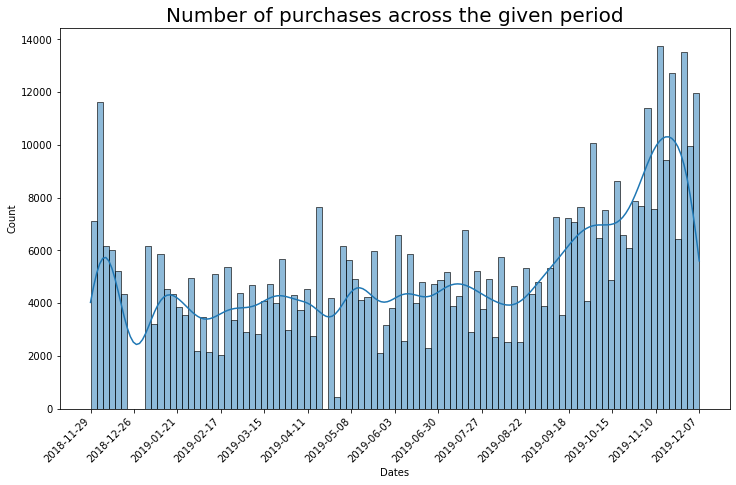

In [99]:
plt.figure(figsize=(12,7))
sns.histplot(df_product['invoice_date'],bins=100, kde = True)

min_date = df_product['invoice_date'].min()
max_date = df_product['invoice_date'].max()
date_ticks = pd.date_range(min_date, max_date, periods=15)

plt.xticks(date_ticks,rotation=45,ha='right')
plt.title('Number of purchases across the given period',size = 20)
plt.xlabel('Dates')
plt.show()

Throughout most of the given time range the number of purchases remains stable, with fluctuations around a value of 4,000. As we approach the end of 2019, the number of purchases steadily increases. This could be attributed to the Christmas and New Year season, or it could be a result of our store gaining popularity over time or launching promotions/advertisements. Anyway, we cannot determine the exact reason for sure as we don't have enough data for it and it is not the focus of our investigation. Let's simply acknowledge this observation. At the same time, in 2019 Christmas and New Year were the period of sudden zeroeing of purchases, probably due the closure of the store back then. In the 2019 the situation is opposite.

Moving on to distribution of sales across product categories.

In [100]:
category_stats = (df_product
                  .groupby('category')
                  .agg({'revenue': ['sum', 'mean'], 'description':'count'}))
category_stats.columns = ['total_revenue', 'average_revenue','n_purchases']
category_stats['revenue_share'] = category_stats['total_revenue'] / category_stats['total_revenue'].sum() * 100
category_stats = category_stats.sort_values('total_revenue', ascending=False)
round(category_stats,2)

total_revenue  average_revenue  n_purchases  \
category                                                             
home_decor                2520885.82            21.06       119718   
kitchen_dining            2294249.87            19.24       119219   
accessories               1220764.33            20.17        60518   
other                      966389.20            16.31        59259   
holidays_celebrations      964185.85            18.03        53476   
games_hobbies_kids         718185.18            20.35        35296   
personal_care              387089.50            20.24        19121   
furniture_storage          350308.49            18.97        18471   
stationery                 286761.35            10.81        26526   
tools                      107966.79            15.37         7025   

                       revenue_share  
category                              
home_decor                     25.68  
kitchen_dining                 23.37  
accessories                    12.44  
other                           9.84  
holidays_celebrations           9.82  
games_hobbies_kids              7.32  
personal_care                   3.94  
furniture_storage               3.57  
stationery                      2.92  
tools                           1.10

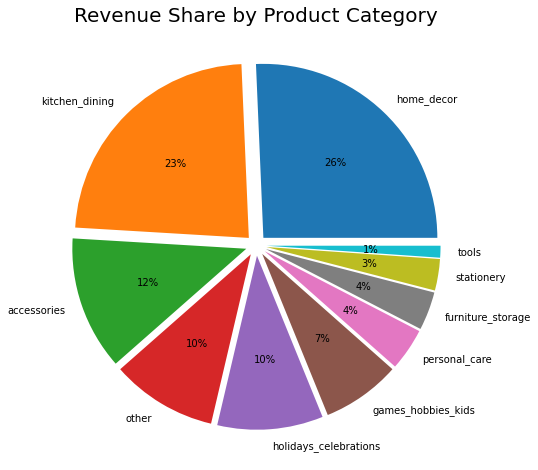

In [101]:
fig, ax = plt.subplots(figsize=(8, 8))  
explode_value = 0.06
explode = np.ones(len(category_stats)) * explode_value
plt.pie(category_stats['revenue_share'], labels=category_stats.index, autopct='%1.0f%%', explode=explode)
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.title('Revenue Share by Product Category',fontdict={'size':20})
plt.show()

In [102]:
print('Purchase Share by Product Category')
print('')
print(round(df_product['category'].value_counts(normalize=True)*100,2))

Purchase Share by Product Category

home_decor               23.08
kitchen_dining           22.99
accessories              11.67
other                    11.43
holidays_celebrations    10.31
games_hobbies_kids        6.81
stationery                5.11
personal_care             3.69
furniture_storage         3.56
tools                     1.35
Name: category, dtype: float64


The categories 'kitchen_dining' and 'home_decore' are similar in revenue share, holding for of 23-26% of our revenue which corresponds with their shares in quantity of purchased products (22% and 23%).

## Outliers

I suggest checking values distributions closer, for outliers in particular. But not to exclude extreme values from the data, as we need to consider all purchases made, regardless how extreme they may be. Otherwise, we would lose significant data that could lead us to a different conclusion. But rather as an additional method to identify incosistencies and errors in the data that we may have unnoticed during the preprocessing stage. 

### Quantity

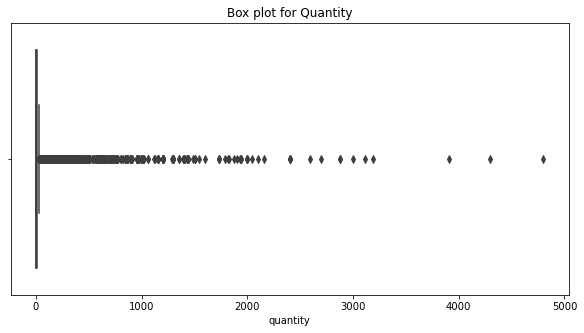

In [103]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='quantity', data=df_product)
plt.title('Box plot for Quantity')
plt.show()

We observe some extremely rare values; let's establish an upper outlier threshold to investigate high-quantity purchases further.

In [104]:
Q1 = df_product['quantity'].quantile(0.25)
Q3 = df_product['quantity'].quantile(0.75)

IQR = Q3 - Q1

upper_outlier_level = Q3 + 1.5 * IQR

print(f"Quantity Q1: {Q1}")
print(f"Quantity Q3: {Q3}")
print(f"Quantity IQR: {IQR}")
print(f"Quantity Upper Outlier Level: {upper_outlier_level}")


Quantity Q1: 1.0
Quantity Q3: 11.0
Quantity IQR: 10.0
Quantity Upper Outlier Level: 26.0


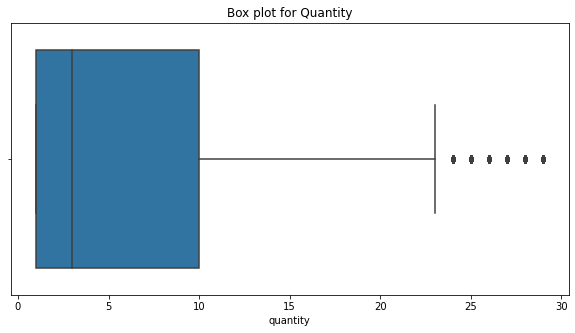

In [105]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='quantity', data=df_product.query('quantity<30'))
plt.title('Box plot for Quantity')
plt.show()

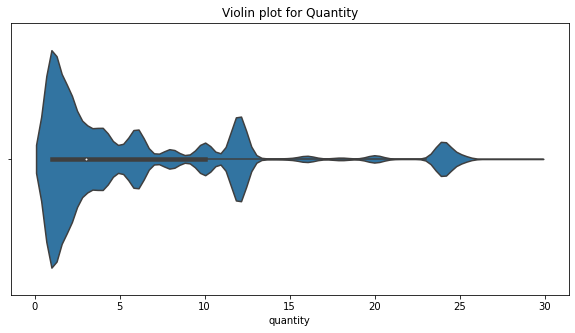

In [106]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='quantity', data=df_product.query('quantity<30'))
plt.title('Violin plot for Quantity')
plt.show()

In [107]:
round(len(df_product.query('quantity<30'))/len(df_product)*100,2)

94.94

The outlier quantity level of 30 units excludes just 5% of the total data. However, as we can see from the first box plot, there are more quantity values before they become too extreme. Let's define outliers for truly extreme values and check those purchases later.

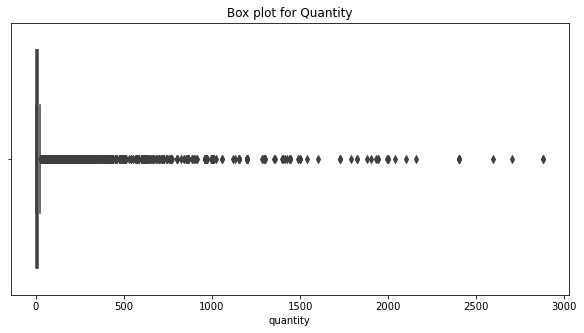

In [108]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='quantity', data=df_product.query('quantity<3000'))
plt.title('Box plot for Quantity')
plt.show()

So, values around 1500 becomes too rare

In [109]:
extreme_quant = df_product.query('quantity>1500').sort_values('quantity', ascending = False)

In [110]:
(df_product
             .groupby('description')
             .agg({'quantity':'sum', 'invoice_no':'nunique','customer_id':'nunique'})
             .rename(columns = {'invoice_no':'n_unique_invoices','customer_id':'n_unique_customer'})
             .reset_index()
             .sort_values('quantity',ascending = False)
             .head(10))

description  quantity  n_unique_invoices  \
3900   world war 2 gliders asstd designs     54807                532   
1793             jumbo bag red retrospot     46390               2069   
2652                      popcorn holder     36549                802   
214        assorted colour bird ornament     36245               1446   
2316     pack of 72 retrospot cake cases     36108               1310   
3810  white hanging heart t-light holder     35283               2234   
2711                  rabbit night light     30673                988   
2083              mini paint set vintage     26489                376   
2282           pack of 12 london tissues     26107                511   
2314  pack of 60 pink paisley cake cases     24628                861   

      n_unique_customer  
3900                306  
1793                634  
2652                296  
214                 677  
2316                633  
3810                854  
2711                448  
2083                212  
2282                195  
2314                410

'world war 2 gliders asstd designs' and 'jumbo bag red retrospot' are our best selling products (in terms of quantity) within whole range of product we have in the initial data.

In [111]:
(extreme_quant
             .groupby('description')
             .agg({'quantity':'sum','invoice_no':'nunique','customer_id':'nunique'})
             .rename(columns = {'invoice_no':'n_unique_invoices','customer_id':'n_unique_customer'})
             .reset_index()
             .sort_values('quantity',ascending = False)
             .head(10))

description  quantity  n_unique_invoices  \
22   world war 2 gliders asstd designs     12000                  4   
19         small chinese style scissor      7000                  3   
15                      popcorn holder      5712                  3   
5   essential balm 35g tin in envelope      5586                  2   
10  grow a flytrap or sunflower in tin      4800                  2   
16                  rabbit night light      4440                  2   
20                small popcorn holder      4300                  1   
4                empire design rosette      3906                  1   
18               red  harmonica in box      3640                  2   
6   fairy cake flannel assorted colour      3114                  1   

    n_unique_customer  
22                  3  
19                  1  
15                  3  
5                   1  
10                  1  
16                  2  
20                  1  
4                   1  
18                  1  
6                   1

4 invoices from 3 customers made a significant impact on our leader - 'world war 2 gliders asstd designs', but not a major one (12 000 itmes out of 54 807). Other purchases from 'extreme' quant also were important for our total sales, but none of them a made a significant share of sales among our overall leaders. So, we can tell that our bestselling items are truly deserved, there were no one-time, accedential purchases, just a significant amount unique purchases from different customers.

4 invoices from 3 customers made a significant impact on our leader - 'world war 2 gliders asstd designs' but not a major one (12,000 items out of 54,807). Other purchases from 'extreme_quant'  also were important for our total sales, but none of them made a significant share of sales among our overall leaders. Therefore, we can conclude that our best-selling items truly deserve their status, as there were no one-time, accidental purchases. Conversely, there was a significant number of unique purchases from different customers.

Anyway let's have a look on the behaviour of those users who made extreme quantity purchases.

In [112]:
(extreme_quant
             .groupby(['customer_id','description'])
             .agg({'quantity':'sum'})
             .reset_index()
             .sort_values(['customer_id','quantity']))            

customer_id                         description  quantity
0             1                      popcorn holder      1820
1         12798                  rabbit night light      2040
2         12875   assorted laquered incense holders      1728
4         12901               rain poncho retrospot      1788
3         12901  pack of 60 pink paisley cake cases      2700
5         12901   world war 2 gliders asstd designs      4800
7         12931                      popcorn holder      1900
6         12931       assorted colour bird ornament      2880
8         13135                small popcorn holder      4300
9         13694       letter shape pencil sharpener      1600
10        14101            pack of 12 skull tissues      2160
11        14609  essential balm 35g tin in envelope      5586
12        14646            gingham heart decoration      1728
13        14646                  rabbit night light      2400
14        15299      assorted colour t-light holder      1824
17        15749  white hanging heart t-light holder      1930
16        15749         gin   tonic diet metal sign      2000
15        15749  fairy cake flannel assorted colour      3114
18        16029  grow a flytrap or sunflower in tin      4800
19        16308         small chinese style scissor      7000
20        16333               red  harmonica in box      3640
21        16333   world war 2 gliders asstd designs      4320
22        16754   world war 2 gliders asstd designs      2880
23        17450            blue vintage spot beaker      1878
24        17450           green vintage spot beaker      1944
25        17450            pink vintage spot beaker      1944
26        17949                      popcorn holder      1992
27        18087               empire design rosette      3906

We will not investigate customers with an ID of #1, as it serves as a proxy for missing IDs. However, we will examine the rest.

In [113]:
(df_product[(df_product['customer_id']
            .isin(extreme_quant['customer_id'])) & (df_product['customer_id'] != 1)]
            .groupby(['customer_id'])
            .agg({'invoice_no':'nunique','description':['count','nunique'],'revenue':'sum'})
            .reset_index()
            .sort_values(('invoice_no', 'nunique')) 
)


customer_id invoice_no description            revenue
                  nunique       count nunique        sum
17       18087          1           1       1    3202.92
14       16754          1           2       2    2002.40
4        13135          1           1       1    3096.00
1        12875          2           2       1     343.23
10       15749          2           6       5   24850.90
0        12798          3           8       6    6977.04
7        14609          4           4       2     601.56
12       16308          4           4       1    2560.00
6        14101          6          35      15    5976.79
9        15299          6           6       6    3907.01
3        12931         15          78      30   40209.52
13       16333         22          45       9   26626.80
2        12901         26         113      29   16889.54
16       17949         39          62      28   52408.44
15       17450         45         334     124  189607.53
5        13694         50         558     365   63266.98
11       16029         56         194      39   52336.65
8        14646         72        2054     716  277885.22

At least half of those customers that have placed extreme orders are not our very regular customers.

In [114]:
df_product[df_product['customer_id'] == 15749]

invoice_no stock_code                         description  quantity  \
52771      540818     47556b                 tea time tea towels      1300   
160542     550461     85123a  white hanging heart t-light holder      1930   
160543     550461     47556b                 tea time tea towels      1300   
160544     550461      48185                  doormat fairy cake       670   
160545     550461      21175         gin   tonic diet metal sign      2000   
160546     550461      21108  fairy cake flannel assorted colour      3114   

              invoice_date  unit_price  customer_id features  \
52771  2019-01-09 12:57:00        2.55        15749       []   
160542 2019-04-16 13:20:00        2.40        15749  [white]   
160543 2019-04-16 13:20:00        2.10        15749       []   
160544 2019-04-16 13:20:00        6.35        15749       []   
160545 2019-04-16 13:20:00        1.69        15749  [metal]   
160546 2019-04-16 13:20:00        2.10        15749       []   

                         clean_description        category  revenue  \
52771                   tea time tea towel  kitchen_dining   3315.0   
160542        hanging heart t-light holder      home_decor   4632.0   
160543                  tea time tea towel  kitchen_dining   2730.0   
160544                  doormat fairy cake      home_decor   4254.5   
160545                 gin tonic diet sign           other   3380.0   
160546  fairy cake flannel assorted colour  kitchen_dining   6539.4   

        invoice_weekday  invoice_month invoice_month_dt invoice_month_year  
52771                 2              1       2019-01-01      January, 2019  
160542                1              4       2019-04-01        April, 2019  
160543                1              4       2019-04-01        April, 2019  
160544                1              4       2019-04-01        April, 2019  
160545                1              4       2019-04-01        April, 2019  
160546                1              4       2019-04-01        April, 2019

In [115]:
df_product[df_product['customer_id'] == 18087]

invoice_no stock_code            description  quantity  \
97432     544612      22053  empire design rosette      3906   

             invoice_date  unit_price  customer_id  features  \
97432 2019-02-20 10:43:00        0.82        18087  [design]   

      clean_description category  revenue  invoice_weekday  invoice_month  \
97432    empire rosette    other  3202.92                2              2   

      invoice_month_dt invoice_month_year  
97432       2019-02-01     February, 2019

And just a few of those not regular customers have significantly affected revenue (customers 15749 and 18087). Nothing suspicious has been revealed in the behaviour and no patterns have been identified either. It is a bit unusual (especially placing a one-time huge order for 'empire design rosette'), but not more than that. Most liklely purchases with an extreme number of items in the order were made by corporate customers. After further analyzing the parameters per invoice we would likely consider splitting customers into individual and corporate categories.

### Unit Price

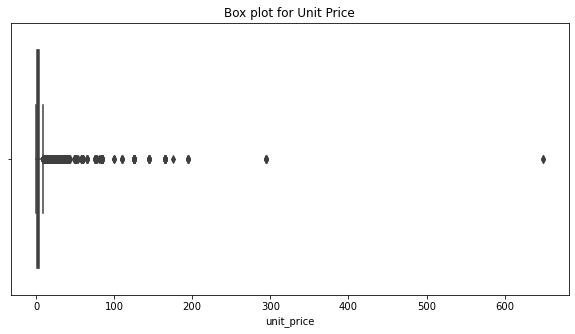

In [116]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='unit_price', data=df_product)
plt.title('Box plot for Unit Price')
plt.show()

We observe some extremely rare values, let's establish an upper outlier threshold to investigate high-priced items further.

In [117]:
Q1 = df_product['unit_price'].quantile(0.25)
Q3 = df_product['unit_price'].quantile(0.75)

IQR = Q3 - Q1

upper_outlier_level = Q3 + 1.5 * IQR

print(f"Price Q1: {Q1}")
print(f"Price Q3: {Q3}")
print(f"Price IQR: {IQR}")
print(f"Price Upper Outlier Level: {upper_outlier_level}")

Price Q1: 1.25
Price Q3: 4.13
Price IQR: 2.88
Price Upper Outlier Level: 8.45


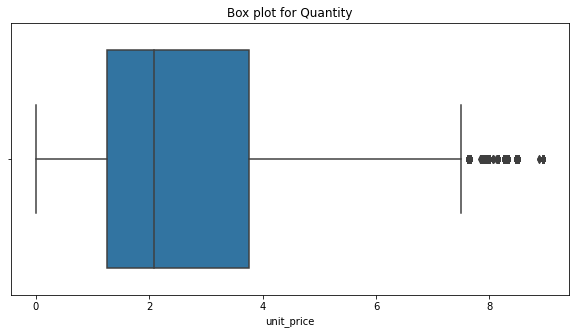

In [118]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='unit_price', data=df_product.query('unit_price<9'))
plt.title('Box plot for Quantity')
plt.show()

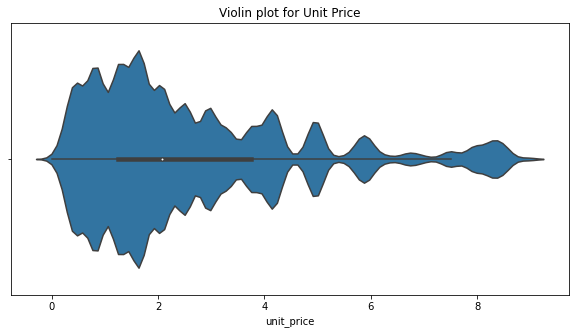

In [119]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='unit_price', data=df_product.query('unit_price<9'))
plt.title('Violin plot for Unit Price')
plt.show()

In [120]:
round(len(df_product.query('unit_price<9'))/len(df_product)*100,2)

94.62

The outlier price level of 9 units excludes 5% of the total data. However, as we can see from the first box plot, there are more price values before they become too extreme. Let's define outliers for truly extreme values.

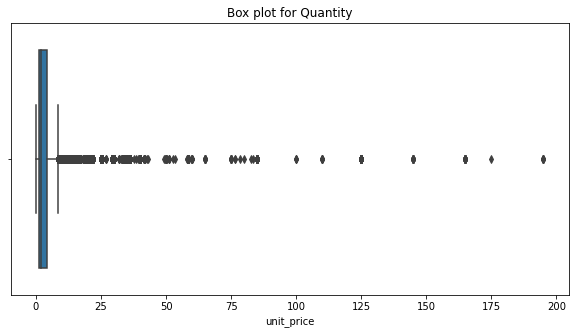

In [121]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='unit_price', data=df_product.query('unit_price<250'))
plt.title('Box plot for Quantity')
plt.show()

So prices above 75 are becoming extremly rare.

In [122]:
exp_products = df_product.query('unit_price > 75')['description'].unique()
exp_products

array(['rustic  seventeen drawer sideboard',
       'vintage post office cabinet', 'vintage red kitchen cabinet',
       'set of 4 white retro storage cubes',
       'regency mirror with shutters', 'love seat antique white metal',
       'vintage blue kitchen cabinet', 'chest natural wood 20 drawers',
       'hall cabinet with 3 drawers', 'medina stamped metal stool',
       'sweetheart cream steel table rect',
       'picnic basket wicker 60 pieces', 'cinderella chandelier',
       'ivory embroidered quilt', 'dotcomgiftshop gift voucher 10000'],
      dtype=object)

Let's check if the prices for expensive products varies

Price distribution for item "rustic  seventeen drawer sideboard"
165.0    15
145.0     9
Name: unit_price, dtype: int64


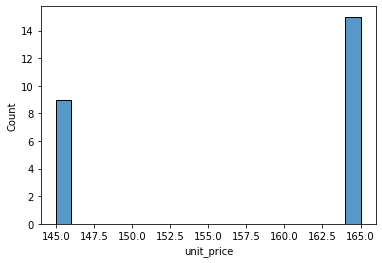

____________________
Price distribution for item "vintage post office cabinet"
79.95    1
52.77    1
Name: unit_price, dtype: int64


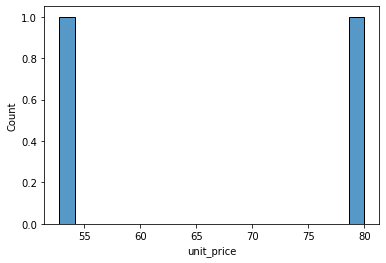

____________________
Price distribution for item "vintage red kitchen cabinet"
125.0    28
295.0     3
50.0      2
Name: unit_price, dtype: int64


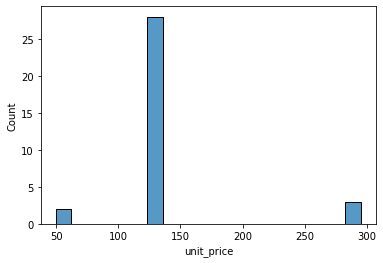

____________________
Price distribution for item "set of 4 white retro storage cubes"
39.95    87
58.29    29
34.95    21
74.96     9
76.55     2
53.55     1
Name: unit_price, dtype: int64


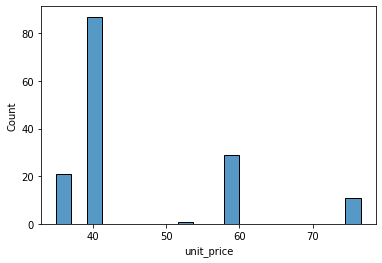

____________________
Price distribution for item "regency mirror with shutters"
165.0    4
145.0    3
Name: unit_price, dtype: int64


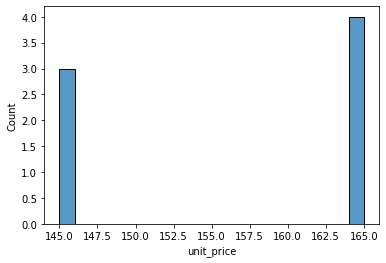

____________________
Price distribution for item "love seat antique white metal"
85.0     29
195.0     7
175.0     1
Name: unit_price, dtype: int64


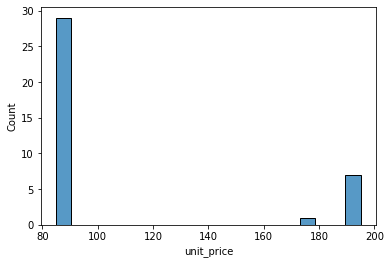

____________________
Price distribution for item "vintage blue kitchen cabinet"
125.0    13
295.0     3
50.0      1
Name: unit_price, dtype: int64


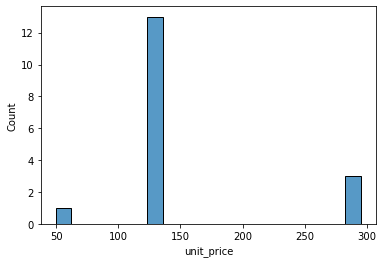

____________________
Price distribution for item "chest natural wood 20 drawers"
125.0    7
110.0    6
Name: unit_price, dtype: int64


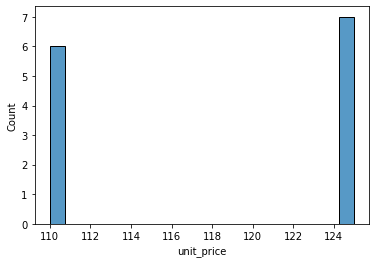

____________________
Price distribution for item "hall cabinet with 3 drawers"
49.95     3
32.69     1
100.00    1
Name: unit_price, dtype: int64


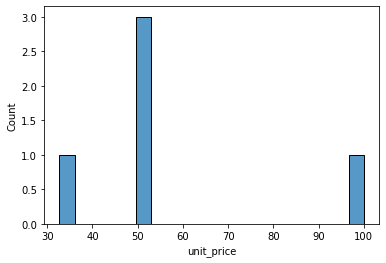

____________________
Price distribution for item "medina stamped metal stool"
39.95    13
78.29     1
5.00      1
34.95     1
Name: unit_price, dtype: int64


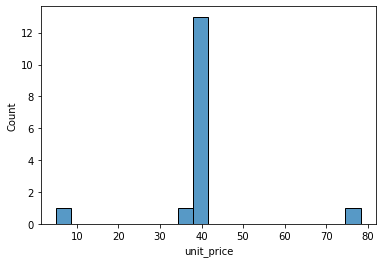

____________________
Price distribution for item "sweetheart cream steel table rect"
19.95    20
99.96     1
Name: unit_price, dtype: int64


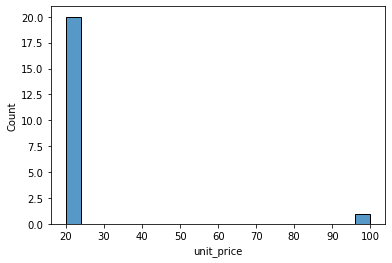

____________________
Price distribution for item "picnic basket wicker 60 pieces"
649.5    2
Name: unit_price, dtype: int64


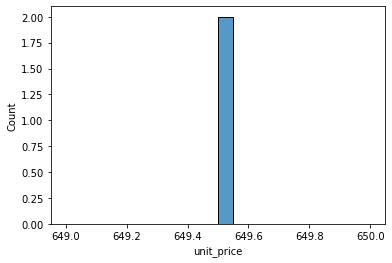

____________________
Price distribution for item "cinderella chandelier"
49.95    9
41.75    2
99.96    1
10.00    1
Name: unit_price, dtype: int64


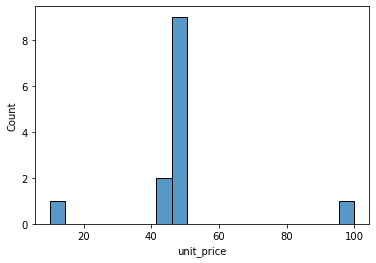

____________________
Price distribution for item "ivory embroidered quilt"
39.95    15
35.75    11
33.29     4
82.50     1
Name: unit_price, dtype: int64


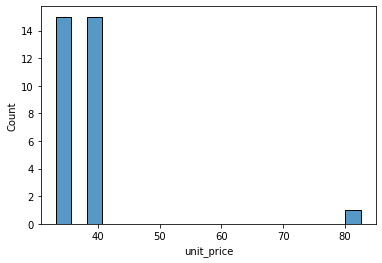

____________________
Price distribution for item "dotcomgiftshop gift voucher 10000"
83.33    1
Name: unit_price, dtype: int64


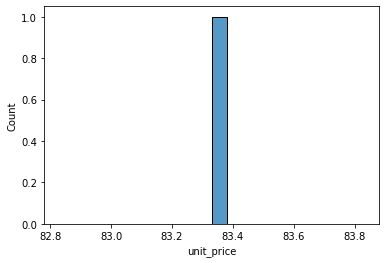

____________________


In [123]:
for each in exp_products:
    print('Price distribution for item "{}"'.format(each))
    print(df_product.query(f'description == "{each}"')['unit_price'].value_counts())
    sns.histplot(df_product.query('description == @each')['unit_price'],bins = 20)
    plt.show()
    print('_'*20)

In most cases prices varies but it is normal unless the difference between maximum and minimum prices is not significant and we have some.

In [124]:
df_product.query("description.str.contains('kitchen cabinet')").groupby(['description', 'unit_price']).size()

description                   unit_price
vintage blue kitchen cabinet  50.0           1
                              125.0         13
                              295.0          3
vintage red kitchen cabinet   50.0           2
                              125.0         28
                              295.0          3
dtype: int64

In [125]:
df_product.query("description.str.contains('kitchen cabinet')").sort_values('invoice_date')

invoice_no stock_code                   description  quantity  \
4989       536835      22655   vintage red kitchen cabinet         1   
28866      538662      22655   vintage red kitchen cabinet         2   
28902      538662      22656  vintage blue kitchen cabinet         2   
31613      538999      22655   vintage red kitchen cabinet         2   
31614      538999      22656  vintage blue kitchen cabinet         2   
31851      539016      22655   vintage red kitchen cabinet         2   
32198      539044      22656  vintage blue kitchen cabinet         2   
32199      539044      22655   vintage red kitchen cabinet         2   
36187      539440      22655   vintage red kitchen cabinet         2   
38529      539581      22656  vintage blue kitchen cabinet         2   
51636      540647      22655   vintage red kitchen cabinet         1   
51675      540653      22655   vintage red kitchen cabinet         2   
54382      540946      22656  vintage blue kitchen cabinet         1   
54395      540946      22655   vintage red kitchen cabinet         1   
56144      541043      22655   vintage red kitchen cabinet         2   
59318      541282      22655   vintage red kitchen cabinet         2   
70795      542102      22655   vintage red kitchen cabinet         2   
71387      542122      22655   vintage red kitchen cabinet         2   
84183      543370      22656  vintage blue kitchen cabinet         1   
84184      543370      22655   vintage red kitchen cabinet         1   
104262     545158      22655   vintage red kitchen cabinet         1   
104263     545158      22656  vintage blue kitchen cabinet         1   
108482     545543      22655   vintage red kitchen cabinet         1   
111543     545759      22656  vintage blue kitchen cabinet         2   
111542     545759      22655   vintage red kitchen cabinet         2   
112940     545902      22655   vintage red kitchen cabinet         1   
114575     546028      22655   vintage red kitchen cabinet         2   
118769     546480      22656  vintage blue kitchen cabinet         1   
133994     547814      22656  vintage blue kitchen cabinet         1   
136113     547935      22656  vintage blue kitchen cabinet         1   
145783     548907      22655   vintage red kitchen cabinet         2   
168385     551035      22655   vintage red kitchen cabinet         2   
170890     551347      22655   vintage red kitchen cabinet         2   
171178     551393      22656  vintage blue kitchen cabinet         1   
175419     551957      22655   vintage red kitchen cabinet         2   
205432     554810      22655   vintage red kitchen cabinet         1   
205431     554810      22656  vintage blue kitchen cabinet         1   
205759     554836      22655   vintage red kitchen cabinet         1   
213014     555515      22656  vintage blue kitchen cabinet         1   
213015     555515      22655   vintage red kitchen cabinet         1   
215909     555742      22656  vintage blue kitchen cabinet         2   
233455     557471      22655   vintage red kitchen cabinet         2   
240211     558092      22656  vintage blue kitchen cabinet         1   
247313     558762      22655   vintage red kitchen cabinet         2   
335345     566283      22655   vintage red kitchen cabinet         1   
354251     567868      22655   vintage red kitchen cabinet         2   
393465     570827      22656  vintage blue kitchen cabinet         1   
412157     572281      22655   vintage red kitchen cabinet         1   
420822     572911      22655   vintage red kitchen cabinet         2   
433190     573905      22655   vintage red kitchen cabinet         1   

              invoice_date  unit_price  customer_id         features  \
4989   2018-11-30 18:06:00       295.0        13145   [red, vintage]   
28866  2018-12-11 15:44:00       125.0        15159   [red, vintage]   
28902  2018-12-11 15:44:00       125.0        15159  [vintage, blue]   
31613  2018-12-13 12:09:00       125.0        

There is no apparent dependence of price on quantity or date. It is possible that the price of 50 could be explained by a discount, while the price of 295 may be a result of short-term market fluctuations. The same situation as well with "love seat antique white metal"

Now suggest checking the most expensive product we have - "picnic basket wicker 60 pieces". This is quite unexpected item to be so expensive. Let's compare it with other picnic basket.

In [126]:
(df_product.query("description.str.contains('picnic basket')")
        .groupby(['description', 'unit_price'])
        .agg({'stock_code':'count','revenue':'sum'}))
        

stock_code   revenue
description                    unit_price                      
picnic basket wicker 60 pieces 649.50               2  39619.50
picnic basket wicker large     3.00                 1      3.00
                               7.62                 1    228.60
                               8.50                24   5771.50
                               9.95               229   4726.25
                               20.79              166   7900.20
                               21.23               20    573.21
picnic basket wicker small     2.00                 1      2.00
                               4.95                29   3460.05
                               5.95               207   4087.65
                               8.29                96   1533.65
                               8.47                29    474.32
                               8.95                 1    268.50
                               10.79               98   1618.50

It is highly likely that we have encountered error with 60-piece wicker picnic basket, as we see other types of baskets that are significantly cheaper than 649.5 USD. However, we do not have enough evidence to confirm this. Considering that we have not sold many of these baskets, we suggest leaving the price as it. However, it worth to alert data engineers or managers to check and verify the pricing.

### Revenue Per Purchase

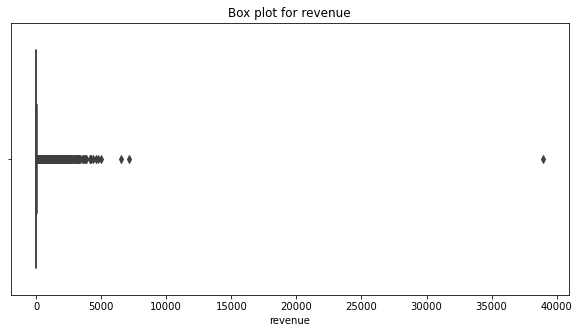

In [127]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='revenue', data=df_product)
plt.title('Box plot for revenue')
plt.show()

In [128]:
Q1 = df_product['revenue'].quantile(0.25)
Q3 = df_product['revenue'].quantile(0.75)

IQR = Q3 - Q1

upper_outlier_level = Q3 + 1.5 * IQR

print(f"Revenue Q1: {Q1}")
print(f"Revenue Q3: {round(Q3,1)}")
print(f"Revenue IQR: {round(IQR,1)}")
print(f"Revenue Upper Outlier Level: {round(upper_outlier_level,1)}")

Revenue Q1: 3.9
Revenue Q3: 17.7
Revenue IQR: 13.8
Revenue Upper Outlier Level: 38.4


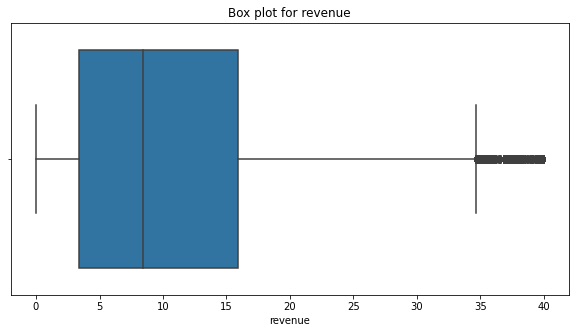

In [129]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='revenue', data=df_product.query('revenue<40'))
plt.title('Box plot for revenue')
plt.show()

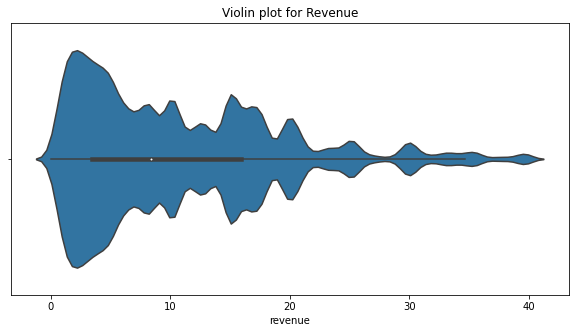

In [130]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='revenue', data=df_product.query('revenue<40'))
plt.title('Violin plot for Revenue')
plt.show()

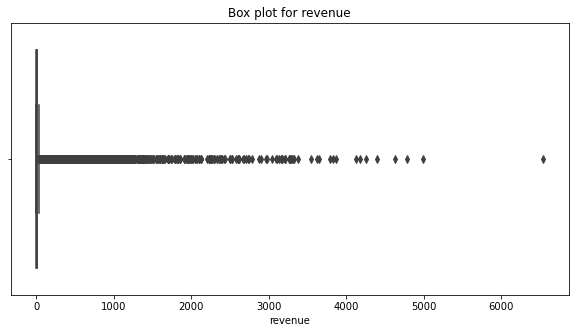

In [131]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='revenue', data=df_product.query('revenue<7000'))
plt.title('Box plot for revenue')
plt.show()

In [132]:
high_revenue = df_product.query('revenue>3500')

In [133]:
(high_revenue
             .groupby(['customer_id','description'])
             .agg({'quantity':'sum','revenue':'sum'})
             .reset_index()     
             .sort_values('revenue',ascending=False))  

customer_id                          description  quantity   revenue
6         15098       picnic basket wicker 60 pieces        60  38970.00
13        17450  set of tea coffee sugar tins pantry      1412   7144.72
9         15749   fairy cake flannel assorted colour      3114   6539.40
5         14646                   rabbit night light      2400   4992.00
0             1        paper chain kit 50s christmas       688   4781.60
10        15749   white hanging heart t-light holder      1930   4632.00
14        17949                 regency teapot roses       540   4401.00
8         15749                   doormat fairy cake       670   4254.50
4         12931        assorted colour bird ornament      2880   4176.00
11        17450                heart of wicker large      1284   4121.64
7         15195       metal sign take it or leave it      1404   3861.00
15        18102         vintage union jack memoboard       600   3828.00
2         12755    round snack boxes set of 4 fruits      1488   3794.40
3         12798                   rabbit night light      2040   3651.60
12        17450    set of 6 spice tins pantry design       852   3621.00
1             1                       popcorn holder      1820   3549.00

No surprises: the largest revenue from single purchases comes from either the most expensive items or from purchases with high quantities.

### Revenue Per Customer

In [134]:
revenue_per_customer = (df_product
                        .groupby('customer_id')['revenue'].sum()
                        .reset_index()
                        .sort_values('revenue',ascending=False))

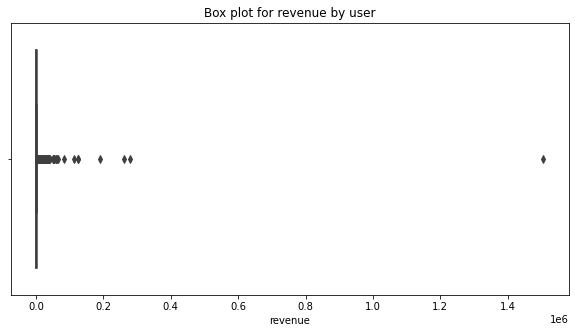

In [135]:
plt.figure(figsize = (10, 5))
sns.boxplot(x ='revenue', data = revenue_per_customer)
plt.title('Box plot for revenue by user')
plt.show()

In [136]:
Q1 = revenue_per_customer['revenue'].quantile(0.25)
Q3 = revenue_per_customer['revenue'].quantile(0.75)

IQR = Q3 - Q1

upper_outlier_level = Q3 + 1.5 * IQR

print(f"Revenue Per Customer Q1: {Q1}")
print(f"Revenue Per Customer Q3: {Q3}")
print(f"Revenue Per Customer IQR: {IQR}")
print(f"Revenue Per Customer Upper Outlier Level: {upper_outlier_level}")

Revenue Per Customer Q1: 301.32
Revenue Per Customer Q3: 1614.31
Revenue Per Customer IQR: 1312.99
Revenue Per Customer Upper Outlier Level: 3583.795


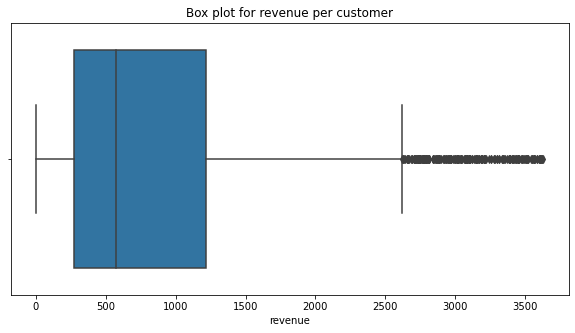

In [137]:
plt.figure(figsize = (10, 5))
sns.boxplot(x ='revenue', data = revenue_per_customer.query('revenue<3630'))
plt.title('Box plot for revenue per customer')
plt.show()

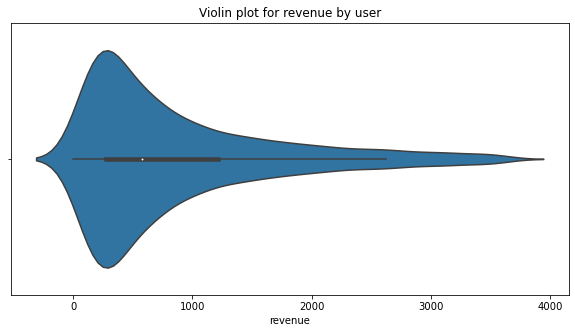

In [138]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=revenue_per_customer.query('revenue<3630'), x = 'revenue')
plt.title('Violin plot for revenue by user')
plt.show()

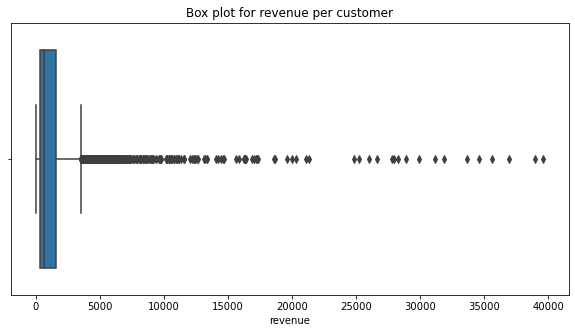

In [139]:
plt.figure(figsize = (10, 5))
sns.boxplot(x ='revenue', data = revenue_per_customer.query('revenue<40000'))
plt.title('Box plot for revenue per customer')
plt.show()

In [140]:
revenue_extreme_users = revenue_per_customer.query('revenue>15000')
revenue_extreme_users.head(10)

customer_id     revenue
0               1  1505865.32
1683        14646   277885.22
4189        18102   259657.30
3718        17450   189607.53
1873        14911   124449.18
55          12415   123806.88
1328        14156   113721.28
3761        17511    82112.38
3168        16684    65920.12
992         13694    63266.98

In [141]:
revenue_extreme_users['customer_id'].nunique()

56

In [142]:
round((revenue_extreme_users['customer_id'].nunique()/df_product['customer_id'].nunique())*100,2)

1.29

In [143]:
round((revenue_extreme_users['revenue'].sum()/df_product['revenue'].sum())*100,2)

42.75

In [144]:
round((revenue_extreme_users[revenue_extreme_users['customer_id'] != 1]['revenue'].sum()/df_product['revenue'].sum())*100,2)

27.41

56 customers that have generated extremely high revenue comparing to the rest of them (revenue_extreme_users) comprise just 1.29% of the total number of customers. However, they are responsible for 42.75% of our revenue (27.4% if we exclude user #1, which is a proxy for missing values).

We suggest examining our sales data to identify corporate customers, as it is crucial to distinguish between individual and corporate preferences. Both groups may have different favorite items, and we risk losing second group if we focus only on the most popular or profitable products in our sales data and it keep just corporate favorite items in the product range for the next year (corporate tends to place significantly bigger orders).

To maintain a diverse product range, it is essential to identify the top performers in each category and analyze further RFM metrics separately for individual and corporate customers. 

We can identify corporate customers by considering factors such as revenue size and number of invoices. Higher values increase the likelihood of encountering a corporate customer.

Grouping customers and calculating paramets fro clusterization

In [145]:
customers_stat = (df_product
                  .groupby('customer_id')
                  .agg({'revenue': 'sum', 'quantity': 'sum', 'invoice_no': 'nunique'})
                  .sort_values('revenue',ascending=False))
customers_stat.columns = ['total_revenue', 'total_quantity', 'num_invoices']
customers_stat.reset_index(inplace=True)
customers_stat.head(20)

customer_id  total_revenue  total_quantity  num_invoices
0             1     1505865.32          416963          1365
1         14646      277885.22          195980            72
2         18102      259657.30           64124            60
3         17450      189607.53           69031            45
4         14911      124449.18           74524           194
5         12415      123806.88           77056            19
6         14156      113721.28           56883            54
7         17511       82112.38           59549            30
8         16684       65920.12           49391            28
9         13694       63266.98           62056            50
10        15311       59429.48           37789            90
11        13089       58308.68           31009            96
12        15061       54391.94           28782            48
13        14096       53258.43           16336            17
14        17949       52408.44           27998            39
15        16029       52336.65           29163            56
16        15769       51823.72           27660            25
17        14298       51527.30           58343            44
18        14088       50415.49           12593            13
19        12931       40209.52           26576            15

We are going to use K-mean clustering algorythm to split customers into two clusters based on parameters we calculated above. Since K-mean is sensitive to outliers we have excluded customers with too extreme values of total revenue (over 60 000) and total quantity (over 15 000), which are definetly corporates. "Too extreme" values were determined manually, leaving enough data of obvious corporate customer for algorythm to learn from the remaining 'obvious' corporate customers. After clustering we will manually assign corporate category back to customers that were excluded. As well we have excluded customer #1 which contains purchases of unknown customers, we are going to assign these purhchases to  'unkown' category.

In [146]:
customers_stat = customers_stat[(customers_stat['customer_id'] != 1) & ((customers_stat['total_revenue'] < 50000.0) & (customers_stat['total_quantity'] < 15000.0))]
customers_stat.head(10)

customer_id  total_revenue  total_quantity  num_invoices
20        15098       39619.50              61             2
23        16013       35639.60           14736            46
26        17389       31833.68            7612            34
32        14680       27773.61           13126            16
34        13777       25977.16           12897            33
35        17857       25229.04           14772            22
36        15749       24850.90           10314             2
37        12753       21327.39           11381             6
38        16210       21076.30            7558            17
40        17675       19953.30            8224            30

Normalizing aggregated values to ensure a fair comparison

In [147]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customers_stat[['total_revenue', 'total_quantity', 'num_invoices']])

Applying the K-means algorithm to the normalized data. Setting 2 clusters and zero random state


In [148]:
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(normalized_data)

In [149]:
customers_stat['customer_category'] = cluster_labels

In [150]:
cluster_summary_mean = customers_stat.groupby('customer_category').mean()
cluster_summary_mean

customer_id  total_revenue  total_quantity  num_invoices
customer_category                                                           
0                  15313.339021     938.387742      558.575910      2.922961
1                  15170.954397    7771.556710     4441.387622     16.188925

In [151]:
cluster_summary_count = customers_stat.groupby('customer_category').count()
cluster_summary_count

customer_id  total_revenue  total_quantity  num_invoices
customer_category                                                          
0                         3985           3985            3985          3985
1                          307            307             307           307

Applying categories to our initiall data

In [152]:
df_product = df_product.merge(customers_stat[['customer_id', 'customer_category']], on='customer_id', how='left')

In [153]:
df_product.loc[df_product['customer_id'] == 1, 'customer_category'] = df_product.loc[df_product['customer_id'] == 1, 'customer_category'].fillna('unknown')
df_product.fillna('corporate', inplace=True)
df_product['customer_category'].replace({0.0: 'individual', 1.0: 'corporate'}, inplace=True)

In [154]:
(df_product
         .groupby('customer_category')
         .agg({'customer_id': 'nunique', 'revenue':'sum','quantity':'sum','invoice_no':'nunique'})
         .sort_values('revenue',ascending=False))

customer_id      revenue  quantity  invoice_no
customer_category                                                
corporate                  339  4571445.910   2670990        6614
individual                3985  3739475.153   2225925       11648
unknown                      1  1505865.320    416963        1365

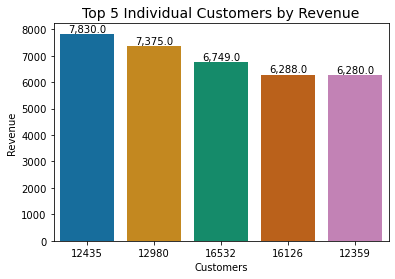

In [155]:
top_individual =(df_product
                         .query('customer_category=="individual"')
                         .groupby('customer_id')
                         .agg({'revenue':'sum','quantity':'sum'})
                         .sort_values('revenue',ascending=False)
                         .head(5)
                         .reset_index())
ax = (sns.barplot(data = top_individual,x='customer_id', y='revenue', palette = 'colorblind',order=top_individual
                  .sort_values('revenue',ascending = False).customer_id))

plt.xlabel('Customers')
plt.ylabel('Revenue')
plt.title('Top 5 Individual Customers by Revenue',size = 14)
for i in ax.containers:
    ax.bar_label(i,labels=[format(round(value,0), ',') for value in i.datavalues])
plt.show()


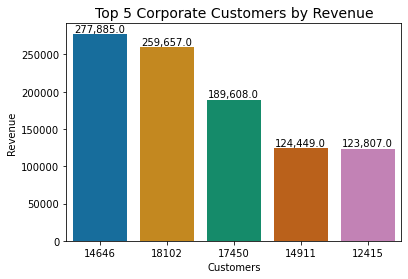

In [156]:
top_corporate =(df_product
                         .query('customer_category=="corporate"')
                         .groupby('customer_id')
                         .agg({'revenue':'sum','quantity':'sum'})
                         .sort_values('revenue',ascending=False)
                         .head(5)
                         .reset_index())
ax = (sns.barplot(data = top_corporate,x='customer_id', y='revenue', palette = 'colorblind',order=top_corporate
                  .sort_values('revenue',ascending = False).customer_id))

plt.xlabel('Customers')
plt.ylabel('Revenue')
plt.title('Top 5 Corporate Customers by Revenue',size = 14)
for i in ax.containers:
    ax.bar_label(i,labels=[format(round(value,0), ',') for value in i.datavalues])
plt.show()

Customers were splitted into 337 corporates and 3,997 individuals ones. Despite having fewer corporate customers their revenue is much higher. It is evident when comparing top 5 customers by revenue in each group. The main factors is quantity: while individual customers bought on average 558 items over the last year corporates customer purchased on average 4 441 of them during the same period.

Let's compare if have different preference for each customer category in terms prdocut categories.

In [157]:
cust_cat_rev = df_product.groupby('customer_category')['revenue'].sum().reset_index()
cust_cat_rev['share'] = round(cust_cat_rev['revenue']/cust_cat_rev['revenue'].sum()*100,2)
cust_cat_rev

customer_category      revenue  share
0         corporate  4571445.910  46.57
1        individual  3739475.153  38.09
2           unknown  1505865.320  15.34

In [158]:
corp_cat_stat  = (df_product
                  .query('customer_category == "corporate"')
                  .groupby(['category','customer_category'])['revenue'].sum()
                  .reset_index())

corp_cat_stat['revenue_share'] = corp_cat_stat['revenue']/corp_cat_stat['revenue'].sum()*100
corp_cat_stat = corp_cat_stat.sort_values('revenue_share', ascending = False)
corp_cat_stat

category customer_category     revenue  revenue_share
4             home_decor         corporate  1234324.15      27.000738
5         kitchen_dining         corporate  1108219.63      24.242212
0            accessories         corporate   593411.09      12.980818
6                  other         corporate   450098.16       9.845860
3  holidays_celebrations         corporate   377849.50       8.265426
2     games_hobbies_kids         corporate   342919.29       7.501331
1      furniture_storage         corporate   163171.52       3.569363
7          personal_care         corporate   145073.58       3.173473
8             stationery         corporate   111788.78       2.445370
9                  tools         corporate    44590.21       0.975407

In [159]:
individual_cat_stat  = (df_product
                  .query('customer_category == "individual"')
                  .groupby(['category','customer_category'])['revenue'].sum()
                  .reset_index())

individual_cat_stat['revenue_share'] = individual_cat_stat['revenue']/individual_cat_stat['revenue'].sum()*100
individual_cat_stat = individual_cat_stat.sort_values('revenue_share', ascending = False)
individual_cat_stat

category customer_category     revenue  revenue_share
4             home_decor        individual  950558.613      25.419573
5         kitchen_dining        individual  827377.830      22.125507
3  holidays_celebrations        individual  411390.470      11.001289
6                  other        individual  403517.150      10.790743
0            accessories        individual  381917.120      10.213121
2     games_hobbies_kids        individual  273102.350       7.303227
7          personal_care        individual  162098.880       4.334803
1      furniture_storage        individual  148411.580       3.968781
8             stationery        individual  133014.390       3.557034
9                  tools        individual   48086.770       1.285923

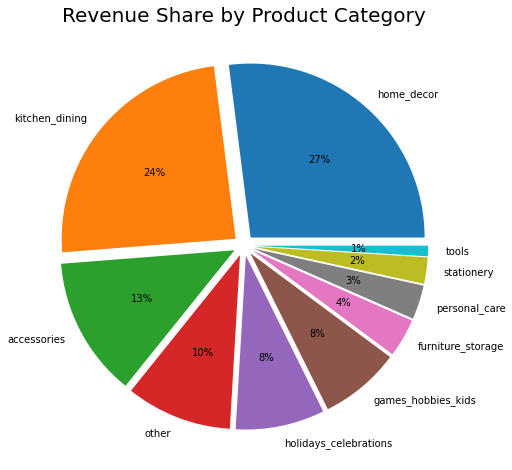

In [160]:
fig, ax = plt.subplots(figsize=(8, 8))  
explode_value = 0.06
explode = np.ones(len(corp_cat_stat)) * explode_value
plt.pie(corp_cat_stat['revenue_share'], labels=corp_cat_stat['category'], autopct='%1.0f%%', explode=explode)
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.title('Revenue Share by Product Category',fontdict={'size':20})
plt.show()

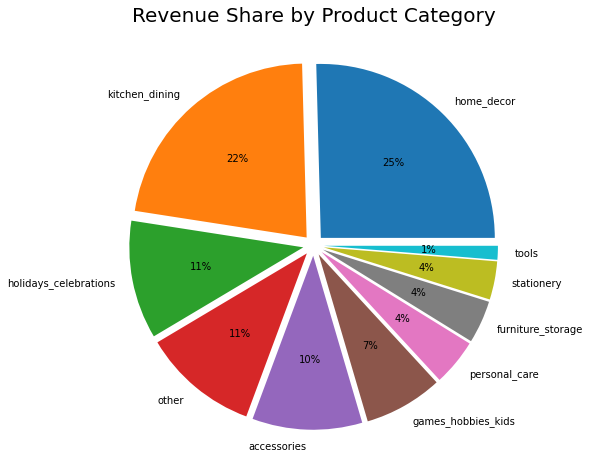

In [161]:
fig, ax = plt.subplots(figsize=(8, 8))  
explode_value = 0.06
explode = np.ones(len(corp_cat_stat)) * explode_value
plt.pie(individual_cat_stat['revenue_share'], labels=individual_cat_stat['category'], autopct='%1.0f%%', explode=explode)
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.title('Revenue Share by Product Category',fontdict={'size':20})
plt.show()

In [162]:
merged_table = corp_cat_stat[['category', 'revenue_share']].merge(individual_cat_stat[['category', 'revenue_share']], on='category', how='left', suffixes = ['_corp','_indiv'])
merged_table['diff'] = merged_table['revenue_share_corp'] - merged_table['revenue_share_indiv']
round(merged_table,2)

category  revenue_share_corp  revenue_share_indiv  diff
0             home_decor               27.00                25.42  1.58
1         kitchen_dining               24.24                22.13  2.12
2            accessories               12.98                10.21  2.77
3                  other                9.85                10.79 -0.94
4  holidays_celebrations                8.27                11.00 -2.74
5     games_hobbies_kids                7.50                 7.30  0.20
6      furniture_storage                3.57                 3.97 -0.40
7          personal_care                3.17                 4.33 -1.16
8             stationery                2.45                 3.56 -1.11
9                  tools                0.98                 1.29 -0.31

Except for minor differences in holidays_celebrations, accessories, and kitchen_dining the preferences are the same for both customer categories.

## Most Profitable/Selling Products

As we previously mentioned defining the leaders and the outsiders within products we sell need to be done with considering the preferences of different customer categories. I suggest making up top 5 rating for each category.

Function to automate filtering the data depending on cusomer's category and subsequent grouping. At first we need to determine most profitable prouducts (with highest total revenue).

In [163]:
def product_profit_customer_cat(category):
    product_profit_customer_cat = (df_product
                            .query('customer_category == @category')
                            .groupby('description')
                            .agg({'revenue':'sum','quantity':'sum'})
                            .reset_index())
    most_profitable = product_profit_customer_cat.sort_values('revenue', ascending=False).head()

    return most_profitable

Function to automate printing the results

In [164]:
def print_results1(title, results1):
    print(f"{title}")
    print(' ')
    print("Most Profitable Items")
    print(results1)
    print(' ')
    print('-' * 70)

In [165]:
corporate_results1 = product_profit_customer_cat('corporate')
print_results1("Rating for Corporate Users", corporate_results1)

individual_results1 = product_profit_customer_cat('individual')
print_results1("Rating for Individual Users", individual_results1)

unknown_results1 = product_profit_customer_cat('unknown')
print_results1("Rating for Unknown Users", unknown_results1)

Rating for Corporate Users
 
Most Profitable Items
                             description   revenue  quantity
2456            regency cakestand 3 tier  89469.90      7941
3316  white hanging heart t-light holder  56523.85     20763
1550             jumbo bag red retrospot  54808.96     30352
2132      picnic basket wicker 60 pieces  39619.50        61
2346                  rabbit night light  36200.45     19159
 
----------------------------------------------------------------------
Rating for Individual Users
 
Most Profitable Items
                             description   revenue  quantity
2658            regency cakestand 3 tier  46556.05      3881
3570  white hanging heart t-light holder  37202.70     13354
2263                       party bunting  32651.90      7044
203        assorted colour bird ornament  26806.32     16248
1695             jumbo bag red retrospot  26719.00     13745
 
----------------------------------------------------------------------
Rating for Unknown 

We have some intersections across categories. Let's concatenate the ratings and count how often a product from each rating appears in the rest of the ratings.

In [166]:
all_results1 = pd.concat([corporate_results1, individual_results1, unknown_results1])
summary_profit_rating = all_results1.groupby('description').size().reset_index(name='count').sort_values('count',ascending=False)
summary_profit_rating

description  count
8            regency cakestand 3 tier      3
3             jumbo bag red retrospot      2
5                       party bunting      2
9  white hanging heart t-light holder      2
0       assorted colour bird ornament      1
1           charlotte bag suki design      1
2   hot water bottle tea and sympathy      1
4       paper chain kit 50s christmas      1
6      picnic basket wicker 60 pieces      1
7                  rabbit night light      1

And the winner is 'Regency Cakestand 3 Tier'! It is the only product that secured 3 first places out of 3 categories.  'Jumbo Bag Red Retrospot', 'Party Bunting', and 'White Hanging Heart T-Light Holder' are very profitable within two categories out of three. The rest of the products appear just once. However, every product from these ratings is definitely worth retaining in our product range for the next year.

Now most selling product (the highest quantity values)

In [167]:
def product_quant_customer_cat(category):
    product_quant_customer_cat = (df_product
                            .query('customer_category == @category')
                            .groupby('description')
                            .agg({'revenue':'sum','quantity':'sum'})
                            .reset_index())

    most_selling = product_quant_customer_cat.sort_values('quantity', ascending=False).head()
    
    return most_selling

In [168]:
def print_results2(title, results2):
    print(f"{title}")
    print(' ')
    print("Most Selling Items")
    print(results2)
    print(' ')
    print('-' * 70)

In [169]:
corporate_results2 = product_quant_customer_cat('corporate')
print_results2("Rating for Corporate Users", corporate_results2)

individual_results2 = product_quant_customer_cat('individual')
print_results2("Rating for Individual Users", individual_results2)

unknown_results2 = product_quant_customer_cat('unknown')
print_results2("Rating for Unknown Users", unknown_results2)

Rating for Corporate Users
 
Most Selling Items
                            description   revenue  quantity
3395  world war 2 gliders asstd designs   7451.72     31454
1550            jumbo bag red retrospot  54808.96     30352
2305                     popcorn holder  17293.61     23225
2017    pack of 72 retrospot cake cases  10149.50     21964
1983          pack of 12 london tissues   5965.69     21327
 
----------------------------------------------------------------------
Rating for Individual Users
 
Most Selling Items
                             description   revenue  quantity
3655   world war 2 gliders asstd designs   6064.93     22721
203        assorted colour bird ornament  26806.32     16248
1695             jumbo bag red retrospot  26719.00     13745
3570  white hanging heart t-light holder  37202.70     13354
2191     pack of 72 retrospot cake cases   6179.58     11610
 
----------------------------------------------------------------------
Rating for Unknown Users
 
Most

In [170]:
all_results2 = pd.concat([corporate_results2, individual_results2, unknown_results2])
summary_quant_rating = all_results2.groupby('description').size().reset_index(name='count').sort_values('count',ascending=False)
summary_quant_rating

description  count
2              jumbo bag red retrospot      2
4      pack of 72 retrospot cake cases      2
6                       popcorn holder      2
10   world war 2 gliders asstd designs      2
0        assorted colour bird ornament      1
1            charlotte bag suki design      1
3            pack of 12 london tissues      1
5        paper chain kit 50s christmas      1
7          red retrospot charlotte bag      1
8   white hanging heart t-light holder      1
9               woodland charlotte bag      1

As for the quantity we have slightly different leaders: 'jumbo bag red retrospot','pack of 72 retrospot cake cases' 'popcorn holder', 'world war 2 gliders asstd designs'. With only 'jumbo bag red retrospot' being in top three for both ratings. Let's merge these two ratings.

In [171]:
profit_quant_rating = pd.merge(summary_profit_rating, summary_quant_rating, on='description', how='outer', suffixes = ('_revenue', '_quantity'))
profit_quant_rating

description  count_revenue  count_quantity
0             regency cakestand 3 tier            3.0             NaN
1              jumbo bag red retrospot            2.0             2.0
2                        party bunting            2.0             NaN
3   white hanging heart t-light holder            2.0             1.0
4        assorted colour bird ornament            1.0             1.0
5            charlotte bag suki design            1.0             1.0
6    hot water bottle tea and sympathy            1.0             NaN
7        paper chain kit 50s christmas            1.0             1.0
8       picnic basket wicker 60 pieces            1.0             NaN
9                   rabbit night light            1.0             NaN
10     pack of 72 retrospot cake cases            NaN             2.0
11                      popcorn holder            NaN             2.0
12   world war 2 gliders asstd designs            NaN             2.0
13           pack of 12 london tissues            NaN             1.0
14         red retrospot charlotte bag            NaN             1.0
15              woodland charlotte bag            NaN             1.0

In half cases the high revenue means hight quantity. Nontheless every item we have in both rating is our most valueble products. 

## Least Profitable/Selling Products


Now the same approach to define the least profitable and the least selling products

In [172]:
def product_rev_outsider_customer_cat(category):
    product_rev_outsider_customer_cat = (df_product
                            .query('customer_category == @category')
                            .groupby('description')
                            .agg({'revenue':'sum','quantity':'sum'})
                            .reset_index())
    least_profitable = product_rev_outsider_customer_cat.sort_values('revenue', ascending=True).head()
   
    return least_profitable

In [173]:
def print_results3(title, results3):
    print(f"{title}")
    print(' ')
    print("Least Profitable Items")
    print(results3)
    print(' ')
    print('-' * 70)

In [174]:
corporate_results3 = product_rev_outsider_customer_cat('corporate')
print_results3("Rating for Corporate Users", corporate_results3)

individual_results3 = product_rev_outsider_customer_cat('individual')
print_results3("Rating for Individual Users", individual_results3)

unknown_results3 = product_rev_outsider_customer_cat('unknown')
print_results3("Rating for Unknown Users", unknown_results3)

Rating for Corporate Users
 
Least Profitable Items
                             description  revenue  quantity
304   black feather christmas decoration     0.19         1
2175      pink crystal skull phone charm     0.19         1
209               asstd rasta key-chains     0.42         1
2826               silicon cube 25w blue     0.42         1
1425       hen house with chick standing     0.42         1
 
----------------------------------------------------------------------
Rating for Individual Users
 
Least Profitable Items
                          description  revenue  quantity
2195       pads to match all cushions    0.003         3
1202  flower purple clock with sucker    0.580         2
391       blue crusoe check lampshade    0.840         2
3430         vintage blue tinsel reel    0.840         2
2360  pink crystal guitar phone charm    0.850         1
 
----------------------------------------------------------------------
Rating for Unknown Users
 
Least Profitable Ite

In [175]:
all_results3 = pd.concat([corporate_results3, individual_results3, unknown_results3])
summary_profit_outsiders = all_results3.groupby('description').size().reset_index(name='count').sort_values('count',ascending=False)
summary_profit_outsiders

description  count
0            75 black petit four cases      1
1               asstd rasta key-chains      1
2   black feather christmas decoration      1
3          blue crusoe check lampshade      1
4      flower purple clock with sucker      1
5        hen house with chick standing      1
6               icon mug revolutionary      1
7           pads to match all cushions      1
8      pink crystal guitar phone charm      1
9       pink crystal skull phone charm      1
10       retro pill box  revolutionary      1
11               silicon cube 25w blue      1
12     travel card wallet vintage rose      1
13            vintage blue tinsel reel      1
14                wrap alphabet design      1

Too many of the products were sold very rarely or for small price, with slight difference. No intersections within the groups.

In [176]:
def product_quant_outsider_customer_cat(category):
    product_quant_outsider_customer_cat = (df_product
                            .query('customer_category == @category')
                            .groupby('description')
                            .agg({'revenue':'sum','quantity':'sum'})
                            .reset_index())
    least_selling = product_quant_outsider_customer_cat.sort_values('quantity', ascending=True).head()
   
    return least_selling

In [177]:
def print_results4(title, results4):
    print(f"{title}")
    print(' ')
    print("Least Selling Items")
    print(results4)
    print(' ')
    print('-' * 70)

In [178]:
corporate_results4 = product_quant_outsider_customer_cat('corporate')
print_results4("Rating for Corporate Users", corporate_results4)

individual_results4 = product_quant_outsider_customer_cat('individual')
print_results4("Rating for Individual Users", individual_results4)

unknown_results4 = product_quant_outsider_customer_cat('unknown')
print_results4("Rating for Unknown Users", unknown_results4)

Rating for Corporate Users
 
Least Selling Items
                              description  revenue  quantity
1119        folk art greeting cardpack 12     2.95         1
2244               pink polkadot kids bag     1.95         1
938                 economy holiday purse     2.95         1
1241    glass bead hoop necklace amethyst     8.50         1
1786  midnight blue crystal drop earrings     2.95         1
 
----------------------------------------------------------------------
Rating for Individual Users
 
Least Selling Items
                            description  revenue  quantity
338   black fine bead necklace w tassel     5.95         1
372       blossom images scrap book set     4.95         1
576                    capiz chandelier    29.95         1
3560          white christmas tree 60cm     2.95         1
2463     pink white ribbed melamine jug     7.95         1
 
----------------------------------------------------------------------
Rating for Unknown Users
 
Least Se

In [179]:
all_results4 = pd.concat([corporate_results4, individual_results4, unknown_results4])
summary_selling_outsiders = all_results4.groupby('description').size().reset_index(name='count').sort_values('count',ascending=False)
summary_selling_outsiders

description  count
0     black fine bead necklace w tassel      1
1         blossom images scrap book set      1
2                      capiz chandelier      1
3                 economy holiday purse      1
4         folk art greeting cardpack 12      1
5     glass bead hoop necklace amethyst      1
6   midnight blue crystal drop earrings      1
7        orange fuschia stones necklace      1
8                pink polkadot kids bag      1
9        pink white ribbed melamine jug      1
10      set of 3 coloured  flying ducks      1
11     set of 3 coney island oval boxes      1
12           set of 3 gold flying ducks      1
13            white christmas tree 60cm      1
14           wire flower t-light holder      1

In [180]:
profit_quant_outsiders = pd.merge(summary_profit_outsiders, summary_selling_outsiders, on='description', how='outer')
profit_quant_outsiders

description  count_x  count_y
0             75 black petit four cases      1.0      NaN
1                asstd rasta key-chains      1.0      NaN
2    black feather christmas decoration      1.0      NaN
3           blue crusoe check lampshade      1.0      NaN
4       flower purple clock with sucker      1.0      NaN
5         hen house with chick standing      1.0      NaN
6                icon mug revolutionary      1.0      NaN
7            pads to match all cushions      1.0      NaN
8       pink crystal guitar phone charm      1.0      NaN
9        pink crystal skull phone charm      1.0      NaN
10        retro pill box  revolutionary      1.0      NaN
11                silicon cube 25w blue      1.0      NaN
12      travel card wallet vintage rose      1.0      NaN
13             vintage blue tinsel reel      1.0      NaN
14                 wrap alphabet design      1.0      NaN
15    black fine bead necklace w tassel      NaN      1.0
16        blossom images scrap book set      NaN      1.0
17                     capiz chandelier      NaN      1.0
18                economy holiday purse      NaN      1.0
19        folk art greeting cardpack 12      NaN      1.0
20    glass bead hoop necklace amethyst      NaN      1.0
21  midnight blue crystal drop earrings      NaN      1.0
22       orange fuschia stones necklace      NaN      1.0
23               pink polkadot kids bag      NaN      1.0
24       pink white ribbed melamine jug      NaN      1.0
25      set of 3 coloured  flying ducks      NaN      1.0
26     set of 3 coney island oval boxes      NaN      1.0
27           set of 3 gold flying ducks      NaN      1.0
28            white christmas tree 60cm      NaN      1.0
29           wire flower t-light holder      NaN      1.0

The same picture with quantity: a lot of different products were sold just once, as well no intersection with the groups. As a consequence there are as well no products presented in both anti-rating. Looks like we have a wide variety of items to exclude from our product range in the upcoming year. 

On the other hand precense in this anti-rating is not necessarily means expell, as we didn't take into account frequency and recency factor. For example we may have brand new product on the market that we sold just a couple of the time, an it didn't have enough time to gain the popularity. RFM analysis will help us later to define final list of product to exclude.

## Most Returned Products

For analyzing returned product we mostly interested in the in the amount of lost revenue. To measure the impact of returns, we will use the 'refund' parameter.  Let's obtain the list of the top 10 most returned products.

In [181]:
top_cancelled_rev = (cancelled_invoice
         .groupby('description')
         .agg({'quantity':'sum','refunds':'sum'})
         .reset_index()
         .sort_values('refunds', ascending=True)
         .head(10))
top_cancelled_rev

description  quantity    refunds
1173          paper craft  little birdie     80995 -168469.60
1014      medium ceramic top storage jar     74494  -77479.64
1387            regency cakestand 3 tier       855   -9697.05
1877  white hanging heart t-light holder      2578   -6624.30
581   fairy cake flannel assorted colour      3150   -6591.42
1158               pantry chopping board       946   -4803.06
497                   doormat fairy cake       674   -4554.90
699          gin   tonic diet metal sign      2030   -3775.33
1740              tea time party bunting      1424   -3692.95
608                 feltcraft doll molly      1447   -3512.65

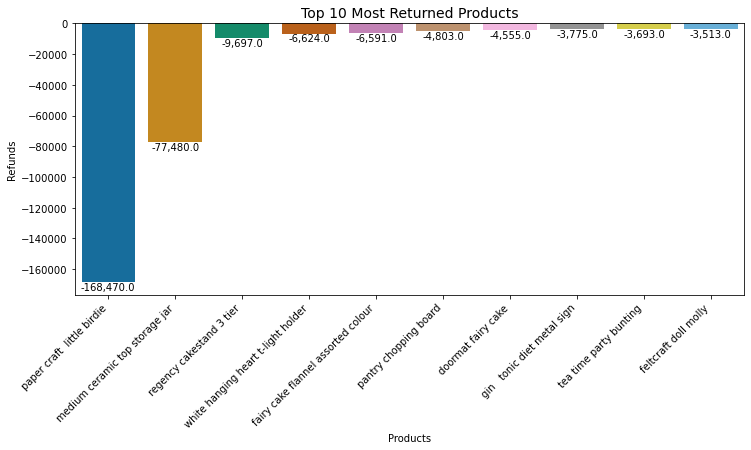

In [182]:
plt.figure(figsize=(12, 5))

ax = (sns.barplot(data = top_cancelled_rev,x='description', y='refunds',palette = 'colorblind'))
plt.xlabel('Products')
plt.ylabel('Refunds')
plt.title('Top 10 Most Returned Products',size = 14)
plt.xticks(rotation=45,ha='right')

for i in ax.containers:
    ax.bar_label(i,labels=[format(round(value,0), ',') for value in i.datavalues])
plt.show()




Among the most returned products, there are two items that cause significantly higher revenue loss compared to the others: 'paper craft little birdie' and 'medium ceramic top storage jar.' The remaining products have a considerably smaller impact on revenue. It is crucial to investigate the reasons behind the high return rates for these top products, as the lost revenue from these two items is even greater than that of our best-selling product. Now, let's compare the most profitable and most returned products to better understand their impact on our overall revenue.

In [183]:
top_bought_rev = (df_product
         .groupby('description')
         .agg({'quantity':'sum','revenue':'sum'})
         .reset_index()
         .sort_values('revenue', ascending=False)
         .head(10))
top_bought_rev

description  quantity    revenue
2824            regency cakestand 3 tier     13299  167917.74
3810  white hanging heart t-light holder     35283   99571.17
2388                       party bunting     17954   98016.68
1793             jumbo bag red retrospot     46390   90647.23
2711                  rabbit night light     30673   66732.75
2358       paper chain kit 50s christmas     18721   63321.99
214        assorted colour bird ornament     36245   58729.89
728                        chilli lights     10213   53692.61
3429                      spotty bunting      8317   42498.63
378             black record cover frame     11627   40543.38

In [184]:
bought_cancelled_match = pd.merge(top_bought_rev,top_cancelled_rev,
                                 on = 'description',
                                 how = 'outer', 
                                 suffixes=('_bought', '_returned'))
bought_cancelled_match

description  quantity_bought    revenue  \
0             regency cakestand 3 tier          13299.0  167917.74   
1   white hanging heart t-light holder          35283.0   99571.17   
2                        party bunting          17954.0   98016.68   
3              jumbo bag red retrospot          46390.0   90647.23   
4                   rabbit night light          30673.0   66732.75   
5        paper chain kit 50s christmas          18721.0   63321.99   
6        assorted colour bird ornament          36245.0   58729.89   
7                        chilli lights          10213.0   53692.61   
8                       spotty bunting           8317.0   42498.63   
9             black record cover frame          11627.0   40543.38   
10          paper craft  little birdie              NaN        NaN   
11      medium ceramic top storage jar              NaN        NaN   
12  fairy cake flannel assorted colour              NaN        NaN   
13               pantry chopping board              NaN        NaN   
14                  doormat fairy cake              NaN        NaN   
15         gin   tonic diet metal sign              NaN        NaN   
16              tea time party bunting              NaN        NaN   
17                feltcraft doll molly              NaN        NaN   

    quantity_returned    refunds  
0               855.0   -9697.05  
1              2578.0   -6624.30  
2                 NaN        NaN  
3                 NaN        NaN  
4                 NaN        NaN  
5                 NaN        NaN  
6                 NaN        NaN  
7                 NaN        NaN  
8                 NaN        NaN  
9                 NaN        NaN  
10            80995.0 -168469.60  
11            74494.0  -77479.64  
12             3150.0   -6591.42  
13              946.0   -4803.06  
14              674.0   -4554.90  
15             2030.0   -3775.33  
16             1424.0   -3692.95  
17             1447.0   -3512.65

In [185]:
refund_share=((cancelled_invoice
    .query('description not in ["paper craft little birdie", "medium ceramic top storage jar"]')['refunds']
    .sum())
/
(df_product['revenue'].sum())
*100)

print(f"Share of total refunds in total revenue: {refund_share:.2f}")  


Share of total refunds in total revenue: -4.06


As previously mentioned, 'paper craft little birdie' and 'medium ceramic top storage jar' would have been our most profitable products if their purchases hadn't been cancelled. For the remaining products, the under-received revenue is not comparable to the numbers of our most profitable products. This is evident from the fact that there are only two intersecting products, and the total refunds amount (excluding 'paper craft little birdie' and 'medium ceramic top storage jar') represents an insignificant share of 4% in the total revenue value.

Let's have a look at general statistics to find some patterns and possible reason for return.

In [186]:
def returned_statistics(df, top_cancelled):
    for item in top_cancelled['description']:
        print(f'Statistics for returned item: "{item}"')
        item_data = df[df['description'] == item]
        
        total_customers = item_data['customer_id'].nunique()
        total_invoices = item_data['invoice_no'].nunique()
        total_quantity = item_data['quantity'].sum()
        total_refunds = item_data['refunds'].sum()
        max_quantity = item_data['quantity'].max()
        avg_unit_price = item_data['unit_price'].mean()
        median_unit_price = item_data['unit_price'].median()
        
        print('')
        print(f"Total customers: {total_customers}")
        print(f"Total invoices: {total_invoices}")
        print(f"Total refunds: {total_refunds:.2f}")
        print(f"Total quantity: {total_quantity}")
        print(f"Maximum quantity: {max_quantity}")
        print(f"Average unit price: {avg_unit_price:.2f}")
        print(f"Median unit price: {median_unit_price:.2f}")
        print('-'*50)
        print('')

        
returned_statistics (cancelled_invoice, top_cancelled_rev)

Statistics for returned item: "paper craft  little birdie"

Total customers: 1
Total invoices: 1
Total refunds: -168469.60
Total quantity: 80995
Maximum quantity: 80995
Average unit price: 2.08
Median unit price: 2.08
--------------------------------------------------

Statistics for returned item: "medium ceramic top storage jar"

Total customers: 10
Total invoices: 10
Total refunds: -77479.64
Total quantity: 74494
Maximum quantity: 74215
Average unit price: 1.17
Median unit price: 1.25
--------------------------------------------------

Statistics for returned item: "regency cakestand 3 tier"

Total customers: 116
Total invoices: 180
Total refunds: -9697.05
Total quantity: 855
Maximum quantity: 150
Average unit price: 11.98
Median unit price: 12.75
--------------------------------------------------

Statistics for returned item: "white hanging heart t-light holder"

Total customers: 39
Total invoices: 42
Total refunds: -6624.30
Total quantity: 2578
Maximum quantity: 1930
Average unit

The first thing that draws attention is that the refunds for the most returned items is secured by only one transaction for 'craft little birdie' and few small transactions and one huge transaction for 'medium ceramic top storage jar'. Due the enormous items' quantities we can most likely consider these transaction as customers mistakes. And thus their returns are corrections of these mistakes. It appears to have nothing to do with product itself or its characteristics.

The same situation with 'tea time party bunting','gin tonic diet metal sign','doormat fairy cake' and 'fairy cake flannel assorted colour' in terms of having one transaction secured almost all returned quantity with only difference that the quantities are not that enormous as for 'craft little birdie' and 'medium ceramic top storage jar'. Thus we can be 100% sure that the error was reason behind decision to return.

Regardless, we don't have enough data to investigate the reasons behind customers' decisions to return previously purchased products. We suggest that customer success managers or marketers conduct a survey or directly ask customers for the reasons behind their returns.

## Revenue Over Time/Seasonality

To optimize our inventory levels, we need to synchronize our stock management with fluctuations in product demand. Therefore, it's worth investigating how sales have changed over a given period in the past to use it as the foundation for inventory management in the upcoming year. At this step, we will study the overall fluctuations. Later, when we conduct RFM segmentation, we will perform additional demand investigations using multiple analytical cuts.

Preparing data for investigation of daily and monthly fluctuations

In [187]:
daily_sales = (df_product
                 .groupby(df_product['invoice_date'].dt.date)
                 .agg({'revenue':'sum','quantity':'sum'})
                 .reset_index())
daily_sales.head()

invoice_date   revenue  quantity
0   2018-11-29  57030.54     26525
1   2018-11-30  47307.22     31130
2   2018-12-01  44228.43     16021
3   2018-12-03  30594.84     16068
4   2018-12-04  51187.52     21334

In [188]:
month_year_sales = (df_product
                        .groupby(['invoice_month_dt','invoice_month_year'])
                        .agg({'revenue':'sum','quantity':'sum'})
                        .reset_index()
                        .sort_values('invoice_month_dt'))
month_year_sales.head()

invoice_month_dt invoice_month_year    revenue  quantity
0       2018-11-01     November, 2018  104337.76     57655
1       2018-12-01     December, 2018  660209.59    295279
2       2019-01-01      January, 2019  611887.69    325651
3       2019-02-01     February, 2019  495057.82    275586
4       2019-03-01        March, 2019  660875.47    368673

Function to automate plotting line charts.

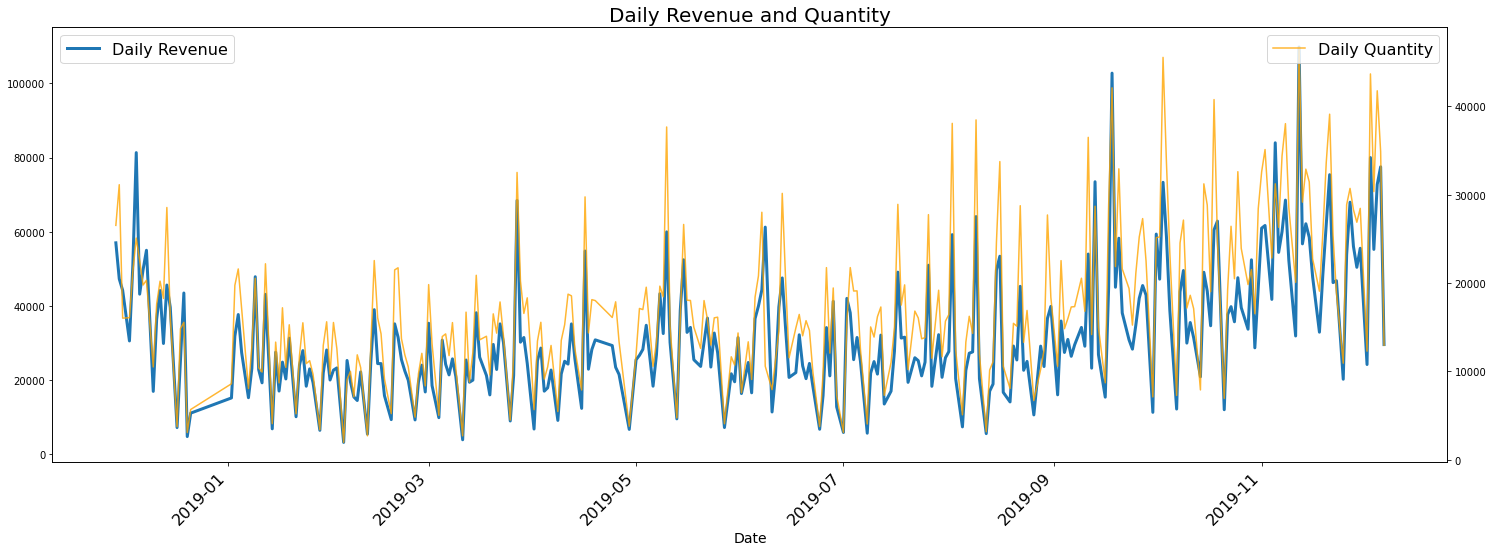

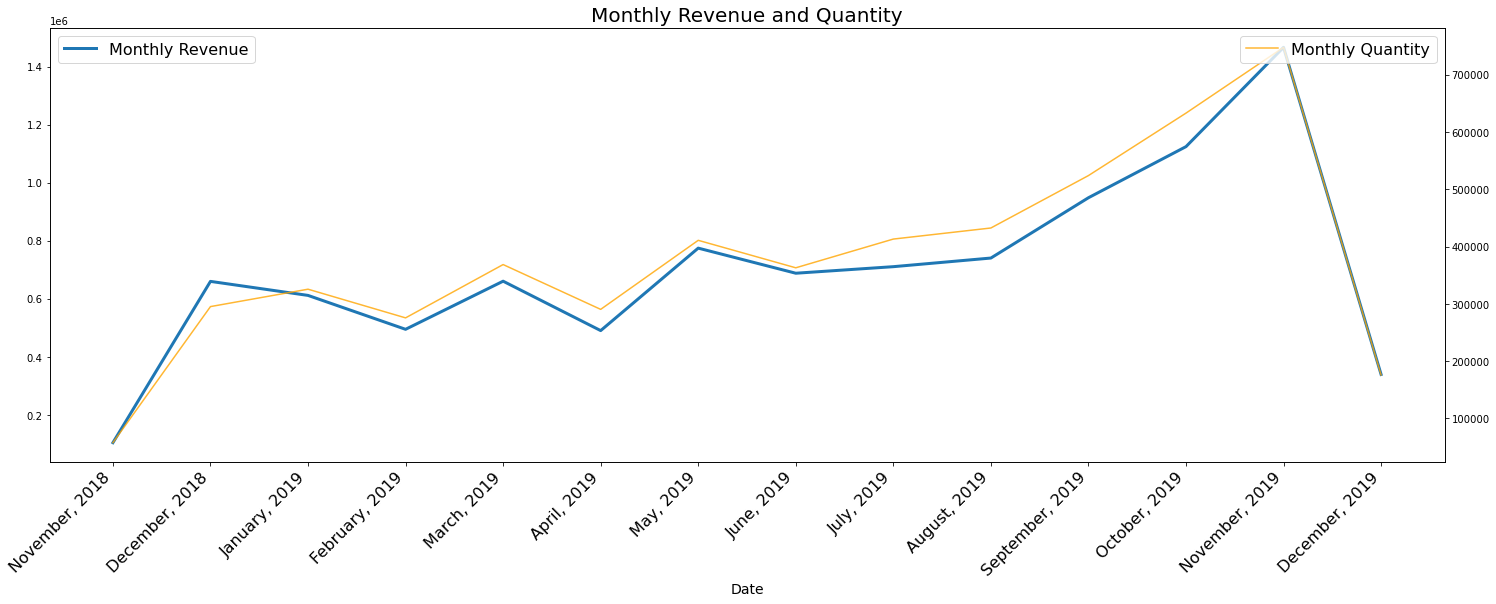

In [189]:
def line_plots (df, x_col, y1_col, y1_label, y2_col, y2_label, title):   
    fig, ax1 = plt.subplots(figsize=(25, 8))
    ax1.plot(df[x_col], df[y1_col], label=y1_label, linewidth=3.0)
    ax1.set_xlabel('Date', size=14)
    plt.xticks(size=16, rotation = 45, ha = 'right')

    ax2 = ax1.twinx()
    ax2.plot(df[x_col], df[y2_col], label=y2_label, color='orange', alpha=0.8, linewidth=1.5)

    ax1.legend(loc='upper left', fontsize = 16)
    ax2.legend(loc='upper right', fontsize = 16)
    plt.xticks(size=16, rotation = 45)
    plt.title(title, size=20)
    plt.show()

# Daily revenue and quantity    
line_plots(daily_sales,
            'invoice_date', 
            'revenue', 'Daily Revenue',
            'quantity', 'Daily Quantity', 
            'Daily Revenue and Quantity')

# Monthly revenue and quantity    
line_plots(month_year_sales,
            'invoice_month_year', 
            'revenue', 'Monthly Revenue',
            'quantity', 'Monthly Quantity', 
            'Monthly Revenue and Quantity')

In [190]:
correlation_coef = np.corrcoef(month_year_sales['revenue'],month_year_sales['quantity'])[0,1]
print(f'Correlation between revenue and quantity: {correlation_coef:.2f}')

Correlation between revenue and quantity: 0.99


Our first insight is that there is a almost 100% (correlation coeficient is 0.99) correlation between fluctuations in revenue and quantity sold. Every peak and drop in revenue coincides with a corresponding peak or drop in quantity sold. 

Secondly, we have observed that daily fluctuations are too noisy for further investigation, so we will be relying on monthly dynamics. Throughout most of the given time range, monthly revenue and quantity sold remained stable with fluctuations around 600,000 and 350,000, respectively. However, towards the end of 2019, these numbers steadily increased. This could be attributed to the holiday season with additional effect of our store gaining popularity over time. As we don't the same level of revenue in November-December of 2018.

Regarding the drop in December 2019, it can be explained simply - our sales data ends on December 7, 2019, meaning we do not yet have the full picture for that month's sales

Our next step is to check how sales varies along week and calendar year, it will help us to determine if we have seasonality in demand.

In [191]:
per_month_sales = (df_product
               .groupby('invoice_month')
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_month'))
per_month_sales['month_name'] = per_month_sales['invoice_month'].apply(lambda x: calendar.month_name[x])
per_month_sales.head()

invoice_month     revenue  quantity month_name
0              1  611887.690    325651    January
1              2  495057.820    275586   February
2              3  660875.470    368673      March
3              4  490620.611    290441      April
4              5  774814.810    410990        May

In [192]:
per_weekday_sales = (df_product.groupby('invoice_weekday')
                 .agg({'revenue':'sum', 'quantity':'sum'})
                 .reset_index()
                 .sort_values('invoice_weekday'))
per_weekday_sales['weekday_name'] = per_weekday_sales['invoice_weekday'].apply(lambda x: calendar.day_name[x])
per_weekday_sales

invoice_weekday      revenue  quantity weekday_name
0                0   787861.611    456898       Monday
1                1  1656409.150    853651      Tuesday
2                2  1967263.701   1019103    Wednesday
3                3  1751907.820   1009221     Thursday
4                4  2091725.690   1184361       Friday
5                5  1561618.411    790644     Saturday

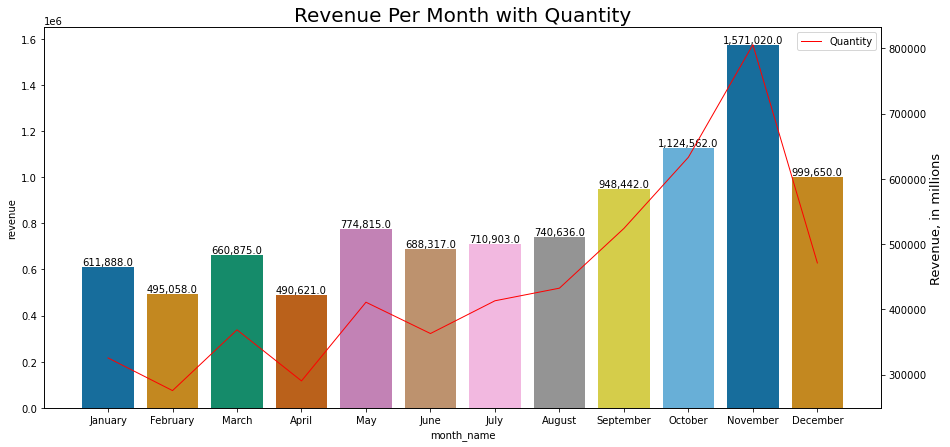

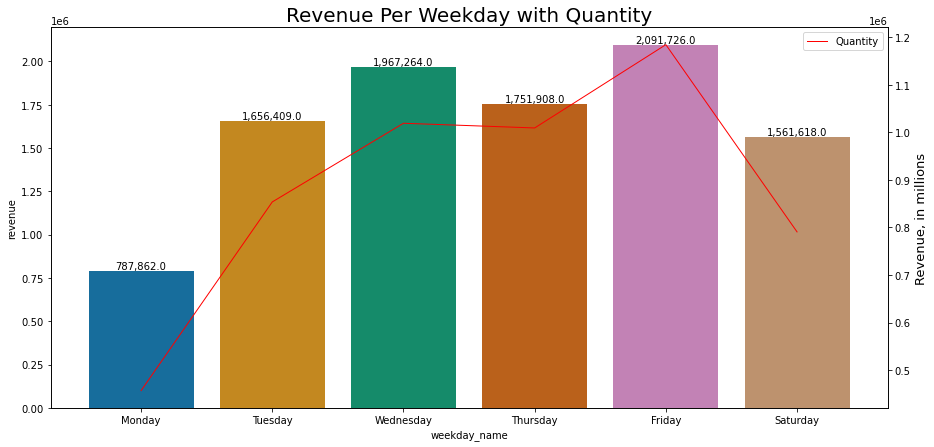

In [193]:
def bar_plots(df, x_col, x_label, title):
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(data=df, x=x_col, y='revenue', palette='colorblind')
    
    ax2 = ax.twinx()
    ax2.plot(df[x_col], df['quantity'], color='red', linewidth=1, label = 'Quantity')
    
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel('Revenue, in millions', fontsize=13)
    plt.xticks(size=13)
    plt.title(title, fontsize=20)
    
    for i in ax.containers:
        ax.bar_label(i, labels=[format(round(value, 0), ',') for value in i.datavalues])
    
    ax2.legend()
    plt.show()
    
bar_plots(per_month_sales,
            'month_name', 'Months',
            'Revenue Per Month with Quantity')  

bar_plots(per_weekday_sales,
            'weekday_name', 'Weekdays',
            'Revenue Per Weekday with Quantity')
    


Revenue per calendar month explicitly tell us that pre holiday season is a golden time for us, even though we don't have full sales on data for December 2019 it was enough to reach the revenue level higher then in other monthers, not noting November which is the most important month for us - as it is our best selling month so far.

The revenue per calendar month analysis shows that the pre-holiday season is a golden time for us. Even though we do not have full sales data for December 2019, it was still enough to reach a revenue level higher than in other months. And November is the most important month for us, as it has been our best-selling month so far. Actually it could be not only due New Year/Christman preparations but due Thanksgiving as well (in case if we have substantional share of users form US).

As for the weekdays we see that Monday is the least popular day, while Friday being the most popular day. Interesting to note that we don't have sales data for Sundays, which tells us that our store doesn't work on Sundays.

Now the same investigation but by product and customer categories.

In [194]:
month_year_sales_prod_cat = (df_product
                 .groupby(['invoice_month_year','invoice_month_dt','category'])
                 .agg({'revenue':'sum','quantity':'sum'})
                 .reset_index()
                .sort_values('invoice_month_dt'))
month_year_sales_prod_cat.head()

invoice_month_year invoice_month_dt            category   revenue  \
105     November, 2018       2018-11-01      kitchen_dining  20747.48   
102     November, 2018       2018-11-01  games_hobbies_kids   8382.28   
106     November, 2018       2018-11-01               other  10604.46   
107     November, 2018       2018-11-01       personal_care   8805.82   
108     November, 2018       2018-11-01          stationery   2449.10   

     quantity  
105      9854  
102      7908  
106      5344  
107      4689  
108      2345

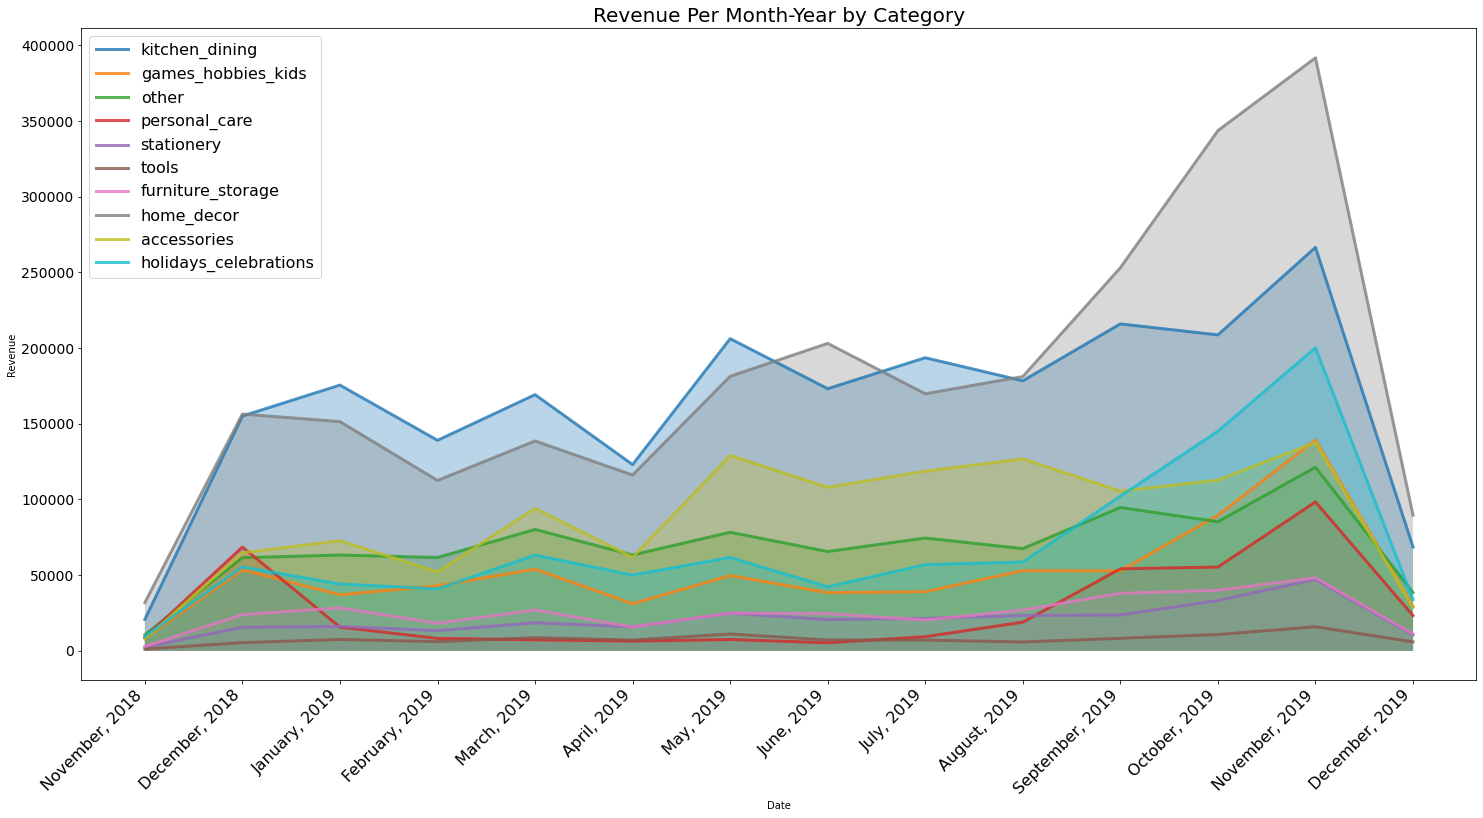

In [195]:
month_year_sales_prod_cat['revenue_cumulative'] = (month_year_sales_prod_cat
                                                   .groupby(['invoice_month_year', 'category'])['revenue']
                                                   .transform('cumsum'))

categories = month_year_sales_prod_cat['category'].unique()
plt.figure(figsize=(25, 12))
ax = plt.subplot(111)
for cat in categories:
    cat_data = month_year_sales_prod_cat[month_year_sales_prod_cat['category'] == cat]
    ax.plot(cat_data['invoice_month_year'], cat_data['revenue_cumulative'], linewidth=3.0, alpha=0.8, label=cat)
    ax.fill_between(cat_data['invoice_month_year'], cat_data['revenue_cumulative'], alpha=0.3)
plt.xlabel('Date')
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Revenue')
plt.title('Revenue Per Month-Year by Category', size=20)
plt.legend(fontsize=16)
plt.show()

From the chart above we can conclude that holiday season is not equally important to each product category, the main "beneficiary" are 'home_decor' (it helped this category to take the lead in a competition with 'kitchen_dining'), 'holidays_celebrations' and 'games_hobbies_kids'. For categories 'accessories', 'tools', 'stationery' demand remains the same. For the rest of categories increase was insignificant.     

In [196]:
month_year_sales_cust_cat = (df_product
                 .groupby(['invoice_month_year','invoice_month_dt','customer_category'])
                 .agg({'revenue':'sum','quantity':'sum'})
                 .reset_index()
                .sort_values('invoice_month_dt'))
month_year_sales_cust_cat.head()

invoice_month_year invoice_month_dt customer_category    revenue  quantity
32     November, 2018       2018-11-01           unknown   11827.19      2887
31     November, 2018       2018-11-01        individual   39702.38     24709
30     November, 2018       2018-11-01         corporate   52808.19     30059
8      December, 2018       2018-12-01           unknown  198330.54     43909
6      December, 2018       2018-12-01         corporate  274186.68    150866

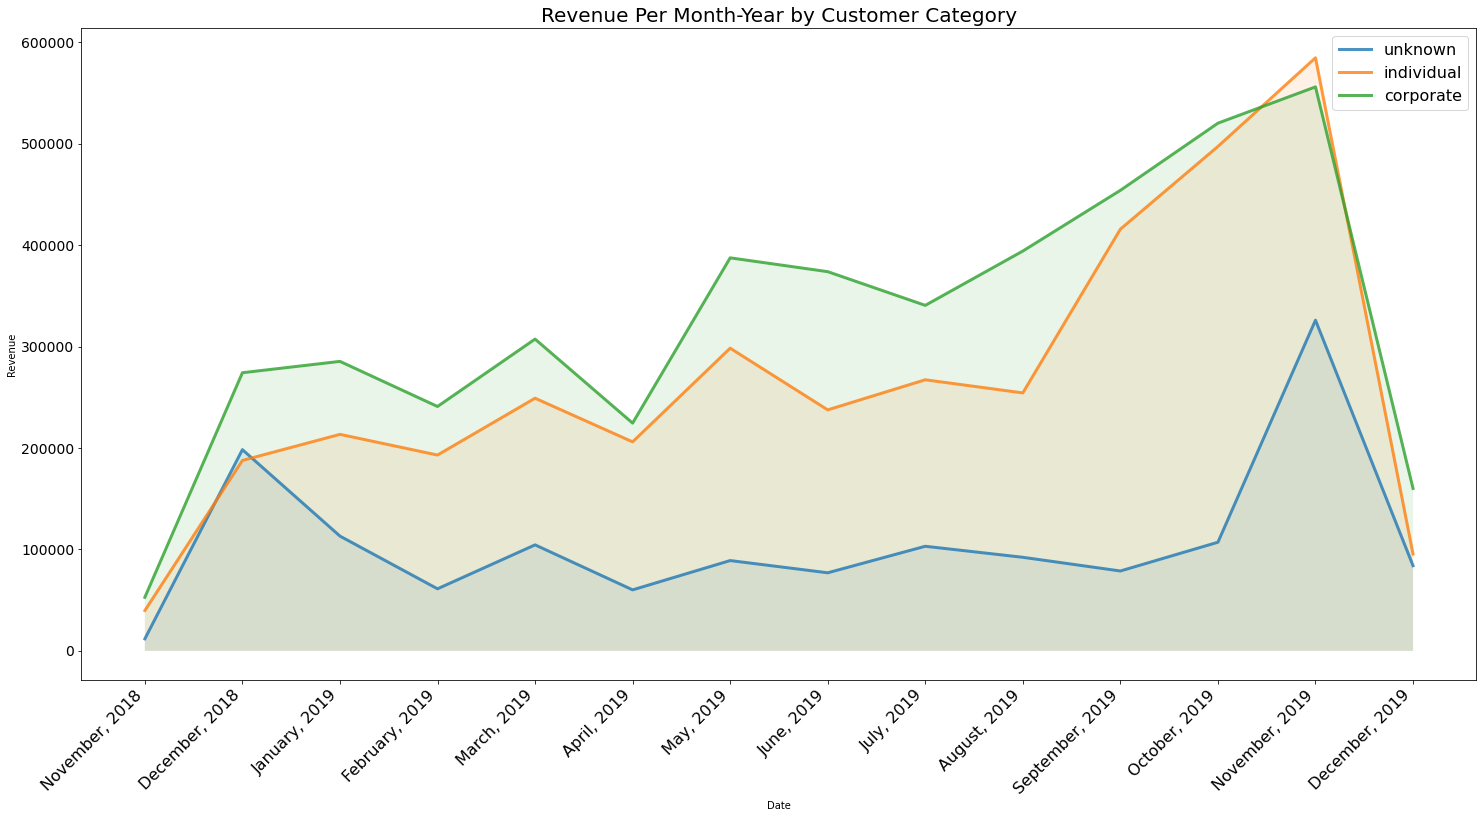

In [197]:
month_year_sales_cust_cat['revenue_cumulative'] = (month_year_sales_cust_cat
                                                   .groupby(['invoice_month_year', 'customer_category'])['revenue']
                                                   .transform('cumsum'))

categories = month_year_sales_cust_cat['customer_category'].unique()
plt.figure(figsize=(25, 12))
ax = plt.subplot(111)
for cat in categories:
    cat_data = month_year_sales_cust_cat[month_year_sales_cust_cat['customer_category'] == cat]
    ax.plot(cat_data['invoice_month_year'], cat_data['revenue_cumulative'], linewidth=3.0, alpha=0.8, label=cat)
    ax.fill_between(cat_data['invoice_month_year'], cat_data['revenue_cumulative'], alpha=0.1)
plt.xlabel('Date')
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Revenue')
plt.title('Revenue Per Month-Year by Customer Category', size=20)
plt.legend(fontsize=16)
plt.show()


Here we again see the significance of the holiday season, but this time the impact is almost equal to all categories. With only difference that we encountered the increase in demand among corporate users since July, 2019. It is must be some other factors explaining it, not early preparation for holidays.

In [198]:
month_sales_cat = (df_product
               .groupby(['invoice_month','category'])
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_month'))
month_sales_cat['invoice_month'] = month_sales_cat['invoice_month'].apply(lambda x: calendar.month_name[x])


In [199]:
month_sales_cust_cat = (df_product
               .groupby(['invoice_month','customer_category'])
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_month'))

month_sales_cust_cat['invoice_month'] = month_sales_cust_cat['invoice_month'].apply(lambda x: calendar.month_name[x])
month_sales_cust_cat.head()

invoice_month customer_category    revenue  quantity
0       January         corporate  285362.28    165930
1       January        individual  213415.34    119610
2       January           unknown  113110.07     40111
3      February         corporate  240888.27    151516
4      February        individual  193025.09    107811

/Users/misharimer/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/misharimer/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


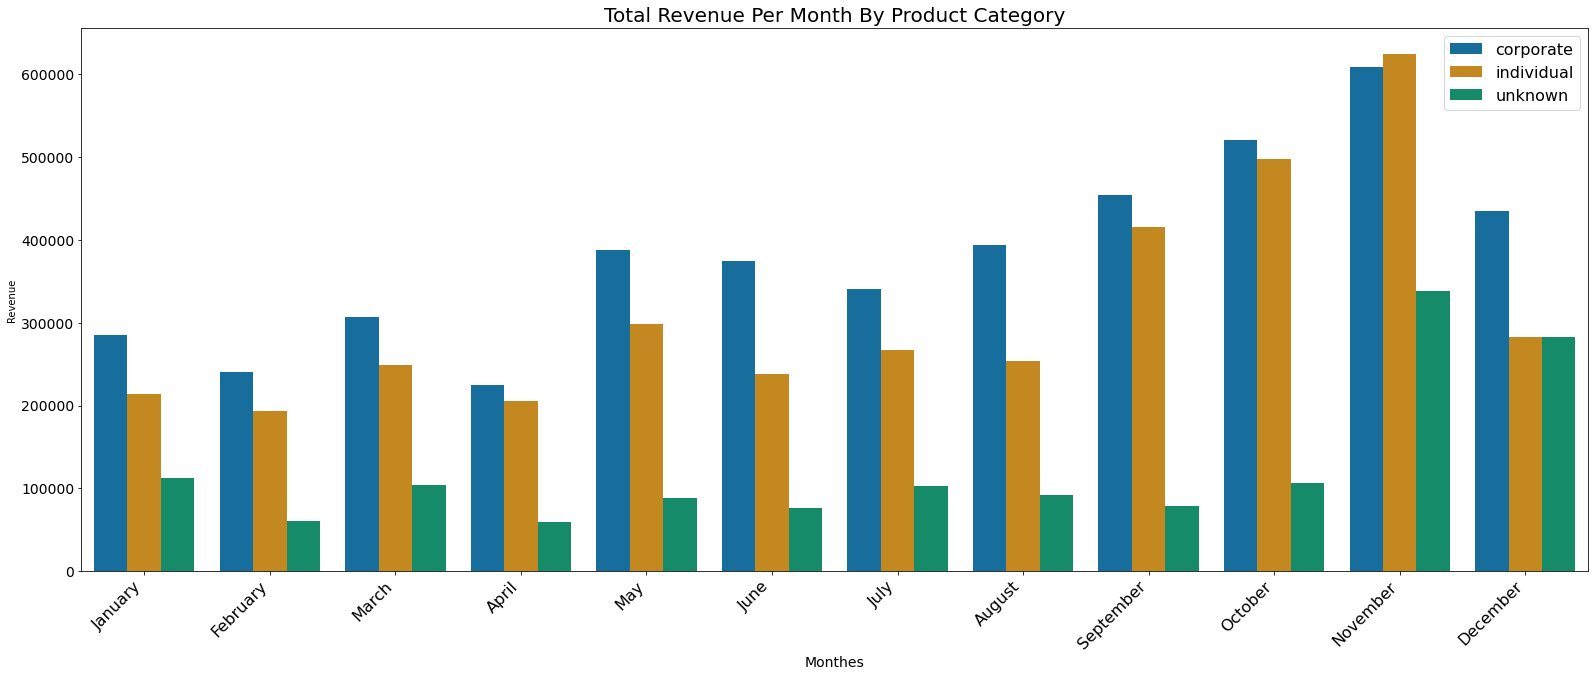

In [200]:
plt.figure(figsize=(27, 10))
sns.barplot(x='invoice_month', y='revenue', hue='customer_category', data=month_sales_cust_cat,palette = 'colorblind')
plt.xlabel('Monthes', size = 14)
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 14)
plt.ylabel('Revenue')
plt.title('Total Revenue Per Month By Product Category', size=20)
plt.legend(fontsize = 16)
plt.show()

Here we can see that starting from August, the demand from individual customers significantly increased, and the pace of growth is higher compared to corporate customers. The rest conclusion regarding the seasonality remains the same.

In [201]:
weekday_sales_cat = (df_product
               .groupby(['invoice_weekday','category'])
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_weekday'))

weekday_sales_cat['invoice_weekday'] = weekday_sales_cat['invoice_weekday'].apply(lambda x: calendar.day_name[x])
weekday_sales_cat.head()

invoice_weekday               category     revenue  quantity
0          Monday            accessories   87358.820     47961
1          Monday      furniture_storage   32535.140     14270
2          Monday     games_hobbies_kids   52049.500     29241
3          Monday  holidays_celebrations   82173.820     57453
4          Monday             home_decor  210191.371    110801

/Users/misharimer/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/misharimer/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


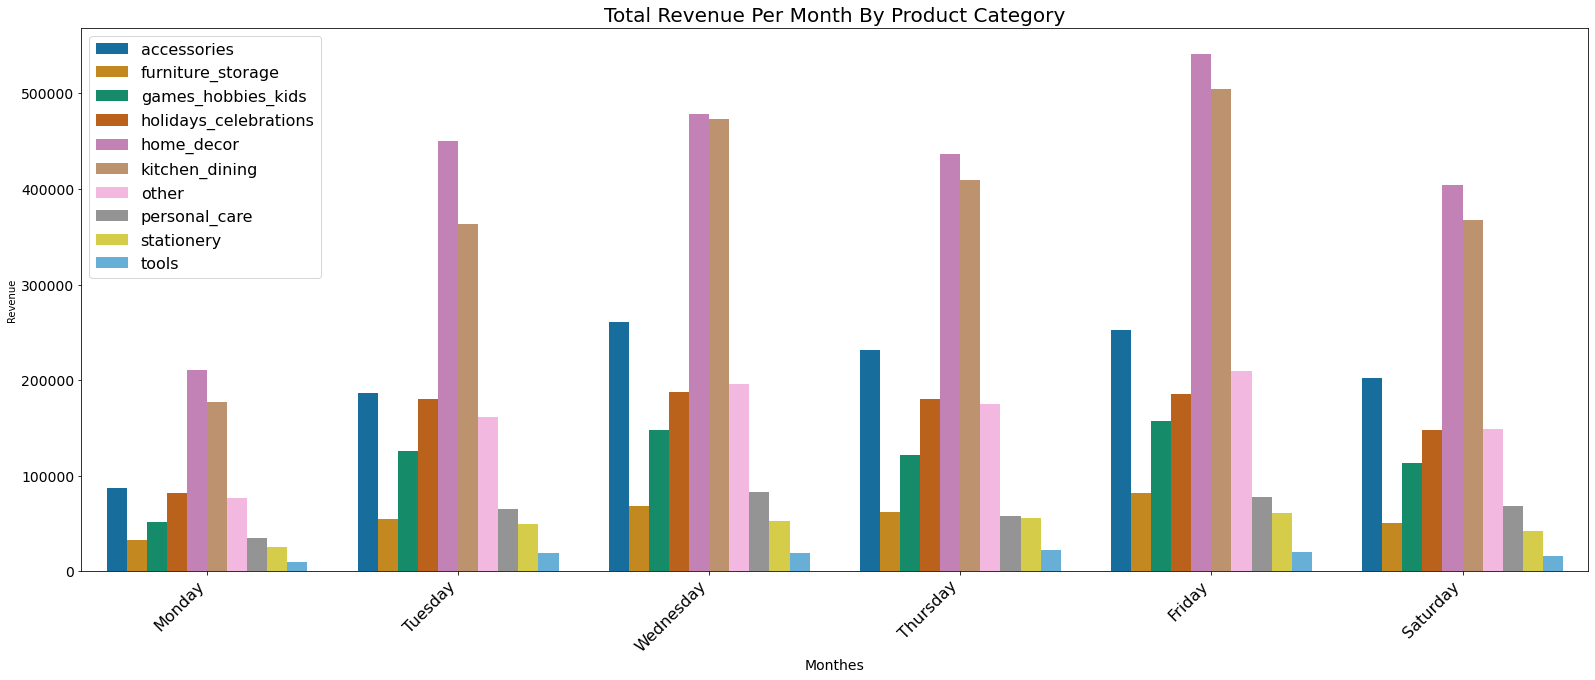

In [202]:
plt.figure(figsize=(27, 10))
sns.barplot(x='invoice_weekday', y='revenue', hue='category', data=weekday_sales_cat,palette = 'colorblind')
plt.xlabel('Monthes', size = 14)
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 14)
plt.ylabel('Revenue')
plt.title('Total Revenue Per Month By Product Category', size=20)
plt.legend(fontsize = 16)
plt.show()

During the weekdays proportions in demand for certain categories remains more or less the same.

In [203]:
weekday_sales_cust_cat = (df_product
               .groupby(['invoice_weekday','customer_category'])
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_weekday'))

weekday_sales_cust_cat['invoice_weekday'] = weekday_sales_cust_cat['invoice_weekday'].apply(lambda x: calendar.day_name[x])
weekday_sales_cust_cat.head()

invoice_weekday customer_category     revenue  quantity
0          Monday         corporate  285972.560    167703
1          Monday        individual  483362.991    284685
2          Monday           unknown   18526.060      4510
3         Tuesday         corporate  719004.790    404556
4         Tuesday        individual  582914.440    346374

/Users/misharimer/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/misharimer/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


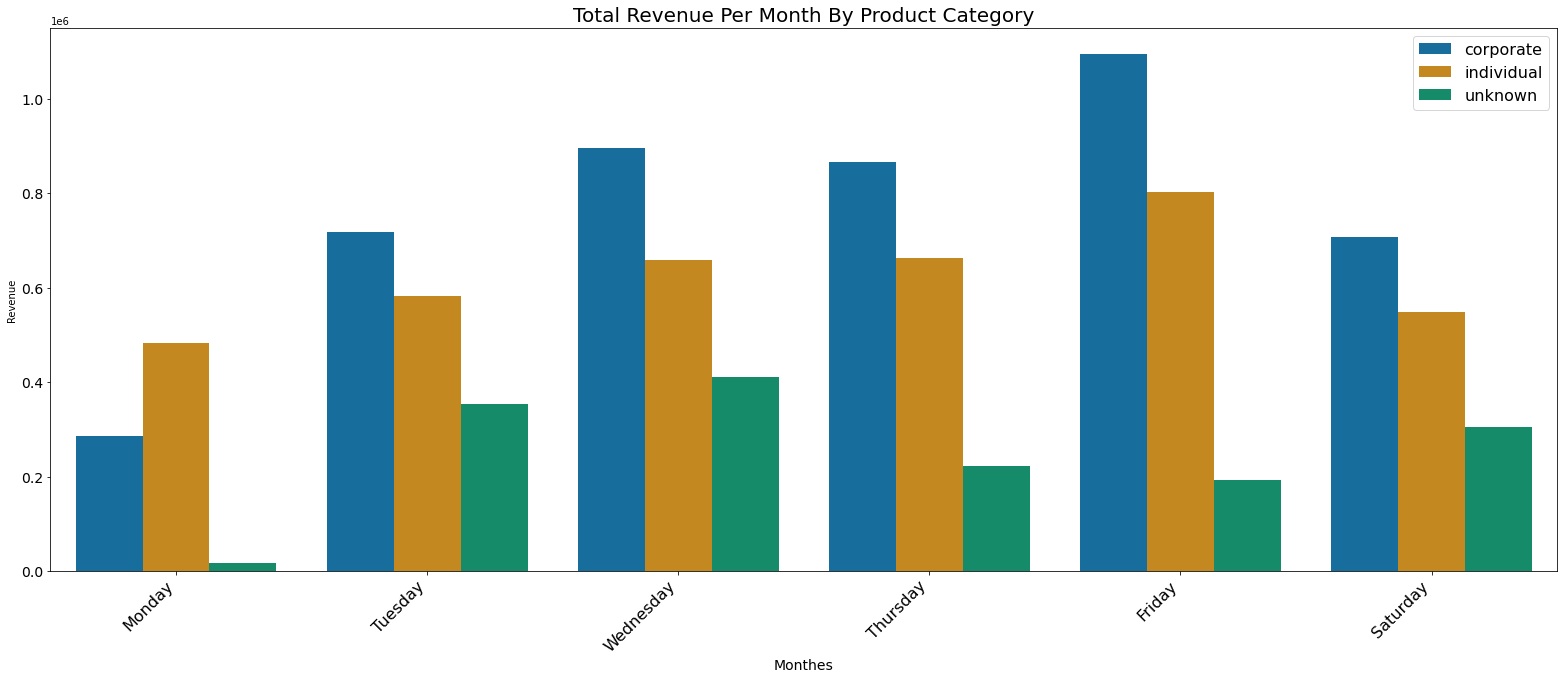

In [204]:
plt.figure(figsize=(27, 10))
sns.barplot(x='invoice_weekday', y='revenue', hue='customer_category', data=weekday_sales_cust_cat,palette = 'colorblind')
plt.xlabel('Monthes', size = 14)
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 14)
plt.ylabel('Revenue')
plt.title('Total Revenue Per Month By Product Category', size=20)
plt.legend(fontsize = 16)
plt.show()

Only Mondays stand out when it comes to customer category comparision: it is the only day when individual customers brings us more revenue than corporate ones. 

# Apriori Basket Analysis

To optimize our product range identifying products that are frequently bought together can be also valuable. The technique we are going to use for this purpose is called Basket Analysis. To automate this process, we will employ the Apriori algorithm, which can efficiently help us discover frequent itemsets and generate association rules. The aim of the Apriori basket analysis is to identify commonly occurring combinations of products that are purchased together in the same invoice.

The first step is to group the data by invoice number and creating a list of products bought in each invoice

In [205]:
invoices_products_list = df_product.groupby('invoice_no')['description'].apply(list)
invoices_products_list.head()

invoice_no
536365    [white hanging heart t-light holder, white met...
536366    [hand warmer union jack, hand warmer red polka...
536367    [assorted colour bird ornament, poppys playhou...
536368    [jam making set with jars, red coat rack paris...
536369                           [bath building block word]
Name: description, dtype: object

Converting the data to a format that can be used by the Apriori algorithm

In [206]:
te = TransactionEncoder()
te_data = te.fit_transform(invoices_products_list)

Creating a dataframe from the transformed data

In [207]:
summary_products = pd.DataFrame(te_data, columns=te.columns_)
summary_products.head()

10 colour spaceboy pen  12 coloured party balloons  \
0                   False                       False   
1                   False                       False   
2                   False                       False   
3                   False                       False   
4                   False                       False   

   12 daisy pegs in wood box  12 egg house painted wood  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   12 hanging eggs hand painted  12 ivory rose peg place settings  \
0                         False                             False   
1                         False                             False   
2                         False                             False   
3                         False                             False   
4                         False                             False   

   12 message cards with envelopes  12 pencil small tube woodland  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   

   12 pencils small tube red retrospot  12 pencils small tube skull  \
0                                False                        False   
1                                False                        False   
2                                False                        False   
3                                False                        False   
4                                False                        False   

   12 pencils tall tube posy  12 pencils tall tube red retrospot  \
0                      False                               False   
1                      False                               False   
2                      False                               False   
3                      False                               False   
4                      False                               False   

   12 pencils tall tube skulls  12 pencils tall tube woodland  \
0                        False                          False   
1                        False                          False   
2                        False                          False   
3                        False                          False   
4                        False                          False   

   12 pink hen chicks in basket  12 pink rose peg place settings  \
0                         False                            False   
1                         False                            False   
2                         False                            False   
3                         False                            False   
4                         False                            False   

   12 red rose peg place settings  15 pink fluffy chicks in box  \
0                           False                         False   
1                           False                         False   
2                           False                         False   
3                           False                         False   
4                           False                         False   

   15cm christmas glass ball 20 lights  16 pc cutlery set pantry design  \
0                                False                            False   
1                                False                            False   
2                                False                            False   
3                                False                            False   
4                                False                       

Applying  Apriori algorithm to generate a list of frequent itemsets.Setting 2,5% as the minimum support threshold. Which means only itemsets (both antecedents and consequents) that appear in at least 2.5% of transactions will be considered frequent.

In [208]:
frequent_itemsets = apriori(summary_products, min_support=0.025, use_colnames=True)
frequent_itemsets.sort_values('support', ascending=False).head()

support                              itemsets
179  0.113823  (white hanging heart t-light holder)
70   0.105416             (jumbo bag red retrospot)
138  0.098538            (regency cakestand 3 tier)
112  0.084934                       (party bunting)
91   0.078616             (lunch bag red retrospot)

Generating association rules from the frequet_itemsets. Association rules are a way to understand the relationships between items in a transactional dataset. They have the form 'if item A is bought, then item B is also likely to be bought'.  

We set the 'lift' as the parameter that specifies the measure used to evaluate importance of an association rule. 

'Lift' measures how much more likely item B is to be bought when item A is purchased, compared to when item A is not purchased. A lift value greater than 1 indicates a positive relationship between the items, while a value less than 1 indicates a negative relationship, and a value equal to 1 implies no relationship. As we are interested in defining pairing products we set the minimum threshold for this parameter to 1.

In [209]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

Now we are sorting the itemsets according to their share in transactions (support) and their dependence strenght (lift). 

In [210]:
rules = rules.sort_values(['support','lift'], ascending = [False, False])
rules.head(20)

antecedents                          consequents  \
23            (jumbo bag pink polkadot)            (jumbo bag red retrospot)   
22            (jumbo bag red retrospot)            (jumbo bag pink polkadot)   
14    (green regency teacup and saucer)    (roses regency teacup and saucer)   
15    (roses regency teacup and saucer)    (green regency teacup and saucer)   
34            (jumbo bag red retrospot)             (jumbo storage bag suki)   
35             (jumbo storage bag suki)            (jumbo bag red retrospot)   
32            (jumbo bag red retrospot)  (jumbo shopper vintage red paisley)   
33  (jumbo shopper vintage red paisley)            (jumbo bag red retrospot)   
0          (alarm clock bakelike green)           (alarm clock bakelike red)   
1            (alarm clock bakelike red)         (alarm clock bakelike green)   
44             (lunch bag  black skull)            (lunch bag red retrospot)   
45            (lunch bag red retrospot)             (lunch bag  black skull)   
10    (green regency teacup and saucer)     (pink regency teacup and saucer)   
11     (pink regency teacup and saucer)    (green regency teacup and saucer)   
54            (lunch bag red retrospot)            (lunch bag pink polkadot)   
55            (lunch bag pink polkadot)            (lunch bag red retrospot)   
64     (pink regency teacup and saucer)    (roses regency teacup and saucer)   
65    (roses regency teacup and saucer)     (pink regency teacup and saucer)   
18            (jumbo bag red retrospot)     (jumbo  bag baroque black white)   
19     (jumbo  bag baroque black white)            (jumbo bag red retrospot)   

    antecedent support  consequent support   support  confidence       lift  \
23            0.061497            0.105416  0.041372    0.672742   6.381785   
22            0.105416            0.061497  0.041372    0.392460   6.381785   
14            0.051052            0.053039  0.037958    0.743513  14.018184   
15            0.053039            0.051052  0.037958    0.715658  14.018184   
34            0.105416            0.059561  0.036124    0.342678   5.753408   
35            0.059561            0.105416  0.036124    0.606501   5.753408   
32            0.105416            0.059408  0.034188    0.324311   5.459054   
33            0.059408            0.105416  0.034188    0.575472   5.459054   
0             0.049167            0.053039  0.032302    0.656995  12.386971   
1             0.053039            0.049167  0.032302    0.609030  12.386971   
44            0.064095            0.078616  0.032201    0.502385   6.390347   
45            0.078616            0.064095  0.032201    0.409592   6.390347   
10            0.051052            0.038467  0.031589    0.618762  16.085366   
11            0.038467            0.051052  0.031589    0.821192  16.085366   
54            0.078616            0.055230  0.030519    0.388205   7.028870   
55            0.055230            0.078616  0.030519    0.552583   7.028870   
64            0.038467            0.053039  0.029245    0.760265  14.334024   
65            0.053039            0.038467  0.029245    0.551393  14.334024   
18            0.105416            0.047180  0.029245    0.277429   5.880230   
19            0.047180            0.105416  0.029245    0.619870   5.880230   

    leverage  conviction  zhangs_metric  
23  0.034889    2.733577       0.898563  
22  0.034889    1.544760       0.942677  
14  0.035250    3.692042       0.978625  
15  0.035250    3.337347       0.980678  
34  0.029845    1.430712       0.923547  
35  0.029845    2.273410       0.878515  
32  0.027925    1.392049       0.913070  
33  0.027925    2.107242       0.868408  
0   0.029695    2.760777       0.966805  
1   0.029695    2.431983       0.970758  
44  0.027162    1.851599       0.901282  
45  0.027162    1.585182       0.915486  
10  0.029625    2.522135       0.988286  
11  0.029625    5.307079       0.975351  
54  0.026177    1.544259       0.930915  
55  0.026177   

As a result of basket analysis we have identified several interesting product pairings. These pairs frequently appear together in customer invoices, which is worth to take into account for setting next year product range.

1) Jumbo Bags -   pairing products that have biggest combined share in overall transactions are Jumbo Bag Pink Polkadot and Jumbo Bag Red Retrospot, with a lift of 6.38 and support of 4,1% This indicates that these two products are bought together 6.38 times more often than expected if they were purchased independently. 

2) Regency Teacups and Saucers -  Green Regency Teacup and Saucer, Roses Regency Teacup and Saucer, and Pink Regency Teacup and Saucer also have high lift values and support. The pairs Green/Roses (lift: 14.02, support: 3,8%), Green/Pink (lift: 16.09, support: 3,2%), and Roses/Pink (lift: 14.33, support: 2,9%) are particularly strong.

3) Alarm Clocks -  Alarm Clock Bakelike Green and Alarm Clock Bakelike Red are frequently purchased together, with a lift of 12.39 and support of 3,2%. 

4) Lunch Bags - The Lunch Bag Black Skull, Lunch Bag Red Retrospot, and Lunch Bag Pink Polkadot often appear together in invoices, with lifts of 6.39, 7.03, and support values of 3,2%, 3,1% respectively. 

5) Jumbo Storage Bags - Jumbo Storage Bag Suki and Jumbo Bag Red Retrospot, and Jumbo Shopper Vintage Red Paisley and Jumbo Bag Red Retrospot pairs have lift values of 5.75 and 5.46, respectively, with supports of 3,6% and 3,4%. 

Given these strong associations we have withing the pairing products above, it is definetly worth keeping them in product range for the next year. We need to be ensured that they are adequately stocked. Moreoever these product could be promoted together or place in close proximity to each othere to encourage sales.

It is interesting to note that in the pairings above, the products are almost identical, with the only differences being in color, ornament, or style. It is not common for customers to buy different alarm clocks or jumbo bags at once, unless they are a business. Let's investigate whether there are different preferences among corporate customers and individual customers.

In [211]:
corporates = df_product.query('customer_category=="corporate"')
invoices_products_list2 = corporates.groupby('invoice_no')['description'].apply(list)
te = TransactionEncoder()
te_data2 = te.fit_transform(invoices_products_list2)
summary_products2 = pd.DataFrame(te_data2, columns=te.columns_)
frequent_itemsets2 = apriori(summary_products2, min_support=0.025, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2 = rules2.sort_values(['support','lift'], ascending = [False, False])
rules2.head(20)


antecedents                        consequents  \
14          (jumbo bag red retrospot)          (jumbo bag pink polkadot)   
15          (jumbo bag pink polkadot)          (jumbo bag red retrospot)   
1          (alarm clock bakelike red)       (alarm clock bakelike green)   
0        (alarm clock bakelike green)         (alarm clock bakelike red)   
42          (lunch bag red retrospot)          (lunch bag pink polkadot)   
43          (lunch bag pink polkadot)          (lunch bag red retrospot)   
32           (lunch bag  black skull)          (lunch bag red retrospot)   
33          (lunch bag red retrospot)           (lunch bag  black skull)   
10  (green regency teacup and saucer)  (roses regency teacup and saucer)   
11  (roses regency teacup and saucer)  (green regency teacup and saucer)   
18          (jumbo bag red retrospot)             (jumbo bag strawberry)   
19             (jumbo bag strawberry)          (jumbo bag red retrospot)   
44          (lunch bag red retrospot)        (lunch bag spaceboy design)   
45        (lunch bag spaceboy design)          (lunch bag red retrospot)   
25           (jumbo storage bag suki)          (jumbo bag red retrospot)   
24          (jumbo bag red retrospot)           (jumbo storage bag suki)   
27          (jumbo bag red retrospot)          (lunch bag red retrospot)   
26          (lunch bag red retrospot)          (jumbo bag red retrospot)   
47            (lunch bag suki design)          (lunch bag red retrospot)   
46          (lunch bag red retrospot)            (lunch bag suki design)   

    antecedent support  consequent support   support  confidence       lift  \
14            0.111430            0.064560  0.040822    0.366350   5.674565   
15            0.064560            0.111430  0.040822    0.632319   5.674565   
1             0.057907            0.055186  0.035833    0.618799  11.212976   
0             0.055186            0.057907  0.035833    0.649315  11.212976   
42            0.089809            0.059722  0.035228    0.392256   6.568052   
43            0.059722            0.089809  0.035228    0.589873   6.568052   
32            0.066828            0.089809  0.034624    0.518100   5.768873   
33            0.089809            0.066828  0.034624    0.385522   5.768873   
10            0.043090            0.048382  0.033565    0.778947  16.099868   
11            0.048382            0.043090  0.033565    0.693750  16.099868   
18            0.111430            0.048685  0.031902    0.286296   5.880622   
19            0.048685            0.111430  0.031902    0.655280   5.880622   
44            0.089809            0.060931  0.031751    0.353535   5.802191   
45            0.060931            0.089809  0.031751    0.521092   5.802191   
25            0.057000            0.111430  0.031600    0.554377   4.975098   
24            0.111430            0.057000  0.031600    0.283582   4.975098   
27            0.111430            0.089809  0.031448    0.282225   3.142488   
26            0.089809            0.111430  0.031448    0.350168   3.142488   
47            0.057605            0.089809  0.030844    0.535433   5.961876   
46            0.089809            0.057605  0.030844    0.343434   5.961876   

    leverage  conviction  zhangs_metric  
14  0.033629    1.476273       0.927080  
15  0.033629    2.416683       0.880628  
1   0.032637    2.478519       0.966803  
0   0.032637    2.686436       0.964018  
42  0.029865    1.547161       0.931396  
43  0.029865    2.219292       0.901593  
32  0.028622    1.888752       0.885856  
33  0.028622    1.518642       0.908223  
10  0.031480    4.304938       0.980122  
11  0.031480    3.124603       0.985572  
18  0.026477    1.332927       0.934029  
19  0.026477    2.577653       0.872424  
44  0.026279    1.452622       0.909317  
45  0.026279    1.900553       0.881353  
25  0.025248    1.993993       0.847295  
24  0.025248    1.316270       0.899197  
27  0.021441    1.268073       0.767279  
26  0.021441 

Among corporate customers we observe a more or less the similar choice as for the overall sales: jumbo bags, alarm clocks and lunch boxes. Now let's examine individual customers.

In [212]:
individuals = df_product.query('customer_category=="individual"')
invoices_products_list3 = individuals.groupby('invoice_no')['description'].apply(list)
te = TransactionEncoder()
te_data3 = te.fit_transform(invoices_products_list3)
summary_products3 = pd.DataFrame(te_data3, columns=te.columns_)
frequent_itemsets3 = apriori(summary_products3, min_support=0.025, use_colnames=True)
rules3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)
rules3 = rules3.sort_values(['support','lift'], ascending = [False, False])
rules3.head(20)

antecedents                           consequents  \
7  (white hanging heart t-light holder)    (red hanging heart t-light holder)   
6    (red hanging heart t-light holder)  (white hanging heart t-light holder)   
2               (heart of wicker small)               (heart of wicker large)   
3               (heart of wicker large)               (heart of wicker small)   
9          (wooden frame antique white)   (wooden picture frame white finish)   
8   (wooden picture frame white finish)          (wooden frame antique white)   
4   (paper chain kit vintage christmas)       (paper chain kit 50s christmas)   
5       (paper chain kit 50s christmas)   (paper chain kit vintage christmas)   
0     (green regency teacup and saucer)     (roses regency teacup and saucer)   
1     (roses regency teacup and saucer)     (green regency teacup and saucer)   

   antecedent support  consequent support   support  confidence       lift  \
7            0.112895            0.040865  0.027644    0.244867   5.992038   
6            0.040865            0.112895  0.027644    0.676471   5.992038   
2            0.062071            0.052885  0.027301    0.439834   8.316862   
3            0.052885            0.062071  0.027301    0.516234   8.316862   
9            0.044299            0.046875  0.025927    0.585271  12.485788   
8            0.046875            0.044299  0.025927    0.553114  12.485788   
4            0.040608            0.057606  0.025841    0.636364  11.046742   
5            0.057606            0.040608  0.025841    0.448584  11.046742   
0            0.033911            0.037689  0.025498    0.751899  19.950151   
1            0.037689            0.033911  0.025498    0.676538  19.950151   

   leverage  conviction  zhangs_metric  
7  0.023031    1.270153       0.939135  
6  0.023031    2.741961       0.868608  
2  0.024018    1.690776       0.937984  
3  0.024018    1.938807       0.928886  
9  0.023851    2.298189       0.962549  
8  0.023851    2.138576       0.965150  
4  0.023502    2.591582       0.947971  
5  0.023502    1.739871       0.965070  
0  0.024220    3.878703       0.983217  
1  0.024220    2.986711       0.987077

Here, the selection is significantly different, with items such as tea light holders, wicker hearts, and wooden frames. Furthermore, the products in pairings for individuals are not as similar: they tend to complement each other rather than simply being the same product in a different color.

# RFM analysis

To identify products that may be worth excluding from the product range for the upcoming year, it is beneficial to conduct segmentation based on factors such as revenue generation, purchase frequency, and purchase history. 

We are going to apply RFM analysis, which is typically used for customer segmentation. However, it can also be applied to product analysis. The results will assist us in determining which products to prioritize and focus on for the next year.

In the context of product analysis, RFM stands for:

- Recency: The time since the last sale of a particular product. It indicates how recently a product has been purchased;
- Frequency: The number of times a product has been sold. It represents the demand for a product;
- Monetary Value: The total revenue generated by a product. This metric reveals the financial impact of a product.

For recency we need to calculate the number of days since the last purchase. Thus we need to establish the current date. Regardless of the the actual date, I suggest using the day after the latest purchase as today for the purpose of our investigation.

In [213]:
current_date = df_product['invoice_date'].max() + timedelta(days=1)


Now we can calculate each of the RFM parametres

In [214]:
rfm_data = (df_product
                .groupby('description')
                .agg({
                    'invoice_date': lambda x: (current_date - x.max()).days,
                    'description': 'count',
                    'revenue': 'sum'})
                .rename(columns={'invoice_date': 'recency',
                   'description': 'frequency',
                   'revenue': 'monetary_value'}))

In [215]:
rfm_data.head()

recency  frequency  monetary_value
description                                                     
10 colour spaceboy pen              1        313         5454.55
12 coloured party balloons          3        165         1385.51
12 daisy pegs in wood box          55         81          592.62
12 egg house painted wood           1         99         2378.52
12 hanging eggs hand painted        2          8           83.20

Now we divide the values of each RFM metric into 4 equal quantiles, each quantile is assigned to a certain score. For frequency and monetary higher metric values recievs higher score. Conversly, for recency the lower the metric (meaning fewer  days have passed) the higher the score.

Starting with frequency and monetary

In [216]:
rfm_data['F'] = pd.qcut(rfm_data['frequency'], 4, labels=list(range(1, 5)))
rfm_data['M'] = pd.qcut(rfm_data['monetary_value'], 4, labels=list(range(1, 5)))

In [217]:
rfm_data.groupby('F')['frequency'].agg({'mean', 'count'})

count        mean
F                   
1   1022    5.847358
2    977   35.590583
3    997  107.677031
4    994  372.763581

In [218]:
rfm_data.groupby('F')['frequency'].agg(set)

F
1    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2    {16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...
3    {64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7...
4    {2089, 164, 165, 166, 167, 168, 169, 170, 172,...
Name: frequency, dtype: object

In [219]:
rfm_data.groupby('M')['monetary_value'].agg({'mean', 'count'})

count         mean
M                    
1    998    44.159031
2    997   353.324634
3    997  1254.675737
4    998  8185.911122

In [220]:
rfm_data.groupby('M')['monetary_value'].agg(set)

M
1    {1.25, 2.04, 3.5700000000000003, 4.56000000000...
2    {409.83, 410.15999999999997, 411.5599999999999...
3    {2053.3500000000004, 2065.65, 2065.04, 2067.15...
4    {8196.0, 14345.32, 6156.61, 8212.14, 4126.1799...
Name: monetary_value, dtype: object

Perfect split for monetary and almost perfect  one for frequency

In recency we have significant skewness in metric towards value equal to 1. We don't have enough unique values to form 4 equal quantiles using qcut, even after dropping duplicates.

In [221]:
rfm_data['recency'].value_counts()

1      1551
2       357
4       183
3       155
5        64
       ... 
161       1
73        1
315       1
165       1
356       1
Name: recency, Length: 305, dtype: int64

In [222]:
rfm_data['R'] = pd.qcut(rfm_data['recency'], 4,duplicates = 'drop', labels = False) + 1



In [223]:
rfm_data.groupby('R')['recency'].agg({'mean', 'count'})

count        mean
R                   
1   2063    1.323316
2    935   14.612834
3    992  184.221774

In [224]:
rfm_data.groupby('R')['recency'].agg(set)

R
1                                            {1, 2, 3}
2    {4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...
3    {41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5...
Name: recency, dtype: object

In order to have the same granularity for each metric let's do the split of recency into 4 metrics manually

In [225]:
def recency_rank (x):
    if x ==1:
        return 4
    elif x <=3:
        return 3
    elif x <=6:
        return 2
    elif x > 6:
        return 1

In [226]:
rfm_data['R'] = rfm_data['recency'].apply(recency_rank)

In [227]:
rfm_data.groupby('R')['recency'].agg({'mean', 'count'})


count        mean
R                   
1   1656  117.883454
2    271    4.413284
3    512    2.302734
4   1551    1.000000

It is a maximum accuracy that we can achieve here, so let's leave it as it is.

In [228]:
rfm_data.head()

recency  frequency  monetary_value  F  M  R
description                                                              
10 colour spaceboy pen              1        313         5454.55  4  4  4
12 coloured party balloons          3        165         1385.51  4  3  3
12 daisy pegs in wood box          55         81          592.62  3  2  1
12 egg house painted wood           1         99         2378.52  3  4  4
12 hanging eggs hand painted        2          8           83.20  1  1  3

Now to calculate the RFM score we can aggregate the metrics values in two ways:
1. Summing the each score - simply add the scores together. This provides a value representing the overall score. Let's call it RFM_core
2. Merging the score as sequence - merging scores values as a string, creating a unique combination of digits. This approach gives us more variety of scores and thus more granular segmentation. Let's call it RFM_rank

In [229]:
rfm_data['RFM_Rank'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str) + rfm_data['M'].astype(str)
rfm_data['RFM_Score'] = rfm_data['R'].astype(int) + rfm_data['F'].astype(int) + rfm_data['M'].astype(int)

In [230]:
rfm_data['RFM_Rank'].nunique()

49

In [231]:
rfm_data['RFM_Score'].nunique()

10

In [232]:
rfm_data['RFM_Rank'].value_counts().head()

111    737
444    629
433    306
122    288
443    165
Name: RFM_Rank, dtype: int64

In [233]:
rfm_data['RFM_Score'].value_counts().head()

3     737
12    629
10    391
5     372
7     366
Name: RFM_Score, dtype: int64

As we can see, applying the RFM_Rank provides a more granular division for segmentation. We recommend using this metric for further segmentation, as the sum of the metrics, for example equal to 6, doesn't equally describe the product with rank 114 (apparently a one-time, high-value purchase) and 231 (a well-established, but inexpensive product). Important details are missed with a plain summing. Therefore, we will implement the RFM rank for further segmentation. In the following piece, you will find the segmentation rules and explanations of what each segment means. The names for the segments and assigning rules are derived from the classic rules for customer segmentation and common sense.

In [234]:
def assign_segment(rfm_score):
    r, f, m = int(rfm_score[0]), int(rfm_score[1]), int(rfm_score[2])

# Top Performers: Products with high Recency (3-4), high Frequency (3-4), and high Monetary (4) scores.
# Products that generate significant revenue and are in high demand. 
# Focus on maintaing these products (as for sales and for inventory level) and consider maximizng sales.
    if r >= 3 and f >= 3 and m == 4:
        return "top_performers"
    
# Emerging Stars: Products with high Recency (4), low Frequency (1-2), and high Monetary (3-4) scores.
# Recently introduced products with high revenue potential but not yet popular. 
# Consider marketing campaigns to increase their visibility and demand.
    elif r == 4 and f in [1, 2] and m >= 3:
        return "emerging_stars"
    
# Hibernating Stars: Products with lowest Recency (1), high Frequency (3-4), and high Monetary (3-4) scores.
# Previously popular and valuable products that have lost demand.
# Consider re-engaging customers with targeted offers or promotions.
    elif r == 1 and f >= 3 and m >= 3:
        return "hibernating_stars"  

# One-Time Hits: Products with low Recency (1-2), lowest Frequency (1), and high Monetary (3-4) scores.
# Products that generated significant revenue in a single purchase but didn't maintain popularity. 
# Investigate factors that may have contributed to their enormous purchase and consider excluding (if purchase was random) or change the marketing strategies in case of pattern.
    elif r in [1,2] and f == 1 and m >= 3:    
        return "onetime_hits"
    
# Fading Average: Products with lowest Recency (1), moderate Frequency (2), and high Monetary (3-4) scores.
# Products that showed initial potential but lost demand over time. Ex-core. 
# Consider analyzing market trends and customer feedback to improve their performance.   
    elif r == 1 and f ==2 and m in [3,4]:
        return "fading_average"
    
# Budget Favorites: Products with whatever recency (1-4), high Frequency (3-4), and low monetary (1-2) scores.
# Frequently purchased products with low revenue contribution. 
# Focus on maintaining their popularity while exploring opportunities to increase their price or upsell related products.
    elif r >=1  and f >= 3 and m in [1,2]:
        return "budget_favorites"  
    
# Fresh New: Products with highest Recency (4), low Frequency (1-2), and low Monetary (1) scores.
# Recently introduced products with limited popularity and low revenue. 
# Monitor their performance closely and adjust marketing strategies as needed.
    elif r == 4 and f in [1, 2] and m in [1,2]:
        return "fresh_new"
    
# Unsuccessful Debut: Products with moderate Recency (3), low Frequency (1-2), and low Monetary (1) scores.
# Moderately new products that didn't manage to gain popularity
# Monitor their performance and consider revising marketing strategies
    elif r == 3 and f in [1, 2] and m in [1,2]:
        return "unsuccessful_debut"

# Last Chance: Products with low Recency (1-2), Frequency (1-2), and monetary not less than (2) scores.
# Products with limited popularity and moderate revenue. Last chance before excluding.
# Consider offering deals to boost sales. Exclude if there is no iprovement.
    elif r in [1,2]  and f in [1,2] and m == 2:
        return "last_chance"         

# Useless: Products with lowest Recency (1-2), Frequency (1-2), and Monetary (1) scores.
# Low performing products in every aspect,
# To remove them from the product range.
    elif r in [1,2]  and f in [1,2] and m == 1:
        return "useless"    
    else:
        return "core"   
    
rfm_data['RFM_segments'] = [assign_segment(score) for score in rfm_data['RFM_Rank']]

In [235]:
rfm_data['RFM_segments'].value_counts(normalize=True)*100

useless               21.378446
top_performers        20.902256
core                  18.721805
last_chance           12.656642
hibernating_stars      6.541353
fresh_new              5.714286
budget_favorites       5.488722
unsuccessful_debut     4.761905
fading_average         2.556391
emerging_stars         0.852130
onetime_hits           0.426065
Name: RFM_segments, dtype: float64

In [236]:
rfm_data.query('RFM_segments=="core"')['RFM_Rank'].unique()

array(['343', '443', '323', '433', '333', '223', '244', '233', '234',
       '324', '243', '224'], dtype=object)

To evaluate the accuracy of the segmentation, let's plot the intersections of RFM scores on a 3D plot. Scores within the same segment should be close to each other.

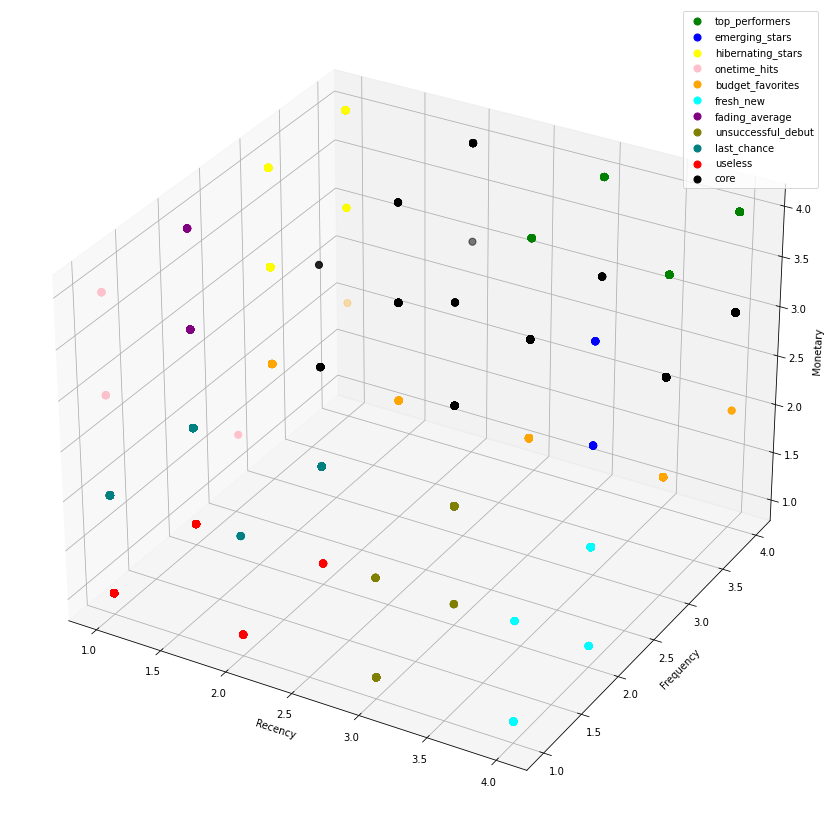

In [237]:
x = rfm_data['R']
y = rfm_data['F']
z = rfm_data['M']
segment = rfm_data['RFM_segments']

colors = {"top_performers": "green",
        "emerging_stars": "blue",
        "hibernating_stars": "yellow",
        "onetime_hits": "pink",
        "budget_favorites": "orange",
        "fresh_new": "cyan",
        "fading_average": "purple",
        "unsuccessful_debut": "olive",
        "last_chance": "teal",
        "useless": "red",
        "core": "black"}

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

for segment_name, color in colors.items():
    mask = (segment == segment_name)
    ax.scatter(x[mask], y[mask], z[mask], c=color, label=segment_name,s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()


Except for the core, which varies significantly, segmentation was effective and accurate. Apparently the core segment could be divided into two new segments depending on recency value. However, since our maing goal is to indentify products that we need to exclude I suggest leaving it as is. Due high monetary and moderate frequency value current core products are definetly not the canidates for expelling out of the product range.

Applying rfm_segment to each purchase in the main dataframe.

In [238]:
df_product = df_product.merge(rfm_data['RFM_segments'], on='description', how='left')
df_product.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123a   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406b       cream cupid hearts coat hanger         8   
3     536365     84029g  knitted union flag hot water bottle         6   
4     536365     84029e        red woolly hottie white heart         6   

         invoice_date  unit_price  customer_id        features  \
0 2018-11-29 08:26:00        2.55        17850         [white]   
1 2018-11-29 08:26:00        3.39        17850  [white, metal]   
2 2018-11-29 08:26:00        2.75        17850              []   
3 2018-11-29 08:26:00        3.39        17850              []   
4 2018-11-29 08:26:00        3.39        17850    [white, red]   

                     clean_description        category  revenue  \
0         hanging heart t-light holder      home_decor    15.30   
1                              lantern      home_decor    20.34   
2        cream cupid heart coat hanger  kitchen_dining    22.00   
3  knitted union flag hot water bottle   personal_care    20.34   
4                  woolly hottie heart      home_decor    20.34   

   invoice_weekday  invoice_month invoice_month_dt invoice_month_year  \
0                3             11       2018-11-01     November, 2018   
1                3             11       2018-11-01     November, 2018   
2                3             11       2018-11-01     November, 2018   
3                3             11       2018-11-01     November, 2018   
4                3             11       2018-11-01     November, 2018   

  customer_category       RFM_segments  
0         corporate     top_performers  
1         corporate  hibernating_stars  
2         corporate               core  
3         corporate     top_performers  
4         corporate     top_performers

We are curious about top 5 most profitable items within each segment

In [239]:
segment_titles = df_product['RFM_segments'].unique()

In [240]:
for each in segment_titles:
    seg = df_product.query("RFM_segments == @each")
    print(f"Top 5 most profitable product in segment '{each}':")
    print(seg.groupby('description')['revenue'].sum().reset_index().sort_values('revenue', ascending = False).head())
    print('-'*50)
    print('')

Top 5 most profitable product in segment 'top_performers':
                            description    revenue
567            regency cakestand 3 tier  167917.74
798  white hanging heart t-light holder   99571.17
470                       party bunting   98016.68
357             jumbo bag red retrospot   90647.23
517                  rabbit night light   66732.75
--------------------------------------------------

Top 5 most profitable product in segment 'hibernating_stars':
                          description   revenue
103       gin   tonic diet metal sign  22000.67
164        picnic basket wicker large  19202.76
128         jumbo bag doiley patterns  17245.81
62   colour glass star t-light holder  17066.45
223              small popcorn holder  17027.10
--------------------------------------------------

Top 5 most profitable product in segment 'core':
                        description   revenue
646          tea time party bunting  12709.22
26      alarm clock bakelike orange   89

Doesn't looks like we have any consistent pattern within each segment, most of the top items in each segment have nothing in common. In the next chapter will define it for sure.

Now let's check how the main metrics distribute across RFM segments

In [241]:
RFM_overall_stat = (df_product
            .groupby('RFM_segments')
            .agg({'revenue':'sum','quantity':'sum','description':'nunique'})
            .reset_index()
            .sort_values('revenue', ascending=False))
RFM_overall_stat = RFM_overall_stat.rename(columns={'description': 'n_unique_products'})
RFM_overall_stat ['revenue_per_unique_products'] = round(RFM_overall_stat['revenue']/RFM_overall_stat['n_unique_products'],1)
RFM_overall_stat.sort_values('revenue_per_unique_products', ascending = False)

RFM_segments      revenue  quantity  n_unique_products  \
8       top_performers  7285315.490   3465266                834   
7         onetime_hits    66967.570      5417                 17   
5    hibernating_stars   784768.460    420743                261   
2       emerging_stars    54358.720     26996                 34   
1                 core  1084999.320    960820                747   
3       fading_average   144041.450     44600                102   
0     budget_favorites   102122.760    162965                219   
6          last_chance   155509.870    120712                505   
4            fresh_new    57880.250     39228                228   
9   unsuccessful_debut    45488.540     39349                190   
10             useless    35333.953     27782                853   

    revenue_per_unique_products  
8                        8735.4  
7                        3939.3  
5                        3006.8  
2                        1598.8  
1                        1452.5  
3                        1412.2  
0                         466.3  
6                         307.9  
4                         253.9  
9                         239.4  
10                         41.4

We have  853 products been assigned to 'useless' segment that generated significantly less revenue compared to the top-performing 834 products. Each of these less profitable products has brought us only 41.4 units of revenue, whereas each of the top performers has generated 8735 units of revenue. Although we don't have data on inventory expenses, we can assume that 41.4 units of revenue are insufficient to cover the company's expenses. Therefore, it is another reason to exclude all 'useless' products and instead fill the inventory with more amount of products that have the potential to generate higher revenue.

# Setting the Product Range for the Upcoming Year

As we now have clean data and enough analytical cuts let's have extra details on our decision to exclude 'useless' products.

We already aware of slight differences in the most popular items between corporate and individual users, with some products being equally popular among both categories and others being unique to each. Now in order to help us decide whether it makes sense to focus on certain customer categories while setting up our product range, we need to examine whether there are any differences in the distribution of product categories and RFM segments, and quantify these differences. It's possible that any differences will be subtle, in which case it may be worth to continue offering products to both categories. The same check we are going apply for product categories over RFM_segments to check if we have some product categories that consist of more 'useless' product or conversly 'top_performance' products.

Number of unique corporate/individual customer in each segments

In [242]:
cust_by_cat_and_RFM = (df_product
                     .pivot_table(index = 'RFM_segments', 
                                  columns = 'customer_category',
                                  values = 'customer_id',
                                  aggfunc = 'nunique'))
cust_by_cat_and_RFM

customer_category   corporate  individual  unknown
RFM_segments                                      
budget_favorites          252        1868        1
core                      330        3531        1
emerging_stars            155         516        1
fading_average            228        1202        1
fresh_new                 209        1118        1
hibernating_stars         327        3101        1
last_chance               264        1982        1
onetime_hits               33          60        1
top_performers            337        3921        1
unsuccessful_debut        188        1143        1
useless                   176        1004        1

Share within each customer category

In [243]:
cust_by_cat_and_RFM_SHARE = round(cust_by_cat_and_RFM/cust_by_cat_and_RFM.sum()*100,1)
cust_by_cat_and_RFM_SHARE

customer_category   corporate  individual  unknown
RFM_segments                                      
budget_favorites         10.1         9.6      9.1
core                     13.2        18.2      9.1
emerging_stars            6.2         2.7      9.1
fading_average            9.1         6.2      9.1
fresh_new                 8.4         5.7      9.1
hibernating_stars        13.1        15.9      9.1
last_chance              10.6        10.2      9.1
onetime_hits              1.3         0.3      9.1
top_performers           13.5        20.2      9.1
unsuccessful_debut        7.5         5.9      9.1
useless                   7.0         5.2      9.1

Neither customer category has a significant share of products from the useless segment. This implies that it is preferable to continue targeting both kind of customer, with slight variations depending on the proportion of segments. For example, among individual customers, we should implement more aggressive marketing campaigns to enhance the visibility of 'emerging_stars' products. Another option we can investigate the factors that led corporate customers to make purchases from the 'onetime_hits' segment.

In [244]:
revenue_by_cat_and_RFM = (df_product
                     .pivot_table(index = 'RFM_segments', 
                                  columns = 'customer_category',
                                  values = 'revenue',
                                  aggfunc =  'sum'))
revenue_by_cat_and_RFM

customer_category    corporate   individual     unknown
RFM_segments                                           
budget_favorites      31072.80    43704.790    27345.17
core                 407674.40   502558.010   174766.91
emerging_stars        36786.04    13715.430     3857.25
fading_average        70770.51    60615.950    12654.99
fresh_new             16788.08    24887.430    16204.74
hibernating_stars    362132.12   302576.160   120060.18
last_chance           50781.30    74274.690    30453.88
onetime_hits          61195.76     5457.520      314.29
top_performers      3512346.66  2670887.920  1102080.91
unsuccessful_debut    13070.23    22923.020     9495.29
useless                8828.01    17874.233     8631.71

In [245]:
revenue_by_cat_and_RFM_SHARE = round(revenue_by_cat_and_RFM/revenue_by_cat_and_RFM.sum()*100,1)
revenue_by_cat_and_RFM_SHARE

customer_category   corporate  individual  unknown
RFM_segments                                      
budget_favorites          0.7         1.2      1.8
core                      8.9        13.4     11.6
emerging_stars            0.8         0.4      0.3
fading_average            1.5         1.6      0.8
fresh_new                 0.4         0.7      1.1
hibernating_stars         7.9         8.1      8.0
last_chance               1.1         2.0      2.0
onetime_hits              1.3         0.1      0.0
top_performers           76.8        71.4     73.2
unsuccessful_debut        0.3         0.6      0.6
useless                   0.2         0.5      0.6

In [246]:
revenue_by_cat_and_RFM_SHARE_tot = round(revenue_by_cat_and_RFM/revenue_by_cat_and_RFM.sum().sum()*100,1)
revenue_by_cat_and_RFM_SHARE_tot

customer_category   corporate  individual  unknown
RFM_segments                                      
budget_favorites          0.3         0.4      0.3
core                      4.2         5.1      1.8
emerging_stars            0.4         0.1      0.0
fading_average            0.7         0.6      0.1
fresh_new                 0.2         0.3      0.2
hibernating_stars         3.7         3.1      1.2
last_chance               0.5         0.8      0.3
onetime_hits              0.6         0.1      0.0
top_performers           35.8        27.2     11.2
unsuccessful_debut        0.1         0.2      0.1
useless                   0.1         0.2      0.1

The same conclusion after checking revenue distribtion by customer categories across RFM segments.

Moving on to product categories

In [247]:
products_by_prcat_and_RFM = (df_product
                     .pivot_table(index = 'RFM_segments', 
                                  columns = 'category',
                                  values = 'description',
                                  aggfunc = 'nunique'))
products_by_prcat_and_RFM

category            accessories  furniture_storage  games_hobbies_kids  \
RFM_segments                                                             
budget_favorites           16.0                7.0                10.0   
core                       45.0               27.0                38.0   
emerging_stars              1.0                1.0                 2.0   
fading_average              8.0                9.0                 1.0   
fresh_new                  53.0                5.0                 2.0   
hibernating_stars          11.0               14.0                 8.0   
last_chance                60.0               15.0                11.0   
onetime_hits                NaN                4.0                 NaN   
top_performers             75.0               31.0                60.0   
unsuccessful_debut         40.0                8.0                 1.0   
useless                   216.0               23.0                 8.0   

category            holidays_celebrations  home_decor  kitchen_dining  other  \
RFM_segments                                                                   
budget_favorites                     23.0        42.0            40.0   46.0   
core                                106.0       198.0           140.0   95.0   
emerging_stars                        4.0        15.0             5.0    5.0   
fading_average                        6.0        37.0            17.0   19.0   
fresh_new                             8.0        68.0            19.0   52.0   
hibernating_stars                    27.0        71.0            61.0   47.0   
last_chance                          60.0       128.0            62.0  124.0   
onetime_hits                          1.0         9.0             2.0    1.0   
top_performers                       86.0       202.0           212.0   93.0   
unsuccessful_debut                   20.0        41.0            11.0   51.0   
useless                              84.0       186.0           106.0  190.0   

category            personal_care  stationery  tools  
RFM_segments                                          
budget_favorites              7.0        20.0    8.0  
core                         24.0        61.0   13.0  
emerging_stars                NaN         1.0    NaN  
fading_average                NaN         2.0    3.0  
fresh_new                     2.0        16.0    3.0  
hibernating_stars             7.0        10.0    5.0  
last_chance                  12.0        28.0    5.0  
onetime_hits                  NaN         NaN    NaN  
top_performers               27.0        36.0   12.0  
unsuccessful_debut            1.0        16.0    1.0  
useless                       4.0        32.0    4.0

In [248]:
products_by_prcat_and_RFM_SHARE = round(products_by_prcat_and_RFM/products_by_prcat_and_RFM.sum()*100,1)
products_by_prcat_and_RFM_SHARE

category            accessories  furniture_storage  games_hobbies_kids  \
RFM_segments                                                             
budget_favorites            3.0                4.9                 7.1   
core                        8.6               18.8                27.0   
emerging_stars              0.2                0.7                 1.4   
fading_average              1.5                6.2                 0.7   
fresh_new                  10.1                3.5                 1.4   
hibernating_stars           2.1                9.7                 5.7   
last_chance                11.4               10.4                 7.8   
onetime_hits                NaN                2.8                 NaN   
top_performers             14.3               21.5                42.6   
unsuccessful_debut          7.6                5.6                 0.7   
useless                    41.1               16.0                 5.7   

category            holidays_celebrations  home_decor  kitchen_dining  other  \
RFM_segments                                                                   
budget_favorites                      5.4         4.2             5.9    6.4   
core                                 24.9        19.9            20.7   13.1   
emerging_stars                        0.9         1.5             0.7    0.7   
fading_average                        1.4         3.7             2.5    2.6   
fresh_new                             1.9         6.8             2.8    7.2   
hibernating_stars                     6.4         7.1             9.0    6.5   
last_chance                          14.1        12.8             9.2   17.2   
onetime_hits                          0.2         0.9             0.3    0.1   
top_performers                       20.2        20.3            31.4   12.9   
unsuccessful_debut                    4.7         4.1             1.6    7.1   
useless                              19.8        18.7            15.7   26.3   

category            personal_care  stationery  tools  
RFM_segments                                          
budget_favorites              8.3         9.0   14.8  
core                         28.6        27.5   24.1  
emerging_stars                NaN         0.5    NaN  
fading_average                NaN         0.9    5.6  
fresh_new                     2.4         7.2    5.6  
hibernating_stars             8.3         4.5    9.3  
last_chance                  14.3        12.6    9.3  
onetime_hits                  NaN         NaN    NaN  
top_performers               32.1        16.2   22.2  
unsuccessful_debut            1.2         7.2    1.9  
useless                       4.8        14.4    7.4

Among accessories 41% of items happened to be useless. The highest proportion of 'top_performers' is among games_hobbies_kids

Both in terms of customers and product categories we didn't find the reason to exclude entire categories since none of them have prevailing share of useless products.
So the current decision is to exclude only those products that were assigned to RFM segment 'useless' regardless of the product or customer category.

Before that let's check if we encounter 'useless' products among strongest pairings we defined during basket analysis. If so we will leave those products in the range for the upcoming year.


Converting Apriori algorythm results to strings at first

In [249]:
pairings = rules['antecedents'].head(40).apply(lambda x: next(iter(x))).reset_index()
uniq_pairings = pairings['antecedents'].unique()

Filtering original dataframe on RFM_segment 'useless' and later checking we encounter the unique product titles from pairings

In [250]:
found_pairings = False

useless_segment = df_product.query('RFM_segments == "useless"')
for each in uniq_pairings:
    useless_pairings = useless_segment.query('description ==@each')
    if len(useless_pairings) > 0:
        print(useless_pairings)
        found_pairings = True
        
if found_rows == False:
    print("No pairing products in useless product segment")

No pairing products in useless product segment


In [251]:
found_pairings = False

useless_segment = df_product.query('RFM_segments == "last_chance"')
for each in uniq_pairings:
    useless_pairings = useless_segment.query('description ==@each')
    if len(useless_pairings) > 0:
        print(useless_pairings)
        found_pairings = True
        
if found_rows == False:
    print("No pairing products in last_chance product segment")

No pairing products in last_chance product segment


No reason to filter useless product - to exclude all of them! 

And the last, we are going to check revenue over time for each segment in order to determine if we have any difference in seasonality for each segment (and especially for top_performance) from the overall seasonality.

In [252]:
month_year_sales_segments = (df_product
                 .groupby(['invoice_month_year','invoice_month_dt','RFM_segments'])
                 .agg({'revenue':'sum','quantity':'sum'})
                 .reset_index()
                .sort_values('invoice_month_dt'))
month_year_sales_segments.head()

invoice_month_year invoice_month_dt       RFM_segments   revenue  quantity
108     November, 2018       2018-11-01   budget_favorites    874.57       933
111     November, 2018       2018-11-01     fading_average   3404.44       715
112     November, 2018       2018-11-01          fresh_new    320.28       155
113     November, 2018       2018-11-01  hibernating_stars  10895.91      5842
114     November, 2018       2018-11-01        last_chance   3529.45      2238

In [253]:
month_year_sales_segments['revenue_cumulative'] = (month_year_sales_segments
                                                   .groupby(['invoice_month_year', 'RFM_segments'])['revenue']
                                                   .transform('cumsum'))

As we have several segments with significantly higher revenue it is better to group segments revenue dynamics in 3 charts, otherwise lines for the smallest segments will be indistinguishable.

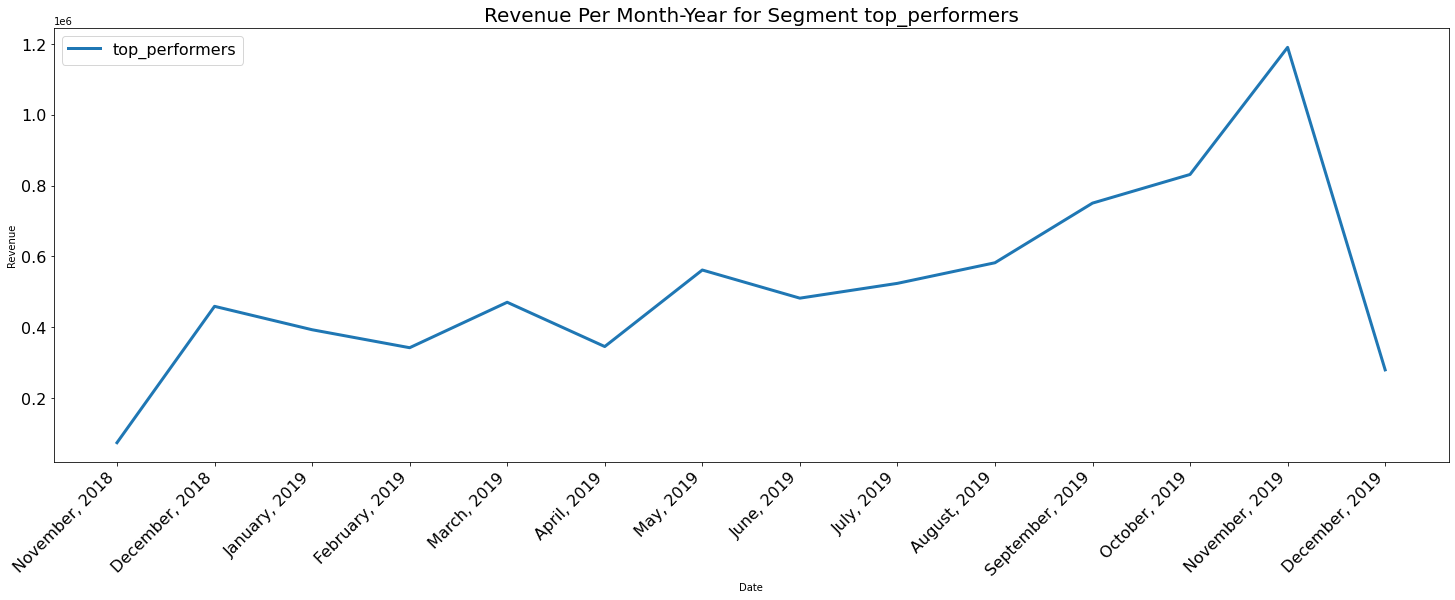

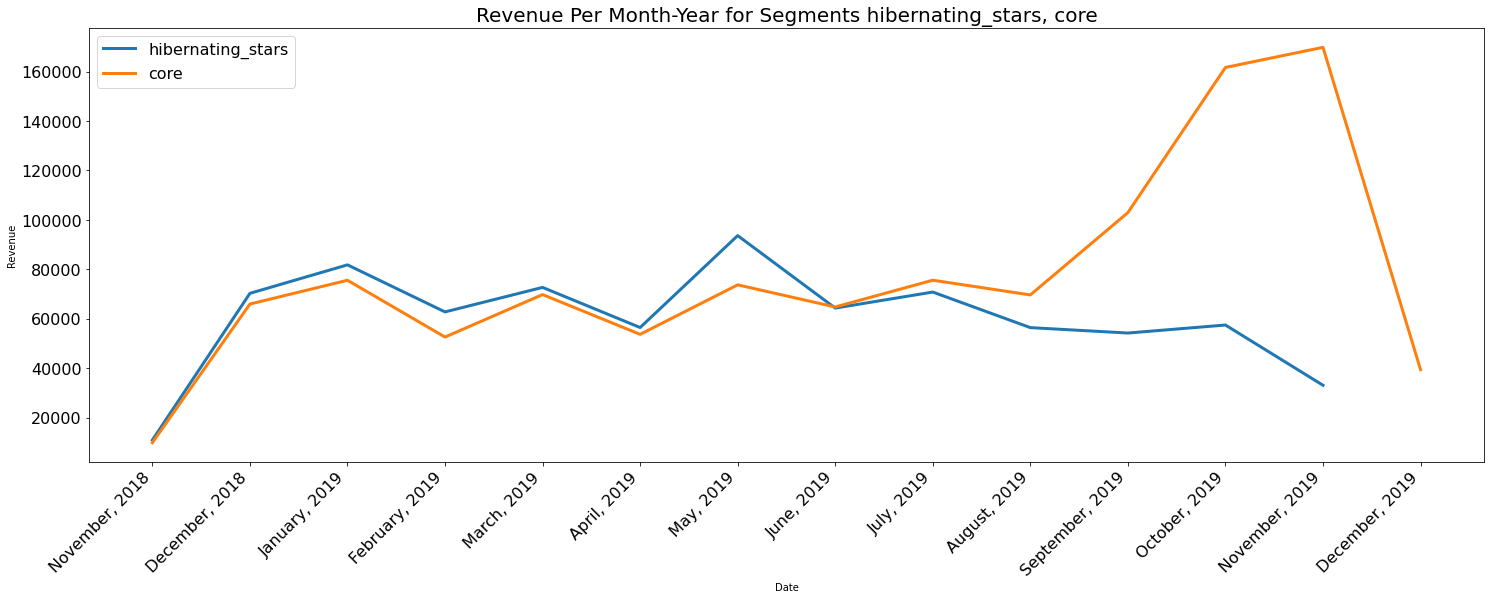

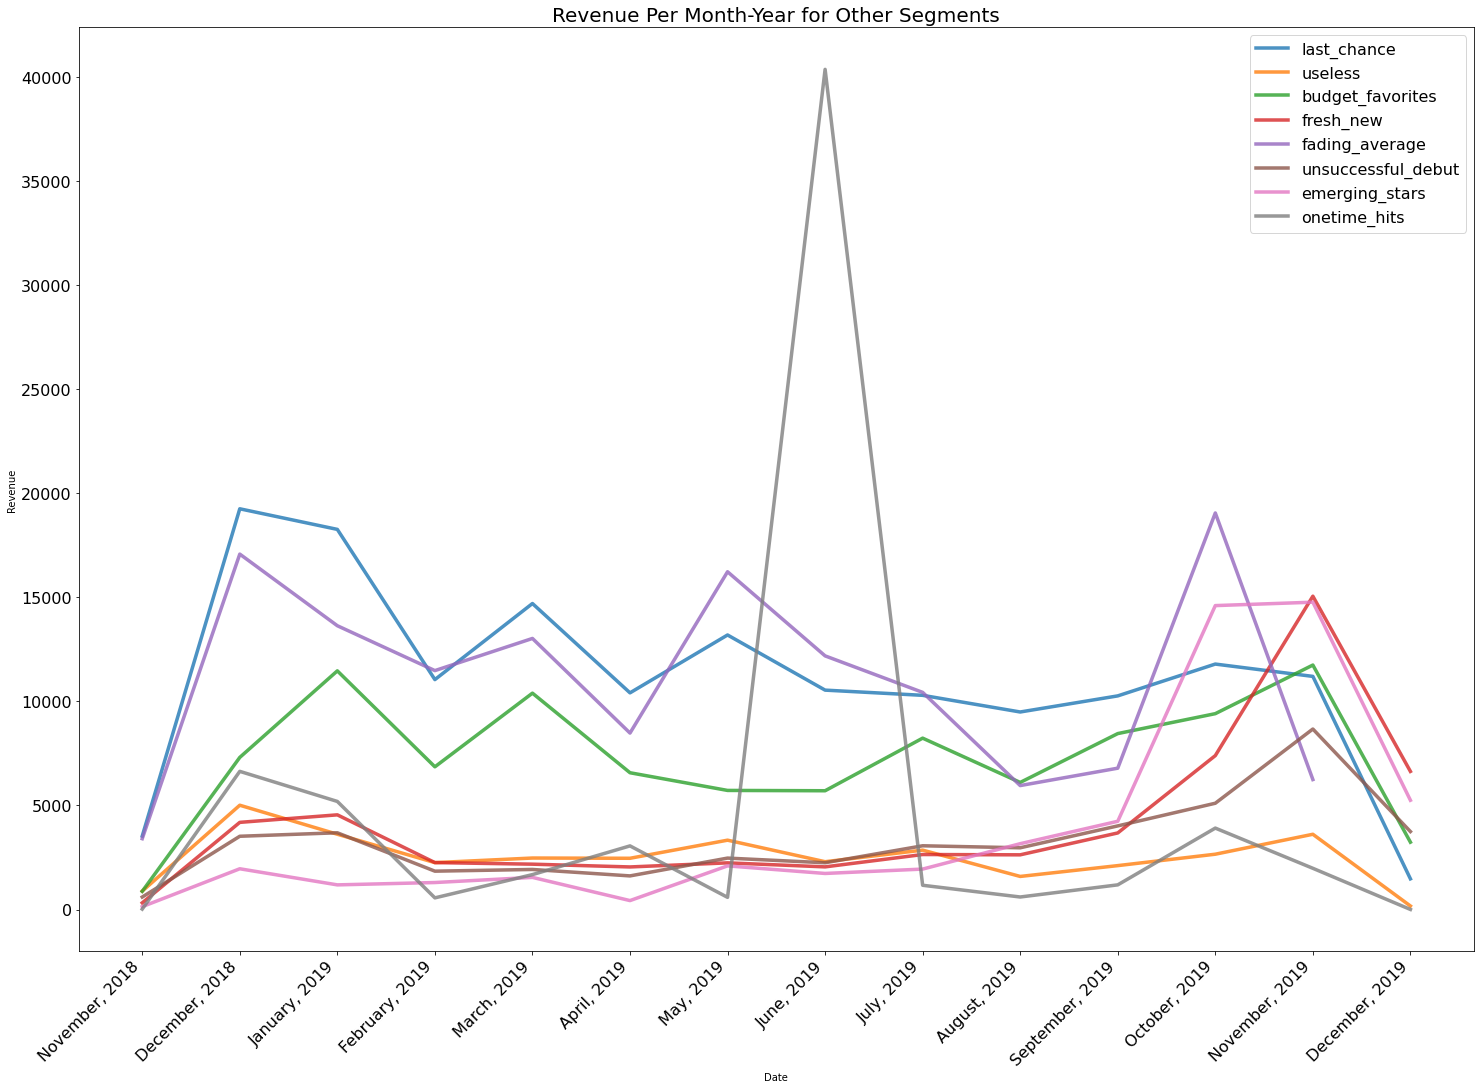

In [254]:
segment_high_rev = ['top_performers']
segment_mid_rev = ['hibernating_stars', 'core']
segment_low_rev = ['last_chance', 'useless', 'budget_favorites', 'fresh_new', 'fading_average',
                   'unsuccessful_debut', 'emerging_stars', 'onetime_hits']

# Chart for 'segment_high_rev'
plt.figure(figsize=(25, 8))
for seg in segment_high_rev:
    seg_data = month_year_sales_segments[month_year_sales_segments['RFM_segments'] == seg]
    plt.plot(seg_data['invoice_month_year'], seg_data['revenue'], linewidth=3.0, label=seg)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 16)
plt.title('Revenue Per Month-Year for Segment ' + ', '.join(segment_high_rev), size=20)
plt.legend(fontsize=16)
plt.show()

# Chart for 'segment_mid_rev'
plt.figure(figsize=(25, 8))
for seg in segment_mid_rev:
    seg_data = month_year_sales_segments[month_year_sales_segments['RFM_segments'] == seg]
    plt.plot(seg_data['invoice_month_year'], seg_data['revenue'], linewidth=3.0, label=seg)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 16)
plt.title('Revenue Per Month-Year for Segments ' + ', '.join(segment_mid_rev), size=20)
plt.legend(fontsize=16)
plt.show()

# Chart for the rest of the segments
plt.figure(figsize=(25, 17))
for seg in segment_low_rev:
    seg_data = month_year_sales_segments[month_year_sales_segments['RFM_segments'] == seg]
    plt.plot(seg_data['invoice_month_year'], seg_data['revenue'], linewidth=3.5, alpha=0.8, label=seg)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks (fontsize = 16, rotation = 45, ha = 'right')
plt.yticks (fontsize = 16)
plt.title('Revenue Per Month-Year for Other Segments', size=20)
plt.legend(fontsize=16)
plt.show()

First of all, we observe that the revenue dynamics support the segmentation we have implemented. We can see typical fluctuations for different segments, for example:

- hibernating stars -  gradual decrease in revenue from relatively high values in the past
- one-time hits - extreme peak in revenue, but generally - low popularity
- emerging stars - slow increase from relatively low values in the past

As for the main conclusion, we can determine that the most important segment - top performers follows the general seasonality that we previously identified earlier in section 6.6 - with peak in november. Lets also compare month and weekday patterns for top performers.

In [255]:
top_segment_sales = df_product.query('RFM_segments == "top_performers"')
top_per_weekday_sales = (top_segment_sales.groupby('invoice_weekday')
                 .agg({'revenue':'sum', 'quantity':'sum'})
                 .reset_index()
                 .sort_values('invoice_weekday'))
top_per_weekday_sales['weekday_name'] = top_per_weekday_sales['invoice_weekday'].apply(lambda x: calendar.day_name[x])
top_per_weekday_sales

invoice_weekday     revenue  quantity weekday_name
0                0   573287.68    285139       Monday
1                1  1224808.02    556251      Tuesday
2                2  1469690.49    662590    Wednesday
3                3  1295320.06    651794     Thursday
4                4  1584162.13    789882       Friday
5                5  1138047.11    519610     Saturday

In [256]:
top_per_month_sales = (top_segment_sales
               .groupby('invoice_month')
               .agg({'revenue':'sum','quantity':'sum'})
               .reset_index()
               .sort_values('invoice_month'))
top_per_month_sales['month_name'] = top_per_month_sales['invoice_month'].apply(lambda x: calendar.month_name[x])
top_per_month_sales.head()

invoice_month    revenue  quantity month_name
0              1  392895.69    185597    January
1              2  342112.23    167906   February
2              3  470478.18    237296      March
3              4  345414.35    180836      April
4              5  561567.82    272622        May

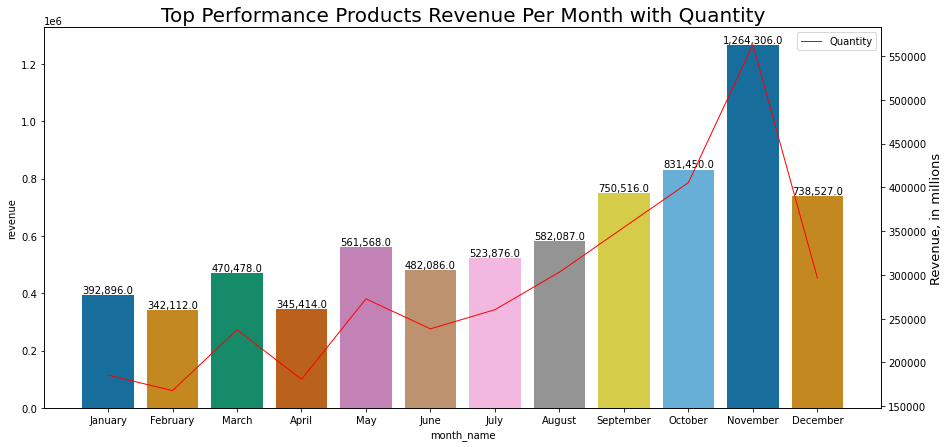

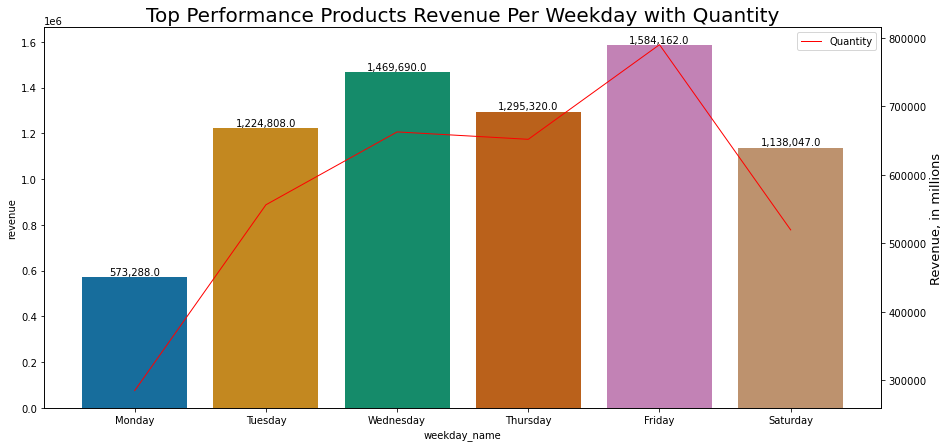

In [257]:
def bar_plots(df, x_col, x_label, title):
    plt.figure(figsize=(15, 7))
    ax = sns.barplot(data=df, x=x_col, y='revenue', palette='colorblind')
    
    ax2 = ax.twinx()
    ax2.plot(df[x_col], df['quantity'], color='red', linewidth=1, label = 'Quantity')
    
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel('Revenue, in millions', fontsize=13)
    plt.xticks(size=13)
    plt.title(title, fontsize=20)
    
    for i in ax.containers:
        ax.bar_label(i, labels=[format(round(value, 0), ',') for value in i.datavalues])
    
    ax2.legend()
    plt.show()
    
bar_plots(top_per_month_sales,
            'month_name', 'Months',
            'Top Performance Products Revenue Per Month with Quantity')  

bar_plots(top_per_weekday_sales,
            'weekday_name', 'Weekdays',
            'Top Performance Products Revenue Per Weekday with Quantity')
    

The same pattern here as well

# Conclusion & Recommendations

The data analysis of the sales data spanning a year from 2018 to 2019 has revealed several crucial insights. The preprocessing stage was essential in ensuring the data was clean and accurate. During this stage, we carried out various data cleaning tasks such as removing duplicates, handling missing values, and categorizing products. The clean data consisted of over half a million purchases of 3990 unique products by 4325 unique customers, generating a total revenue of about 9.8 million.

The analysis showed that the quantity and revenue from sales remained stable for most of the year but increased towards the end of 2019. This could be attributed to the holiday season or increasing popularity of our store. The product categories 'kitchen_dining' and 'home_decor' were the most profitable, accounting for nearly half of the total revenue.

Splitting customers into individual and corporate categories revealed different buying patterns. Despite fewer corporate customers, their total revenue and quantity purchased were significantly higher due to the large orders they placed.

The RFM analysis identified products that are worth focusing on for the next year. It segmented the products into various categories based on their recency, frequency, and monetary values. The analysis suggested that 853 products fell into the 'useless' category, contributing very little to the overall revenue and customers activity.

The seasonality analysis showed that the pre-holiday season, particularly November and December, is the most profitable period. The revenue generated in these months was significantly higher than in other months.


Based on these insights, here are some recommendations for the upcoming year:

- Product Management: Focus on maintaining the stock of 'top performers' and 'core' as identified by the RFM analysis. These products generate significant revenue and have high potential. The products classified as 'useless' should be excluded from the inventory as they contribute very little to the overall revenue. For the rest of segments targeted action is provided in RFM chapter.

- Customer Segmentation: Continue targeting both individual and corporate customers. Implement more aggressive marketing campaigns for individual customers, especially for 'emerging stars' products. Investigate factors that led corporate customers to purchase  'onetime_hits' products.

- Seasonal Stock Management: Optimize inventory levels to match the increased demand during the holiday season, particularly for categories 'home_decor', 'holidays_celebrations', and 'games_hobbies_kids'.

- Return Management: Although the most returned products caused significant revenue loss, it appears that these were likely due to customer mistakes rather than product issues. However, further investigation into return reasons is recommended to prevent future losses.

- Basket Analysis: Ensure that products identified as strong pairings during the basket analysis are well-stocked, as they often sell together.

Implementing these recommendations will help optimize inventory management, improve product range, and increased revenue in the upcoming year.

# Dashboard & Presentation

Preparding data for dashboard

In [258]:
data_viz = df_product[['invoice_no','description','quantity','revenue','customer_id','category','customer_category','RFM_segments','invoice_date','invoice_month_year']]

Saving updated data to separate .csv file

In [259]:
data_viz.to_csv("data_viz.csv", index=False)


In [260]:
data_viz.head()

invoice_no                          description  quantity  revenue  \
0     536365   white hanging heart t-light holder         6    15.30   
1     536365                  white metal lantern         6    20.34   
2     536365       cream cupid hearts coat hanger         8    22.00   
3     536365  knitted union flag hot water bottle         6    20.34   
4     536365        red woolly hottie white heart         6    20.34   

   customer_id        category customer_category       RFM_segments  \
0        17850      home_decor         corporate     top_performers   
1        17850      home_decor         corporate  hibernating_stars   
2        17850  kitchen_dining         corporate               core   
3        17850   personal_care         corporate     top_performers   
4        17850      home_decor         corporate     top_performers   

         invoice_date invoice_month_year  
0 2018-11-29 08:26:00     November, 2018  
1 2018-11-29 08:26:00     November, 2018  
2 2018-11-29 08:26:00     November, 2018  
3 2018-11-29 08:26:00     November, 2018  
4 2018-11-29 08:26:00     November, 2018

Link to public dashboard

https://public.tableau.com/views/Final_Project_Product_Range_Dashboard/ProductRangeDashboard?:language=en-US&:display_count=n&:origin=viz_share_link

Link to presentation

https://docs.google.com/presentation/d/1s0dDMDDDfbKFMF5bVeQnkpS0usfxXRhGDss8TGyUUY4/edit?usp=sharing